# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [2]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
# !pip install -U seaborn

In [4]:
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import timeit

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

from keras.models import Sequential
from keras.layers import Dense, Dropout
# import tensorflow
from keras.callbacks import EarlyStopping

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or 

# Project Overview

In this Udacity Nanodigree Capstone Project, Starbucks provided simulated data of their reward system. As a simplification, there are no explicit products to track. Only the amounts of each transaction or offer are recorded.
Each person in the simulation has some hidden traits that influence their purchasing patterns and are associated with their observable traits. People produce various events, including receiving offers, opening offers, and making purchases.

There are three types of offers that can be sent: buy-one-get-one (BOGO), discount, and informational. In a BOGO offer, a user needs to spend a certain amount to get a reward equal to that threshold amount. In a discount, a user gains a reward equal to a fraction of the amount spent. In an informational offer, there is no reward, but neither is there a requisite amount that the user is expected to spend. Offers can be delivered via multiple channels.

# Problem Statement

The goal of this data analysis is to help Starbucks company to understand how to target their customers with offers, that would encourage them to continue purchasing their products. 
The project follows the following steps:
Data exploration and pre-processing.
Data engineering.
Data analysis.
Modeling.
Conclusion.

# Data exploration and pre-processing

## Portfolio DataFrame

* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [5]:
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [6]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [7]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [8]:
# Check if the DF contains missing values

portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [9]:
# Count the number of unique offers available for the customers

portfolio['id'].nunique()

10

In [10]:
# Visulaize the unique offer ids

portfolio['id'].unique()

array(['ae264e3637204a6fb9bb56bc8210ddfd',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       '3f207df678b143eea3cee63160fa8bed',
       '9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '5a8bc65990b245e5a138643cd4eb9837',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '2906b810c7d4411798c6938adc9daaa5'], dtype=object)

In [11]:
# Check if, for each unique offer, a offer subgroup exist (eg., different durations, different difficulty, 
# or different discount)

portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

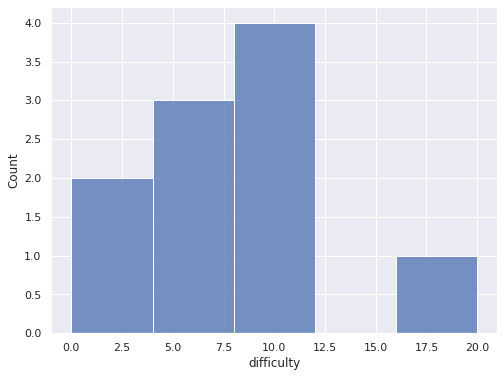

In [12]:
plt.figure(figsize=(8,6))
sns.set(style="darkgrid")
sns.histplot(data=portfolio, x="difficulty")
plt.savefig('01-portfolio_difficulty.png')

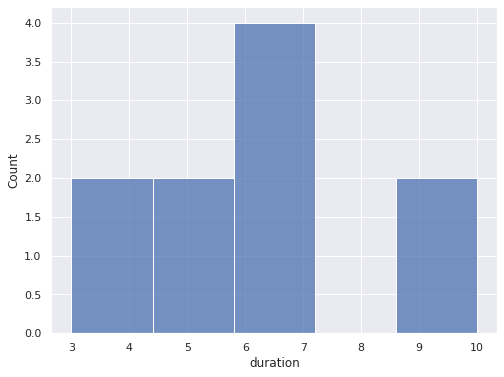

In [13]:
plt.figure(figsize=(8,6))
sns.set(style="darkgrid")
sns.histplot(data=portfolio, x="duration")
plt.savefig('01-portfolio_duration.png')

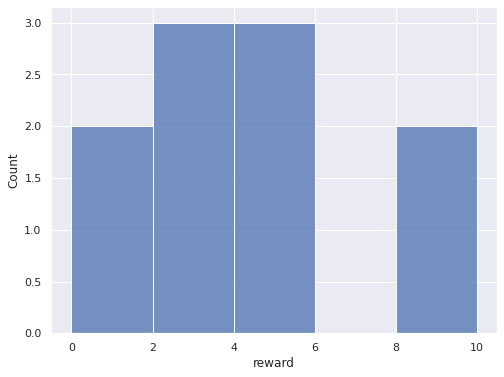

In [14]:
plt.figure(figsize=(8,6))
sns.set(style="darkgrid")
sns.histplot(data=portfolio, x="reward")
plt.savefig('01-portfolio_reward.png')

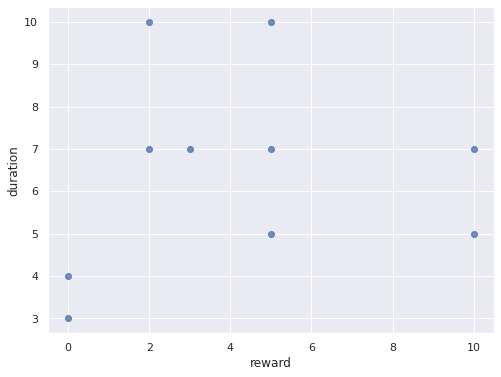

In [15]:
plt.figure(figsize=(8,6))
sns.regplot(x=portfolio["reward"], y=portfolio["duration"], fit_reg=False)
plt.savefig('02-scatter_reward_duration.png')

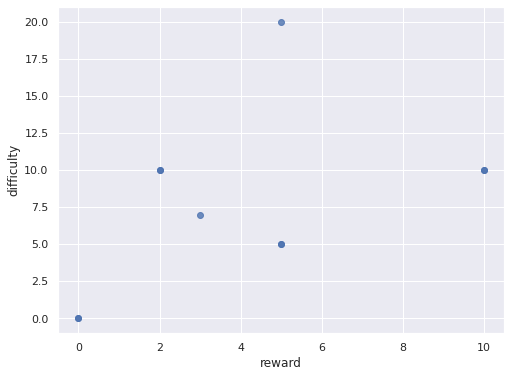

In [16]:
plt.figure(figsize=(8,6))
sns.regplot(x=portfolio["reward"], y=portfolio["difficulty"], fit_reg=False)
plt.savefig('02-scatter_reward_difficulty.png')

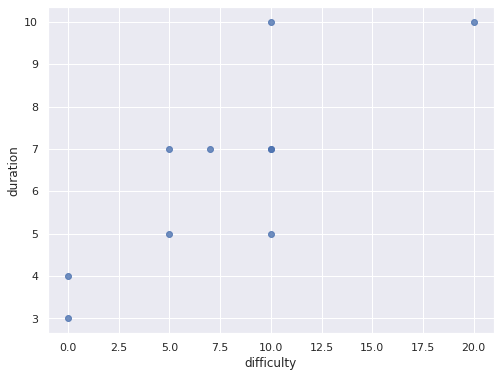

In [17]:
plt.figure(figsize=(8,6))
sns.regplot(x=portfolio["difficulty"], y=portfolio["duration"], fit_reg=False)
plt.savefig('02-scatter_difficulty_duration.png')

### Observations:
- This data frame doesn't have missing values.
- There are 3 unique offers: BOGO, discount, and informational.
- Each unique offer has at least 2 subgroups:
    - BOGO: 4 subgroups;
    - discount: 4 subgroups;
    - informational: 2 subgroups;
- The offers with the highest rewards have a duration of 10 days, and a difficulty of 10.
- The offer with the highest difficulty has not the highest reward, but only a reward of 6 USD.
- The offer with the highest difficulty also lasts the longest.
    
### Cleaning steps
- The channel column is not useful for any data analysis in the current form. It needs to be one hot encoded.
- The id column needs to be renamed to offer_id, to avoid confusion with the "id" column in the profile dataframe.
- The offer column needs to be replaced by 3 dummy columns so to better manage and analyze the offers information. 
- Convert duration from days to hours.

In [18]:
def portfolio_cleaning(df):
    
    """
    DESCRIPTION:
    
        This function take the portfolio DataFrame as input and it applies the following cleaning steps:
            - Hot encode the channel column;
            - Rename the 'id' column to 'offer_id';
            - Convert duration from days to hours;
            - Create 3 dummy columns for the 3 offers: BOGO, discount, and informational.
    
    INPUT: 
        df (DataFrame) - The original portfolio dataframe.
        
    OUTPUT
        clean_df (DataFrame) - The portfolio dataframe after the application of the cleaning steps.
        
    """
    # ------------------------------------------------#
    
    # Hot encode the channel column
    new_cols = ['email', 'mobile', 'social', 'web']
    col_names = ['channel-email', 'channel-mobile', 'channel-social', 'channel-web']
    
    for col, col_name in zip(new_cols, col_names):    
        df[col_name] = df['channels'].apply(lambda x: 1 if col in x else 0)
        
    # ------------------------------------------------#
        
    # Rename the 'id' column to 'offer_id'
    df = df.rename(columns={'id':'offer_id'})
    
    # ------------------------------------------------#
    
    # Convert duration from days to hours.
    df.duration = df.duration.apply(lambda x: x*24)
    
    # ------------------------------------------------#
    
    # Create 3 dummy columns for the 3 offers: BOGO, discount, and informational
    clean_df = pd.concat([df, 
                          pd.get_dummies(df['offer_type'], prefix='offer_type', prefix_sep='-')],
                          axis=1)
    
    # ------------------------------------------------#
    
    # Drop the channel and offer_type columns
    clean_df.drop(['channels', 'offer_type'], axis=1, inplace=True)
    
    # ------------------------------------------------#
    
    return clean_df

clean_portfolio = portfolio_cleaning(portfolio)

In [19]:
clean_portfolio.head(10)

,difficulty,duration,offer_id,reward,channel-email,channel-mobile,channel-social,channel-web,offer_type-bogo,offer_type-discount,offer_type-informational
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,1,1,1,0,1,0,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,96,3f207df678b143eea3cee63160fa8bed,0,1,1,0,1,0,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,0,1,1,0,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,0,0,1,0,1,0
5,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1,0
6,10,240,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1,0
7,0,72,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0,0,1
8,5,120,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0,0
9,10,168,2906b810c7d4411798c6938adc9daaa5,2,1,1,0,1,0,1,0


In [20]:
clean_portfolio.columns

Index(['difficulty', 'duration', 'offer_id', 'reward', 'channel-email',
       'channel-mobile', 'channel-social', 'channel-web', 'offer_type-bogo',
       'offer_type-discount', 'offer_type-informational'],
      dtype='object')

In [21]:
clean_portfolio.describe()

,difficulty,duration,reward,channel-email,channel-mobile,channel-social,channel-web,offer_type-bogo,offer_type-discount,offer_type-informational
count,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,7.700000,156.000000,4.200000,1.0,0.900000,0.600000,0.800000,0.400000,0.400000,0.200000
std,5.831905,55.713553,3.583915,0.0,0.316228,0.516398,0.421637,0.516398,0.516398,0.421637
min,0.000000,72.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,120.000000,2.000000,1.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,8.500000,168.000000,4.000000,1.0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,10.000000,168.000000,5.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,20.000000,240.000000,10.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Profile DataFrame

* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [22]:
profile.head(10)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [23]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [24]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [25]:
profile.shape

(17000, 5)

In [26]:
# Check if the DF contains missing values

profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [27]:
# Count the columns with a value of 118 (equivalent of missing value)
profile[profile.age == 118].count()

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64

In [28]:
profile.groupby('gender')['gender'].count()

gender
F    6129
M    8484
O     212
Name: gender, dtype: int64

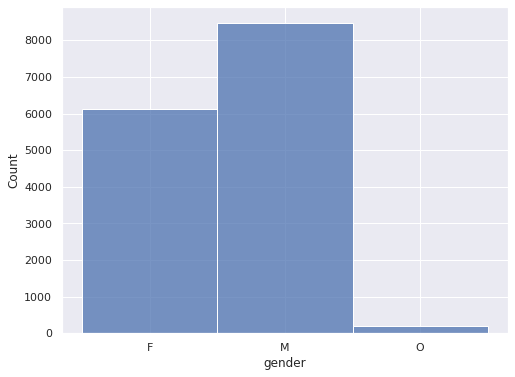

In [29]:
plt.figure(figsize=(8,6))
sns.set(style="darkgrid")
sns.histplot(data=profile, x="gender")
plt.savefig('01-profile-gender.png')

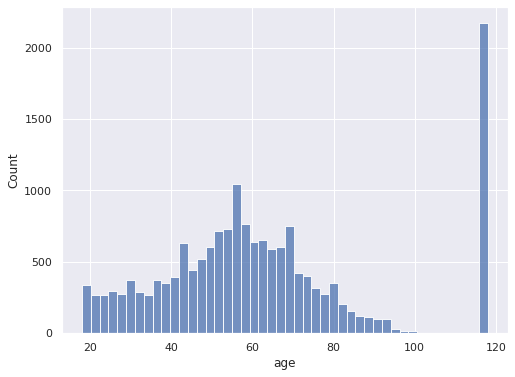

In [30]:
plt.figure(figsize=(8,6))
sns.set(style="darkgrid")
sns.histplot(data=profile, x="age")
plt.savefig('01-profile-age.png')

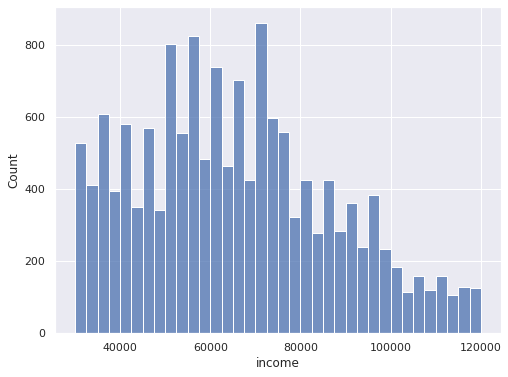

In [31]:
plt.figure(figsize=(8,6))
sns.set(style="darkgrid")
sns.histplot(data=profile, x="income")
plt.savefig('01-profile-income.png')

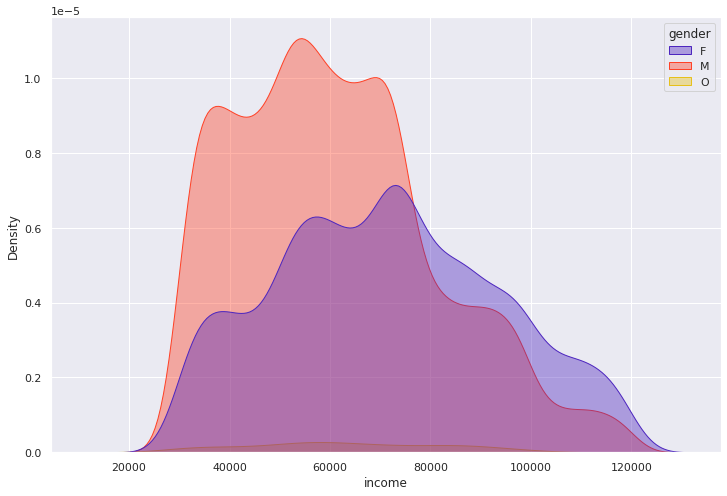

In [32]:
plt.figure(figsize=(12,8))
sns.set(style="darkgrid")
sns.kdeplot(data=profile, x="income", hue="gender", fill=True,  alpha=0.4, palette="CMRmap")
plt.savefig('01-income_gender.png')

### Observations
- There are 2175 missing values.
- Customers identified with the 'O' gender are the 1.2% of the whole dataset only.
- Most of customers are between 50 to 65 years old.
- The average income is between 50k and 70k USD.
- There are more man with an income between 20k and 70k than women, while there are more women with an income above 70k than men.
- The age distribution is similar for both genders.
- The 'became_member_on' column has the date in a form that doesn't allow any further analysis, and it needs to be converted to a different format.
- The columns 'age' and 'income' would be very hard to analyze in this format. Having a statistic of how many people, 55 years old, with a specific income, respond to an offer is not statistically interesting. Therefore, both columns will be converted into ranges.

### Cleaning steps
- Remove the missing data.
- Rename the 'id' column to 'customer_id'.
- Change the data type of the 'became_member_on' to the form 'yyyy-mm-dd'.
    - Count the number of days a customer has been using the app, using the date 2018-10-01 as a reference:
      The latest date entry in the data frame is 2018-07-26. Chosing the current date as reference would just give delta time above 1000 days. So we impose our reference date to be about 3 months later than the 2018-07-26.
    - Group the membership days in ranges (<180 days; 180-600 days; 1000 days; > 1000 days).
    - Hot encode the membership days ranges.
- Remove the 'O' gender because it is not statistically significant.
- One hot encode the gender column.
- Group the 'age' column into ranges (20–40; 40–60; >60).
    - Hot encode the age ranges.
- Group the 'income' column into ranges (30k-60k, 60k-90k, >90k). 
    - Hot encode income ranges.


In [33]:
def profile_cleaning(df):
    
    """
    DESCRIPTION:
    
        This function take the profile DataFrame as input and it applies the following cleaning steps:
            - Remove the missing data.
            - Rename the 'id' column to 'customer_id'.
            - Change the data type of the 'became_member_on' to the form 'yyyy-mm-dd'.
                - Count the number of days a customer has been using the app.
                - Group the membership days in ranges (<180 days; 180-600 days; 1000 days; > 1000 days).
                - Hot encode the membership days ranges.
            - Remove the 'O' gender because it is not statistically significant.
                - One hot encode the gender column.
            - Group the 'age' column into ranges by decades.
                - Hot encode the membership days ranges.
            - Group the 'income' column into ranges (30k-60k, 60k-90k, >90k).
                - Hot encode income ranges.

    INPUT: 
        df (DataFrame) - The original profile dataframe.
        
    OUTPUT
        df_clean (DataFrame) - The profile dataframe after the application of the cleaning steps.
        
    """
    # ------------------------------------------------#
    
    # Remove the missing data.
    df.dropna(inplace=True)
    
    # ------------------------------------------------#
    
    # Rename the 'id' column to 'customer_id'
    df = df.rename(columns={'id':'customer_id'})
    
    # ------------------------------------------------#
    
    # Change the data type of the 'became_member_on' to the form 'yyyy-mm-dd'.
    df['became_member_on'] = pd.to_datetime(df['became_member_on'], format='%Y%m%d')
    
    # Count the number of days a customer has been using the app.
    # The number of days is calculated with respect to date 2018-10-01, because the latest date recorded in the
    # dataframe is 2018-07-26. Calculating the time delta with respect to a more recent date, would just fill up
    # the column 'member_>1000 days'.
    df['member_days'] = (datetime.date(2018,10,1) - df['became_member_on'].dt.date)
    df['member_days'] = df['member_days'].dt.days
    
    # Group the membership days in ranges (<180 days; 180-600 days; 600-1000 days; > 1000 days).
    max_days = df['member_days'].max()
    df['member_days_ranges'] = pd.cut(df['member_days'], 
           bins=[1, 180, 600, 1000, max_days], 
           right=True, 
           labels=['member_<180 days', 'member_180-600 days', 'member_600-1000 days', 'member_>1000 days'], 
           include_lowest=True)
    
    # Hot encode the membership days ranges.
    df = pd.concat([df, pd.get_dummies(df['member_days_ranges'])], axis=1)
    
    # ------------------------------------------------#
    
    # Remove the 'O' gender
    df.drop(df.index[df['gender'] == 'O'], inplace=True)
    
    # Hot encode the gender column
    df = pd.concat([df, 
                    pd.get_dummies(df['gender'], prefix='gender', prefix_sep='-')],
                   axis=1)
        
    # ------------------------------------------------#
    
    # Group the 'age' column into ranges by decades.
    max_age = df['age'].max()
    df['age_ranges'] = pd.cut(df['age'], 
           bins=[1, 40, 60, max_age], 
           right=True, 
           labels=['age_20_40', 'age_40_60', 'age_>60'], 
           include_lowest=True)
    
    # Hot encode the membership days ranges.
    df = pd.concat([df, pd.get_dummies(df['age_ranges'])], axis=1)
    
    # ------------------------------------------------#
    
    # Group the 'income' column into ranges (30k-60k, 60k-90k, >90k)
    max_income = df['income'].max()
    df['income_ranges'] = pd.cut(df['income'], 
           bins=[0, 30000, 60000, 90000, max_income], 
           right=True, 
           labels=['income_<30k', 'income_30k-60k', 'income_60k-90k', 'income_>90k'], 
           include_lowest=True)
    
    # Hot encode income ranges
    df_clean = pd.concat([df, pd.get_dummies(df['income_ranges'])], axis=1)
    
    # ------------------------------------------------#
        
    # Drop the useless columns
    df_clean.drop(['member_days_ranges', 
#              'member_days',
             'gender', 
             'age', 
             'age_ranges', 
             'income', 
             'income_ranges'], 
            axis=1, 
            inplace=True)
    
    # ------------------------------------------------#
    
    return df_clean

clean_profile = profile_cleaning(profile)

In [34]:
clean_profile.head(10)

,became_member_on,customer_id,member_days,member_<180 days,member_180-600 days,member_600-1000 days,member_>1000 days,gender-F,gender-M,age_20_40,age_40_60,age_>60,income_<30k,income_30k-60k,income_60k-90k,income_>90k
1,2017-07-15,0610b486422d4921ae7d2bf64640c50b,443,0,1,0,0,1,0,0,1,0,0,0,0,1
3,2017-05-09,78afa995795e4d85b5d9ceeca43f5fef,510,0,1,0,0,1,0,0,0,1,0,0,0,1
5,2018-04-26,e2127556f4f64592b11af22de27a7932,158,1,0,0,0,0,1,0,0,1,0,0,1,0
8,2018-02-09,389bc3fa690240e798340f5a15918d5c,234,0,1,0,0,0,1,0,0,1,0,1,0,0
12,2017-11-11,2eeac8d8feae4a8cad5a6af0499a211d,324,0,1,0,0,0,1,0,1,0,0,1,0,0
13,2017-09-11,aa4862eba776480b8bb9c68455b8c2e1,385,0,1,0,0,1,0,0,0,1,0,1,0,0
14,2014-02-13,e12aeaf2d47d42479ea1c4ac3d8286c6,1691,0,0,0,1,0,1,1,0,0,0,1,0,0
15,2016-02-11,31dda685af34476cad5bc968bdb01c53,963,0,0,1,0,1,0,0,0,1,0,0,1,0
16,2014-11-13,62cf5e10845442329191fc246e7bcea3,1418,0,0,0,1,0,1,0,1,0,0,1,0,0
18,2017-12-31,6445de3b47274c759400cd68131d91b4,274,0,1,0,0,0,1,0,1,0,0,1,0,0


In [35]:
clean_profile.became_member_on.max()

Timestamp('2018-07-26 00:00:00')

In [36]:
clean_profile.columns

Index(['became_member_on', 'customer_id', 'member_days', 'member_<180 days',
       'member_180-600 days', 'member_600-1000 days', 'member_>1000 days',
       'gender-F', 'gender-M', 'age_20_40', 'age_40_60', 'age_>60',
       'income_<30k', 'income_30k-60k', 'income_60k-90k', 'income_>90k'],
      dtype='object')

## Transcript DataFrame

* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value: (dictionary) different values depending on event type
    - offer id: (string/hash) not associated with any "transaction"
    - amount: (numeric) money spent in "transaction"
    - reward: (numeric) money gained from "offer completed"

In [37]:
transcript.head(10)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [38]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [39]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [40]:
transcript.shape

(306534, 4)

In [41]:
transcript.groupby('event')['event'].count()

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: event, dtype: int64

In [42]:
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [43]:
transcript.tail(10)

,event,person,time,value
306524,transaction,d613ca9c59dd42f497bdbf6178da54a7,714,{'amount': 25.14}
306525,transaction,eec70ab28af74a22a4aeb889c0317944,714,{'amount': 43.58}
306526,transaction,24f56b5e1849462093931b164eb803b5,714,{'amount': 22.64}
306527,offer completed,24f56b5e1849462093931b164eb803b5,714,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
306528,transaction,5ca2620962114246ab218fc648eb3934,714,{'amount': 2.2}
306529,transaction,b3a1272bc9904337b331bf348c3e8c17,714,{'amount': 1.5899999999999999}
306530,transaction,68213b08d99a4ae1b0dcb72aebd9aa35,714,{'amount': 9.53}
306531,transaction,a00058cf10334a308c68e7631c529907,714,{'amount': 3.61}
306532,transaction,76ddbd6576844afe811f1a3c0fbb5bec,714,{'amount': 3.5300000000000002}
306533,transaction,c02b10e8752c4d8e9b73f918558531f7,714,{'amount': 4.05}


In [44]:
transcript = transcript.sort_values(by=['person', 'time']).reset_index(drop=True)

In [45]:
transcript.head(20)

,event,person,time,value
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16}
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
5,offer received,0009655768c64bdeb2e877511632db8f,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,transaction,0009655768c64bdeb2e877511632db8f,414,{'amount': 8.57}
7,offer completed,0009655768c64bdeb2e877511632db8f,414,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...
8,offer viewed,0009655768c64bdeb2e877511632db8f,456,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
9,offer received,0009655768c64bdeb2e877511632db8f,504,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}


### Observations:

- There are no missing values.
- There are 4 events: offer completed, offer received, offer viewed, transaction.
- The value column needs to be converted in another format. There are 3 possible keys: offer_id, amount, and reward.
- If the event is 'transaction', the value column is amount or reward. This event is not associated with an offer id.

    
### Cleaning steps
- The person column needs to be renamed to customer_id, to be consistent with the profile dataframe.
- The time column needs to be rename into 'time_hours', to avoid confusion.
- The event column needs to be replaced by 4 dummy columns so to better manage and analyze the offers information. 
- Extract the keys from the value event and use them to create two new columns: offer_id and transaction_amount.
- Associate the transaction to the offer_id of the previous event. 

In [46]:
def transcript_cleaning(df):
    
    """
    DESCRIPTION:
    
        This function take the transcript DataFrame as input and it applies the following cleaning steps:
            - Rename the 'person' column to 'customer_id'.
            - Rename the 'time' column to 'time_hours'.
            - Hot encode the event column.
            - Extract the keys from the value event and use them to create two new columns: offer_id or 
            transaction_amount.
            - Associate the transaction to the offer_id of the previous event. 

    INPUT: 
        df (DataFrame) - The original profile dataframe.
        
    OUTPUT
        df (DataFrame) - The profile dataframe after the application of the cleaning steps.
        
    """
    # ------------------------------------------------#
    
    # Rename the 'person' column to 'customer_id'.
    df = df.rename(columns={'person':'customer_id'})
    
    # ------------------------------------------------#
    
    # Rename the 'time' column to 'time_hours'.
    df = df.rename(columns={'time':'time_hours'})
    
    # ------------------------------------------------#
    
    # Hot encode the event column.
    # The event column won't be dropped here becuse it will be necessary for future additional data analysis
    df = pd.concat([df, pd.get_dummies(df['event'])], axis=1)
    
    # ------------------------------------------------#
    
    # The value column has two offer id keys: offer_id and offer id.
    # This key need then a "special treatment", bceause it has two different values.
    df['offer_id'] = [[*d.values()][0]if [*d.keys()][0] in ['offer id','offer_id'] else None for d in df.value]
    
    # Extract the keys from the value event and use them to create two new columns: offer_id or transaction_amount.
    values_list = ['amount', 'reward']

    for val in values_list:
        df = pd.concat([df, pd.Series([d.get(val) for d in transcript.value], name=val)], axis=1)
          
    # ------------------------------------------------#
    
    # Associate the transaction to the offer_id of the previous event. 
    
    df.offer_id = df.offer_id.ffill()
    
    # ------------------------------------------------#
    
    # Drop the event and value columns
    df.drop(['event', 'value'], axis=1, inplace=True)
    
    # ------------------------------------------------#
    
    return df

clean_transcript = transcript_cleaning(transcript)
    

In [47]:
clean_transcript.head(10)

,customer_id,time_hours,offer completed,offer received,offer viewed,transaction,offer_id,amount,reward
0,0009655768c64bdeb2e877511632db8f,168,0,1,0,0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
1,0009655768c64bdeb2e877511632db8f,192,0,0,1,0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
2,0009655768c64bdeb2e877511632db8f,228,0,0,0,1,5a8bc65990b245e5a138643cd4eb9837,22.16,NaN
3,0009655768c64bdeb2e877511632db8f,336,0,1,0,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN
4,0009655768c64bdeb2e877511632db8f,372,0,0,1,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN
5,0009655768c64bdeb2e877511632db8f,408,0,1,0,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
6,0009655768c64bdeb2e877511632db8f,414,0,0,0,1,f19421c1d4aa40978ebb69ca19b0e20d,8.57,NaN
7,0009655768c64bdeb2e877511632db8f,414,1,0,0,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0
8,0009655768c64bdeb2e877511632db8f,456,0,0,1,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
9,0009655768c64bdeb2e877511632db8f,504,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN


### Merge the three clean DataFrame

In [48]:
complete_df = clean_transcript.merge(clean_portfolio, how='left', on='offer_id')
complete_df = complete_df.merge(clean_profile, how ='left', on = 'customer_id')

complete_df = complete_df.sort_values(by=['customer_id', 'time_hours']).reset_index(drop=True)

In [49]:
complete_df.head(20)

,customer_id,time_hours,offer completed,offer received,offer viewed,transaction,offer_id,amount,reward_x,difficulty,...,member_>1000 days,gender-F,gender-M,age_20_40,age_40_60,age_>60,income_<30k,income_30k-60k,income_60k-90k,income_>90k
0,0009655768c64bdeb2e877511632db8f,168,0,1,0,0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0009655768c64bdeb2e877511632db8f,192,0,0,1,0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0009655768c64bdeb2e877511632db8f,228,0,0,0,1,5a8bc65990b245e5a138643cd4eb9837,22.16,NaN,0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0009655768c64bdeb2e877511632db8f,336,0,1,0,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0009655768c64bdeb2e877511632db8f,372,0,0,1,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0009655768c64bdeb2e877511632db8f,408,0,1,0,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,5,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
6,0009655768c64bdeb2e877511632db8f,414,0,0,0,1,f19421c1d4aa40978ebb69ca19b0e20d,8.57,NaN,5,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7,0009655768c64bdeb2e877511632db8f,414,1,0,0,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,5,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
8,0009655768c64bdeb2e877511632db8f,456,0,0,1,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,5,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
9,0009655768c64bdeb2e877511632db8f,504,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,10,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


## Additional pre-processing steps

- The offer_id and customer_id are hard to manage in this form. They will be both converted into numeric values.

In [50]:
# Convert the alphanumeric code of offer_id into numbers.
offer_ids = complete_df['offer_id'].unique().tolist()
num_offers = list(range(1, len(offer_ids)+1))

complete_df = complete_df.replace({"offer_id": { k:v for (k,v) in zip(offer_ids, num_offers)} })

In [51]:
complete_df.head(10)

,customer_id,time_hours,offer completed,offer received,offer viewed,transaction,offer_id,amount,reward_x,difficulty,...,member_>1000 days,gender-F,gender-M,age_20_40,age_40_60,age_>60,income_<30k,income_30k-60k,income_60k-90k,income_>90k
0,0009655768c64bdeb2e877511632db8f,168,0,1,0,0,1,NaN,NaN,0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0009655768c64bdeb2e877511632db8f,192,0,0,1,0,1,NaN,NaN,0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0009655768c64bdeb2e877511632db8f,228,0,0,0,1,1,22.16,NaN,0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0009655768c64bdeb2e877511632db8f,336,0,1,0,0,2,NaN,NaN,0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0009655768c64bdeb2e877511632db8f,372,0,0,1,0,2,NaN,NaN,0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0009655768c64bdeb2e877511632db8f,408,0,1,0,0,3,NaN,NaN,5,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
6,0009655768c64bdeb2e877511632db8f,414,0,0,0,1,3,8.57,NaN,5,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7,0009655768c64bdeb2e877511632db8f,414,1,0,0,0,3,NaN,5.0,5,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
8,0009655768c64bdeb2e877511632db8f,456,0,0,1,0,3,NaN,NaN,5,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
9,0009655768c64bdeb2e877511632db8f,504,0,1,0,0,4,NaN,NaN,10,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [52]:
complete_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 34 columns):
customer_id                 306534 non-null object
time_hours                  306534 non-null int64
offer completed             306534 non-null uint8
offer received              306534 non-null uint8
offer viewed                306534 non-null uint8
transaction                 306534 non-null uint8
offer_id                    306534 non-null int64
amount                      138953 non-null float64
reward_x                    33579 non-null float64
difficulty                  306534 non-null int64
duration                    306534 non-null int64
reward_y                    306534 non-null int64
channel-email               306534 non-null int64
channel-mobile              306534 non-null int64
channel-social              306534 non-null int64
channel-web                 306534 non-null int64
offer_type-bogo             306534 non-null uint8
offer_type-discount         306534 

There are 37,743 rows with missing data in key columns like the age, the income, and the membership days. These rows will be dropped.

In [53]:
complete_df.dropna(subset=['became_member_on'], inplace=True)

In [54]:
complete_df.drop('reward_x', axis=1, inplace=True)

In [55]:
complete_df.rename(columns = {'reward_y':'reward'}, inplace = True)

In [56]:
complete_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268791 entries, 0 to 306533
Data columns (total 33 columns):
customer_id                 268791 non-null object
time_hours                  268791 non-null int64
offer completed             268791 non-null uint8
offer received              268791 non-null uint8
offer viewed                268791 non-null uint8
transaction                 268791 non-null uint8
offer_id                    268791 non-null int64
amount                      122176 non-null float64
difficulty                  268791 non-null int64
duration                    268791 non-null int64
reward                      268791 non-null int64
channel-email               268791 non-null int64
channel-mobile              268791 non-null int64
channel-social              268791 non-null int64
channel-web                 268791 non-null int64
offer_type-bogo             268791 non-null uint8
offer_type-discount         268791 non-null uint8
offer_type-informational    268791 n

In [57]:
# The order of the columns is re-arranged in a more logic way to favor a better data analysis

logic_order_columns = ['customer_id', 
                       'offer_id', 
                       'offer received', 
                       'offer viewed', 
                       'transaction',
                       'offer completed', 
                       'time_hours',  
                       'duration',
                       'difficulty',
                       'amount', 
                       'reward', 
                       'channel-email', 
                       'channel-mobile',
                       'channel-social', 
                       'channel-web', 
                       'offer_type-bogo',
                       'offer_type-discount', 
                       'offer_type-informational', 
                       'became_member_on',
                       'member_<180 days', 
                       'member_180-600 days', 
                       'member_600-1000 days',
                       'member_>1000 days', 
                       'gender-F', 
                       'gender-M', 
                       'age_20_40',
                       'age_40_60',
                       'age_>60', 
                       'income_<30k',
                       'income_30k-60k', 
                       'income_60k-90k', 
                       'income_>90k']

complete_df = complete_df[logic_order_columns]

The event 'transaction' is associated now with an offer_id, but this is not correct all the time. When a transaction happens right after another transaction, or after an offer completed, then it is not associated with any offer.
I will assign to this transaction an offer_id = 11.

In [58]:
temp = ((complete_df.transaction.shift() == 1) & ((complete_df.transaction == 1)) | \
        (complete_df['transaction'] == 1) & (complete_df['offer completed'].shift(periods=1) == 1) | \
        (complete_df['transaction'] == 1) & (complete_df['offer viewed'].shift(periods=1) == 1) & \
        (complete_df['offer completed'].shift(periods=2) == 1) | \
        (complete_df['transaction'] == 1) & (complete_df['offer viewed'].shift(periods=1) == 1) & \
        (complete_df['transaction'].shift(periods=2) == 1))

In [59]:
# temp.head(30)

In [60]:
complete_df.loc[temp == True, 'offer_id'] = 11

In [61]:
# complete_df[complete_df['offer_type-informational'] == 1].head(30)

In [62]:
complete_df.tail(30)

,customer_id,offer_id,offer received,offer viewed,transaction,offer completed,time_hours,duration,difficulty,amount,...,member_>1000 days,gender-F,gender-M,age_20_40,age_40_60,age_>60,income_<30k,income_30k-60k,income_60k-90k,income_>90k
306504,ffff82501cea40309d5fdd7edcca4a07,4,0,0,0,1,60,240,10,NaN,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
306505,ffff82501cea40309d5fdd7edcca4a07,11,0,0,1,0,78,240,10,7.18,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
306506,ffff82501cea40309d5fdd7edcca4a07,11,0,0,1,0,120,240,10,9.12,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
306507,ffff82501cea40309d5fdd7edcca4a07,7,1,0,0,0,168,240,20,NaN,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
306508,ffff82501cea40309d5fdd7edcca4a07,7,0,1,0,0,174,240,20,NaN,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
306509,ffff82501cea40309d5fdd7edcca4a07,7,0,0,1,0,198,240,20,22.88,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
306510,ffff82501cea40309d5fdd7edcca4a07,7,0,0,0,1,198,240,20,NaN,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
306511,ffff82501cea40309d5fdd7edcca4a07,11,0,0,1,0,204,240,20,15.23,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
306512,ffff82501cea40309d5fdd7edcca4a07,11,0,0,1,0,234,240,20,18.08,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
306513,ffff82501cea40309d5fdd7edcca4a07,11,0,0,1,0,264,240,20,23.32,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [63]:
# customer_ids = complete_df['customer_id'].unique().tolist()
# num_customer = list(range(1, len(customer_ids)+1))

# complete_df = complete_df.replace({"customer_id": { k:v for (k,v) in zip(customer_ids, num_customer)} })

# Would love to replace customer_id, but it takes forever to run!!

In [64]:
complete_df.columns

Index(['customer_id', 'offer_id', 'offer received', 'offer viewed',
       'transaction', 'offer completed', 'time_hours', 'duration',
       'difficulty', 'amount', 'reward', 'channel-email', 'channel-mobile',
       'channel-social', 'channel-web', 'offer_type-bogo',
       'offer_type-discount', 'offer_type-informational', 'became_member_on',
       'member_<180 days', 'member_180-600 days', 'member_600-1000 days',
       'member_>1000 days', 'gender-F', 'gender-M', 'age_20_40', 'age_40_60',
       'age_>60', 'income_<30k', 'income_30k-60k', 'income_60k-90k',
       'income_>90k'],
      dtype='object')

# Data engineering

I will explore the data frame further, since the three initial data frames are now cleaned and merged together.
This step is necessary to understand the data analysis strategy and metric I will implement.

How are the offers (offer received, viewed, completed, and transaction) distributed?

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  after removing the cwd from sys.path.


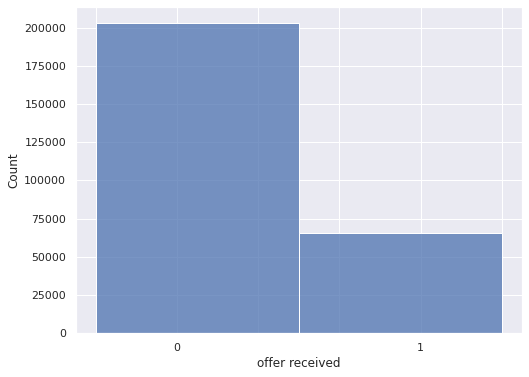

In [65]:
plt.figure(figsize=(8,6))
sns.set(style="darkgrid")
g = sns.histplot(data=complete_df, x="offer received", bins=2)
g.set_xticklabels(['','','0', '','','1',''])
plt.savefig('02-complete_df-offer received.png')

In [66]:
offer_received = complete_df[complete_df['offer received'] == 1].customer_id.count()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  after removing the cwd from sys.path.


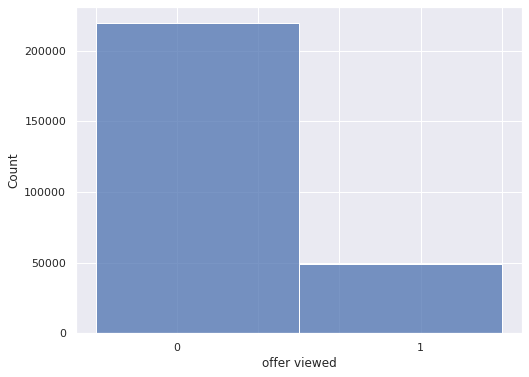

In [67]:
plt.figure(figsize=(8,6))
sns.set(style="darkgrid")
g = sns.histplot(data=complete_df, x="offer viewed", bins=2)
g.set_xticklabels(['','','0', '','','1',''])
plt.savefig('02-complete_df-offer viewed.png')

In [68]:
offer_viewed = complete_df[complete_df['offer viewed'] == 1].customer_id.count()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  after removing the cwd from sys.path.


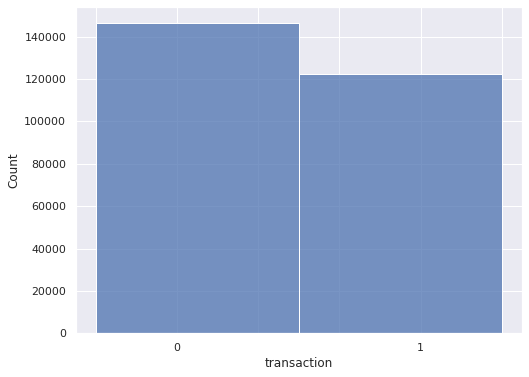

In [69]:
plt.figure(figsize=(8,6))
sns.set(style="darkgrid")
g = sns.histplot(data=complete_df, x="transaction", bins=2)
g.set_xticklabels(['','','0', '','','1',''])
plt.savefig('02-complete_df-transaction.png')

In [70]:
transaction = complete_df[complete_df['transaction'] == 1].customer_id.count()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  after removing the cwd from sys.path.


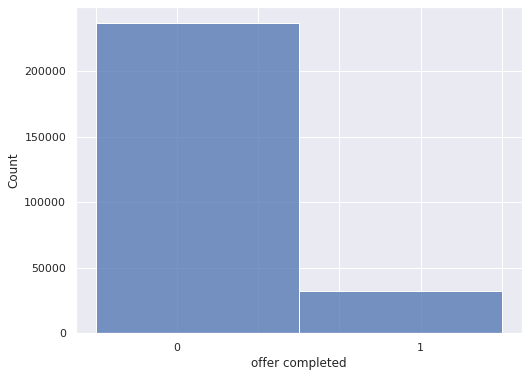

In [71]:
plt.figure(figsize=(8,6))
sns.set(style="darkgrid")
g = sns.histplot(data=complete_df, x="offer completed", bins=2)
g.set_xticklabels(['','','0', '','','1',''])
plt.savefig('02-complete_df-offer completed.png')

In [72]:
offer_completed = complete_df[complete_df['offer completed'] == 1].customer_id.count()

In [73]:
print(f'{offer_received} customers received an offers, of which {offer_viewed} viewed it.')
print(f'The offers completed are {offer_completed}, but the number of total transactions were {transaction}.')

65585 customers received an offers, of which 49087 viewed it.
The offers completed are 31943, but the number of total transactions were 122176.


Let's check out how the offer system is organized in the DataFrame.
It is important to understand how the offer events (received, viewed, transaction, completed) are recorded in the
DataFrame, so to better constrain the offers that were completed because the customer behavor was influenced by them.

In [74]:
complete_df = complete_df.sort_values(by=['customer_id', 'time_hours']).reset_index(drop=True)

In [75]:
complete_df.head(10)

,customer_id,offer_id,offer received,offer viewed,transaction,offer completed,time_hours,duration,difficulty,amount,...,member_>1000 days,gender-F,gender-M,age_20_40,age_40_60,age_>60,income_<30k,income_30k-60k,income_60k-90k,income_>90k
0,0009655768c64bdeb2e877511632db8f,1,1,0,0,0,168,72,0,NaN,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0009655768c64bdeb2e877511632db8f,1,0,1,0,0,192,72,0,NaN,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0009655768c64bdeb2e877511632db8f,1,0,0,1,0,228,72,0,22.16,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0009655768c64bdeb2e877511632db8f,2,1,0,0,0,336,96,0,NaN,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0009655768c64bdeb2e877511632db8f,2,0,1,0,0,372,96,0,NaN,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0009655768c64bdeb2e877511632db8f,3,1,0,0,0,408,120,5,NaN,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
6,0009655768c64bdeb2e877511632db8f,3,0,0,1,0,414,120,5,8.57,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7,0009655768c64bdeb2e877511632db8f,3,0,0,0,1,414,120,5,NaN,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
8,0009655768c64bdeb2e877511632db8f,3,0,1,0,0,456,120,5,NaN,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
9,0009655768c64bdeb2e877511632db8f,4,1,0,0,0,504,240,10,NaN,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [76]:
complete_df.columns

Index(['customer_id', 'offer_id', 'offer received', 'offer viewed',
       'transaction', 'offer completed', 'time_hours', 'duration',
       'difficulty', 'amount', 'reward', 'channel-email', 'channel-mobile',
       'channel-social', 'channel-web', 'offer_type-bogo',
       'offer_type-discount', 'offer_type-informational', 'became_member_on',
       'member_<180 days', 'member_180-600 days', 'member_600-1000 days',
       'member_>1000 days', 'gender-F', 'gender-M', 'age_20_40', 'age_40_60',
       'age_>60', 'income_<30k', 'income_30k-60k', 'income_60k-90k',
       'income_>90k'],
      dtype='object')

## Observation

The total transactions outnumbers the offers completed, meaning that:
   - some customers liked the offer system. In this case, the offers can be considered successful in keeping a customer loyal to the company.
   - some customers like the products and they would continue making purchases without being influenced by the offers received.
    
To fully understand how successful the offers project is, some **deeper data analysis is necessary** .

## Succesful criterium

Let's first define a successful criterium to evaluate the offers project performance.  
We need to build up a 'successful_score' column that can tell if an offer was successful ('successful_score' = 1) or not ('successful_score' = 0 or 2).

For an offer to be successful, a user needs to:  

**BOGO and Discount** 
   - Receive an offer.
   - View the offer.
   - Make a transaction.
   - Complete the offer.
    
**Informational** 
   - Receive an offer.
   - View the offer.
   - Make a transaction.
   - Validity period is respected.
   
The above steps must be completed **sequentially**. In this case, the 'successful_score' column will have **value 1**.

There are many cases where the customers completed an offer, but they were not influenced by it.
This happens when a costumer:

   - makes a transaction (no offer received).
   - Receives an offer, but it doesn't see it. Then it makes a transaction that matches the offer criteria.
     This group also includes customers that:
      - view the offer **after** having completed an offer by a transaction.
      - receive and possibly view the offer **after** having completed an offer by a transaction.
      - complete a transaction that matches the informational offer criteria, **after** the validity time expired.
      
These type of customers are already loyal to the company, they clearly like the products besides receiving an offer or not. It is likely that they will continue making purchases on the app in the future. Therefore, the company has a low interest in sending offers to them.
Even though this case is part of the unsuccessful offer group, I will mark them with a **'successful_score' = 2** because it is interesting to understand which kind of customers they are.
      
Finally, an offer was not successful if the offer has been viewed but no transaction followed, or if it was received but to further actions followed. The 'successful_score' column will have **value 0**.

## Summary of customer types

Based on the successful score, the customers are split in three categories:

   - score = 0: The offer was not successful.
   - score = 1: The offer has been successfully completed.
   - score = 2: The offer has been completed, but the customer were not influence by it.

### BOGO, discount, and informational

Because the informational dataframe has a different succesful definition than the other two offers, I will first split the complete_df DataFrame in two smaller DataFrames.

In [77]:
# BOGO and Discount

bogo_discount_df = complete_df[(complete_df['offer_type-bogo'] == 1) | (complete_df['offer_type-discount'] == 1)]

In [78]:
bogo_discount_df = bogo_discount_df.reset_index(drop=True)

In [79]:
bogo_discount_df.head(10)

,customer_id,offer_id,offer received,offer viewed,transaction,offer completed,time_hours,duration,difficulty,amount,...,member_>1000 days,gender-F,gender-M,age_20_40,age_40_60,age_>60,income_<30k,income_30k-60k,income_60k-90k,income_>90k
0,0009655768c64bdeb2e877511632db8f,3,1,0,0,0,408,120,5,NaN,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0009655768c64bdeb2e877511632db8f,3,0,0,1,0,414,120,5,8.57,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0009655768c64bdeb2e877511632db8f,3,0,0,0,1,414,120,5,NaN,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0009655768c64bdeb2e877511632db8f,3,0,1,0,0,456,120,5,NaN,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0009655768c64bdeb2e877511632db8f,4,1,0,0,0,504,240,10,NaN,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0009655768c64bdeb2e877511632db8f,4,0,0,1,0,528,240,10,14.11,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
6,0009655768c64bdeb2e877511632db8f,4,0,0,0,1,528,240,10,NaN,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7,0009655768c64bdeb2e877511632db8f,4,0,1,0,0,540,240,10,NaN,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
8,0009655768c64bdeb2e877511632db8f,11,0,0,1,0,552,240,10,13.56,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
9,0009655768c64bdeb2e877511632db8f,5,1,0,0,0,576,168,10,NaN,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [80]:
bogo_discount_df.describe()

,offer_id,offer received,offer viewed,transaction,offer completed,time_hours,duration,difficulty,amount,reward,...,member_>1000 days,gender-F,gender-M,age_20_40,age_40_60,age_>60,income_<30k,income_30k-60k,income_60k-90k,income_>90k
count,227770.000000,227770.000000,227770.000000,227770.000000,227770.000000,227770.000000,227770.000000,227770.000000,103459.000000,227770.000000,...,227770.000000,227770.000000,227770.000000,227770.000000,227770.000000,227770.000000,227770.000000,227770.000000,227770.000000,227770.000000
mean,7.711999,0.230408,0.175124,0.454226,0.140242,368.332010,173.438328,9.331830,14.009581,5.243842,...,0.206717,0.421886,0.578114,0.239312,0.395403,0.365285,0.005738,0.462335,0.395684,0.136243
std,2.850003,0.421095,0.380074,0.497901,0.347239,200.614419,43.023417,4.051137,32.534930,3.065493,...,0.404952,0.493862,0.493862,0.426664,0.488938,0.481511,0.075534,0.498580,0.488998,0.343047
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,120.000000,5.000000,0.050000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,0.000000,0.000000,0.000000,0.000000,192.000000,120.000000,7.000000,3.600000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8.000000,0.000000,0.000000,0.000000,0.000000,408.000000,168.000000,10.000000,10.680000,5.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,11.000000,0.000000,0.000000,1.000000,0.000000,534.000000,168.000000,10.000000,19.080000,10.000000,...,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,11.000000,1.000000,1.000000,1.000000,1.000000,714.000000,240.000000,20.000000,1015.730000,10.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [81]:
bogo_discount_df.drop('offer_type-informational', axis=1, inplace=True)

In [82]:
bogo_discount_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227770 entries, 0 to 227769
Data columns (total 31 columns):
customer_id             227770 non-null object
offer_id                227770 non-null int64
offer received          227770 non-null uint8
offer viewed            227770 non-null uint8
transaction             227770 non-null uint8
offer completed         227770 non-null uint8
time_hours              227770 non-null int64
duration                227770 non-null int64
difficulty              227770 non-null int64
amount                  103459 non-null float64
reward                  227770 non-null int64
channel-email           227770 non-null int64
channel-mobile          227770 non-null int64
channel-social          227770 non-null int64
channel-web             227770 non-null int64
offer_type-bogo         227770 non-null uint8
offer_type-discount     227770 non-null uint8
became_member_on        227770 non-null datetime64[ns]
member_<180 days        227770 non-null float64
m

In [83]:
bogo_discount_df.columns

Index(['customer_id', 'offer_id', 'offer received', 'offer viewed',
       'transaction', 'offer completed', 'time_hours', 'duration',
       'difficulty', 'amount', 'reward', 'channel-email', 'channel-mobile',
       'channel-social', 'channel-web', 'offer_type-bogo',
       'offer_type-discount', 'became_member_on', 'member_<180 days',
       'member_180-600 days', 'member_600-1000 days', 'member_>1000 days',
       'gender-F', 'gender-M', 'age_20_40', 'age_40_60', 'age_>60',
       'income_<30k', 'income_30k-60k', 'income_60k-90k', 'income_>90k'],
      dtype='object')

In [84]:
# Informationale

informational_df = complete_df[(complete_df['offer_type-informational'] == 1)]

In [85]:
informational_df = informational_df.reset_index(drop=True)
informational_df.head(20)

,customer_id,offer_id,offer received,offer viewed,transaction,offer completed,time_hours,duration,difficulty,amount,...,member_>1000 days,gender-F,gender-M,age_20_40,age_40_60,age_>60,income_<30k,income_30k-60k,income_60k-90k,income_>90k
0,0009655768c64bdeb2e877511632db8f,1,1,0,0,0,168,72,0,NaN,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0009655768c64bdeb2e877511632db8f,1,0,1,0,0,192,72,0,NaN,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0009655768c64bdeb2e877511632db8f,1,0,0,1,0,228,72,0,22.16,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0009655768c64bdeb2e877511632db8f,2,1,0,0,0,336,96,0,NaN,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0009655768c64bdeb2e877511632db8f,2,0,1,0,0,372,96,0,NaN,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0020c2b971eb4e9188eac86d93036a77,1,1,0,0,0,504,72,0,NaN,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
6,0020c2b971eb4e9188eac86d93036a77,1,0,0,1,0,510,72,0,17.24,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
7,0020c2b971eb4e9188eac86d93036a77,1,0,1,0,0,660,72,0,NaN,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
8,0020c2b971eb4e9188eac86d93036a77,11,0,0,1,0,696,72,0,27.94,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
9,0020c2b971eb4e9188eac86d93036a77,11,0,0,1,0,708,72,0,19.49,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [86]:
informational_df['offer_id'].describe()

count    41021.000000
mean         3.620073
std          4.018023
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         11.000000
Name: offer_id, dtype: float64

In [87]:
informational_df.drop(['offer completed', 
                       'difficulty', 
                       'offer_type-bogo', 
                       'offer_type-discount'], axis=1, inplace=True)

In [88]:
informational_df.head(30)

,customer_id,offer_id,offer received,offer viewed,transaction,time_hours,duration,amount,reward,channel-email,...,member_>1000 days,gender-F,gender-M,age_20_40,age_40_60,age_>60,income_<30k,income_30k-60k,income_60k-90k,income_>90k
0,0009655768c64bdeb2e877511632db8f,1,1,0,0,168,72,NaN,0,1,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0009655768c64bdeb2e877511632db8f,1,0,1,0,192,72,NaN,0,1,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0009655768c64bdeb2e877511632db8f,1,0,0,1,228,72,22.16,0,1,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0009655768c64bdeb2e877511632db8f,2,1,0,0,336,96,NaN,0,1,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0009655768c64bdeb2e877511632db8f,2,0,1,0,372,96,NaN,0,1,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0020c2b971eb4e9188eac86d93036a77,1,1,0,0,504,72,NaN,0,1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
6,0020c2b971eb4e9188eac86d93036a77,1,0,0,1,510,72,17.24,0,1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
7,0020c2b971eb4e9188eac86d93036a77,1,0,1,0,660,72,NaN,0,1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
8,0020c2b971eb4e9188eac86d93036a77,11,0,0,1,696,72,27.94,0,1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
9,0020c2b971eb4e9188eac86d93036a77,11,0,0,1,708,72,19.49,0,1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [89]:
def func(x):
    result = {"diff": x['time_hours'].iloc[-1] - x['time_hours'].iloc[0], 'orig_index':x.index[x['time_hours'] == x['time_hours'].iloc[-1]][0]}
    return pd.Series(result, name="index")


def transaction_time(df):
    
    """
    For the informational offers, it is important to understand if a transaction has been executed 
    before the offers expires.
    
    This function calculates the time a customer needed to complete an offer
    """
    
    # Create a new column to accoun for the duration of the total number of actions executed by a user
    df['transaction_time'] = np.nan
    
    # Calculate the difference in time between the end and the start of an action
    # Methodology inspired by https://datascience.stackexchange.com/questions/41428/how-to-find-the-count-of-consecutive-same-string-values-in-a-pandas-dataframe
    df['subgroup'] = ((df['offer_id'] != df['offer_id'].shift(1)) | \
                  (df['customer_id'] != df['customer_id'].shift(1)) | \
                  (df['offer received'] == 1)).cumsum()
    
    result = df.groupby('subgroup',as_index=False).apply(func)
    
    for i in range(result.shape[0]):
        df.at[result.orig_index[i], 'transaction_time'] = result['diff'][i]
        
    # If a transaction has a offer_id = 11 (not associated with an offer), set the time difference back to np.nan
    df.loc[df.offer_id == 11, 'transaction_time'] = np.nan
    
    # Calculate the difference between the offer validity time, and the transaction time...
    df['offer_validity_delta_t'] = df['duration'] - df['transaction_time']
    
    # ... and move it in another position
    col = df.pop("offer_validity_delta_t")
    df.insert(5, "offer_validity_delta_t", col)
    
    # If a transaction has a offer_id = 11 (not associated with an offer), set the offer_validity_delta_t to 0
    df.loc[df.offer_id == 11, 'offer_validity_delta_t'] = 0
    
    # drop the columns that are not needed anymore
    df.drop(['subgroup', 'transaction_time'], axis=1, inplace=True)
    
    return df

informational_df = transaction_time(informational_df)

/opt/conda/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4317: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stacked_values = np.vstack(map(np.asarray, values))


In [90]:
informational_df.tail(20)

,customer_id,offer_id,offer received,offer viewed,transaction,offer_validity_delta_t,time_hours,duration,amount,reward,...,member_>1000 days,gender-F,gender-M,age_20_40,age_40_60,age_>60,income_<30k,income_30k-60k,income_60k-90k,income_>90k
41001,fff0f0aac6c547b9b263080f09a5586a,2,1,0,0,NaN,168,96,NaN,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
41002,fff0f0aac6c547b9b263080f09a5586a,2,0,1,0,NaN,288,96,NaN,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
41003,fff0f0aac6c547b9b263080f09a5586a,2,0,0,1,-54.0,318,96,18.88,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
41004,fff0f0aac6c547b9b263080f09a5586a,2,1,0,0,NaN,576,96,NaN,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
41005,fff0f0aac6c547b9b263080f09a5586a,2,0,0,1,NaN,606,96,30.40,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
41006,fff0f0aac6c547b9b263080f09a5586a,2,0,1,0,36.0,636,96,NaN,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
41007,fff0f0aac6c547b9b263080f09a5586a,11,0,0,1,0.0,660,96,17.10,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
41008,fff3ba4757bd42088c044ca26d73817a,1,1,0,0,72.0,336,72,NaN,0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
41009,fff3ba4757bd42088c044ca26d73817a,1,1,0,0,NaN,504,72,NaN,0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
41010,fff3ba4757bd42088c044ca26d73817a,1,0,0,1,NaN,528,72,17.83,0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


## Definition of successful_score


In [91]:
def successful_score(df, offer_type):
    
    """
    This function takes the complete_df DataFrame as input and it calculates the successful_score.
    
    """
    df['successful_score'] = 2
    
    if offer_type == 'bogo_discount':
    
        # successful_score = 1

        temp = ((df['offer received'].shift(periods=3) == 1) & \
            (df['offer viewed'].shift(periods=2) == 1) & \
            (df['transaction'].shift(periods=1) == 1) & \
            (df['offer completed'] == 1) & \
            (df['offer_id'] == df['offer_id'].shift(periods=3)))

        pos = np.where(temp == True)
        for i in range(1,4):
            temp.iloc[pos[0]-i] = True
        
    else:
        temp = ((df['offer_id'] == df['offer_id'].shift(periods=2)) & \
                (df['offer received'].shift(periods=2) == 1) & \
                (df['offer viewed'].shift(periods=1) == 1) & \
                (df['transaction'] == 1) & \
                (df['offer_validity_delta_t'] >= 0)) 
        
        pos = np.where(temp == True)
        for i in range(1,3):
            temp.iloc[pos[0]-i] = True
        
    df.loc[temp == True, 'successful_score'] = 1

    # successful_score = 0
    # Either an offer has been viewed but no transaction followed 

    temp = ((df['offer received'] == 1) & \
        (df['offer viewed'].shift(periods=-1) == 1) & \
        (df['transaction'].shift(periods=-2) == 0) & \
        (df['offer_id'].shift(periods=1) == df['offer_id'].shift(periods=2)))

    pos = np.where(temp == True)
    temp.iloc[pos[0]+1] = True

    df.loc[temp == True, 'successful_score'] = 0

    # or if it was received but to further actions followed

    temp = ((df['offer received'].shift(periods=-1) == 1) & \
        (df['offer received'] == 1) & 
        (df['offer_id'].shift(periods=-1) != df['offer_id']))

    df.loc[temp == True, 'successful_score'] = 0
        
    col = df.pop("successful_score")
    df.insert(2, "successful_score", col)
        
    return df


bd_successul_offers_df = successful_score(bogo_discount_df, 'bogo_discount')
i_successul_offers_df = successful_score(informational_df, 'informational')

Now that the successful score has been calculated, I can eliminate the rows that repeats the same information. Indeed, now it in not necessary to know if an offer has been received or completed, since this information is already summarized in the successful_score column.

For the BOGO & discount dataframe, I will group by dataframe by customer_id, offer_id, and successful_score, and keep only the first line of each group. This method, though, would group the id_offer = 11 into one group, and take only one if multiple offers of this type exist for a user. This offer_id must be copied in the new data frame, and eliminated from the bd_successul_offers_df, before applying the groupby.

For the informational dataframe, the rows will be seected base on the offer_validity_delta_t column.

In [92]:
df1 = bd_successul_offers_df[bd_successul_offers_df.offer_id == 11]
bd_successul_offers_df = bd_successul_offers_df[bd_successul_offers_df.offer_id != 11]
df2 = bd_successul_offers_df.groupby(['customer_id', 'offer_id', 'successful_score']).first().reset_index()

bd_successul_offers_df = pd.concat([df2, df1], ignore_index = True, axis = 0)

bd_successul_offers_df.sort_values(by=['customer_id','time_hours']).reset_index(drop=True).head(20)

,customer_id,offer_id,successful_score,offer received,offer viewed,transaction,offer completed,time_hours,duration,difficulty,...,member_>1000 days,gender-F,gender-M,age_20_40,age_40_60,age_>60,income_<30k,income_30k-60k,income_60k-90k,income_>90k
0,0009655768c64bdeb2e877511632db8f,3,2,1,0,0,0,408,120,5,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0009655768c64bdeb2e877511632db8f,4,2,1,0,0,0,504,240,10,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0009655768c64bdeb2e877511632db8f,11,2,0,0,1,0,552,240,10,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0009655768c64bdeb2e877511632db8f,5,2,1,0,0,0,576,168,10,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0009655768c64bdeb2e877511632db8f,11,2,0,0,1,0,660,168,10,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0009655768c64bdeb2e877511632db8f,11,2,0,0,1,0,690,168,10,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
6,0009655768c64bdeb2e877511632db8f,11,2,0,0,1,0,696,168,10,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7,0020c2b971eb4e9188eac86d93036a77,4,1,1,0,0,0,0,240,10,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
8,0020c2b971eb4e9188eac86d93036a77,11,2,0,0,1,0,66,240,10,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
9,0020c2b971eb4e9188eac86d93036a77,11,2,0,0,1,0,72,240,10,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [93]:
i_successul_offers_df = i_successul_offers_df[i_successul_offers_df.offer_validity_delta_t >=0]

In [94]:
i_successul_offers_df.head(20)

,customer_id,offer_id,successful_score,offer received,offer viewed,transaction,offer_validity_delta_t,time_hours,duration,amount,...,member_>1000 days,gender-F,gender-M,age_20_40,age_40_60,age_>60,income_<30k,income_30k-60k,income_60k-90k,income_>90k
2,0009655768c64bdeb2e877511632db8f,1,1,0,0,1,12.0,228,72,22.16,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0009655768c64bdeb2e877511632db8f,2,0,0,1,0,60.0,372,96,NaN,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
8,0020c2b971eb4e9188eac86d93036a77,11,2,0,0,1,0.0,696,72,27.94,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
9,0020c2b971eb4e9188eac86d93036a77,11,2,0,0,1,0.0,708,72,19.49,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
10,0020ccbbb6d84e358d3414a3ff76cffd,11,2,0,0,1,0.0,42,72,16.27,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
13,0020ccbbb6d84e358d3414a3ff76cffd,1,1,0,0,1,54.0,426,72,8.93,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
14,0020ccbbb6d84e358d3414a3ff76cffd,11,2,0,0,1,0.0,432,72,20.08,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
15,0020ccbbb6d84e358d3414a3ff76cffd,11,2,0,0,1,0.0,450,72,10.76,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
16,0020ccbbb6d84e358d3414a3ff76cffd,11,2,0,0,1,0.0,462,72,19.10,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
19,003d66b6608740288d6cc97a6903f4f0,1,1,0,0,1,6.0,66,72,0.44,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### Data frames re-combination

The two dataframes are now concatenated together to have a final succesful_offer data frame.

In [95]:
successul_offers_df = pd.concat([bd_successul_offers_df, i_successul_offers_df], ignore_index=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [96]:
successul_offers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133869 entries, 0 to 133868
Data columns (total 34 columns):
age_20_40                   133869 non-null float64
age_40_60                   133869 non-null float64
age_>60                     133869 non-null float64
amount                      114215 non-null float64
became_member_on            133869 non-null datetime64[ns]
channel-email               133869 non-null int64
channel-mobile              133869 non-null int64
channel-social              133869 non-null int64
channel-web                 133869 non-null int64
customer_id                 133869 non-null object
difficulty                  112878 non-null float64
duration                    133869 non-null int64
gender-F                    133869 non-null float64
gender-M                    133869 non-null float64
income_30k-60k              133869 non-null float64
income_60k-90k              133869 non-null float64
income_<30k                 133869 non-null float64
income_>9

In [97]:
successul_offers_df.columns

Index(['age_20_40', 'age_40_60', 'age_>60', 'amount', 'became_member_on',
       'channel-email', 'channel-mobile', 'channel-social', 'channel-web',
       'customer_id', 'difficulty', 'duration', 'gender-F', 'gender-M',
       'income_30k-60k', 'income_60k-90k', 'income_<30k', 'income_>90k',
       'member_180-600 days', 'member_600-1000 days', 'member_<180 days',
       'member_>1000 days', 'offer completed', 'offer received',
       'offer viewed', 'offer_id', 'offer_type-bogo', 'offer_type-discount',
       'offer_type-informational', 'offer_validity_delta_t', 'reward',
       'successful_score', 'time_hours', 'transaction'],
      dtype='object')

In [98]:
# successul_offers_df[['reward_x', 'reward_y']]

In [99]:
# Drop columns that are not useful for the following data analysis

successul_offers_df.drop(['became_member_on',
                          'offer received', 'offer viewed', 'transaction', 'offer completed',
                          'time_hours'], axis=1, inplace=True)

In [100]:
columns_order = ['customer_id', 'offer_id', 'successful_score',
                 'difficulty', 'duration', 'amount', 'reward',
                 'offer_type-bogo', 'offer_type-discount', 'offer_type-informational','offer_validity_delta_t',
                 'channel-email', 'channel-mobile', 'channel-social', 'channel-web', 
                 'gender-F', 'gender-M',
                 'age_20_40','age_40_60','age_>60',
                 'income_30k-60k', 'income_60k-90k','income_<30k', 'income_>90k', 
                 'member_180-600 days', 'member_600-1000 days', 'member_<180 days', 'member_>1000 days']

In [101]:
successul_offers_df = successul_offers_df[columns_order]

In [102]:
# successul_offers_df[successul_offers_df['offer_type-informational']==1]

In [103]:
successul_offers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133869 entries, 0 to 133868
Data columns (total 28 columns):
customer_id                 133869 non-null object
offer_id                    133869 non-null int64
successful_score            133869 non-null int64
difficulty                  112878 non-null float64
duration                    133869 non-null int64
amount                      114215 non-null float64
reward                      133869 non-null int64
offer_type-bogo             112878 non-null float64
offer_type-discount         112878 non-null float64
offer_type-informational    20991 non-null float64
offer_validity_delta_t      20991 non-null float64
channel-email               133869 non-null int64
channel-mobile              133869 non-null int64
channel-social              133869 non-null int64
channel-web                 133869 non-null int64
gender-F                    133869 non-null float64
gender-M                    133869 non-null float64
age_20_40               

### Save the clean DataFrame to a .csv file

In [104]:
# successul_offers_df.to_csv('successul_offers_df.csv', index=False)

### Read the .csv file

In [105]:
# successul_offers_df = pd.read_csv('successul_offers_df.csv')

# Data analysis

Main questions:
   - How many customers completed, or not, an offer?
   - How difficult were the offers, and how is difficulty related to offer success?
   - Which kind of offer was the most, and least, successful?
   - Which channel was the most, and least, effective?
   - What are the demographic characteristics of the three customer types?


**Q1:**  
How many customers completed, or not, an offer?

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


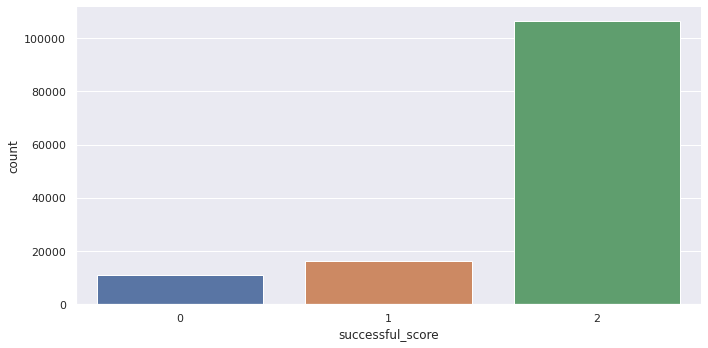

In [106]:
sns.factorplot("successful_score", data=successul_offers_df, aspect=2, kind="count")
plt.savefig('03-successful_score_counts.png')

In [107]:
total_raws = successul_offers_df.shape[0]

In [108]:
print((successul_offers_df[successul_offers_df.successful_score == 1]['successful_score'].count() / total_raws)*100)

12.148443627725612


In [109]:
print((successul_offers_df[successul_offers_df.successful_score == 0]['successful_score'].count() / total_raws)*100)

8.314845109771493


In [110]:
print((successul_offers_df[successul_offers_df.successful_score == 2]['successful_score'].count() / total_raws)*100)

79.53671126250289


***Answer:***

The majority of offers went unseen by the users, but they managed to complete them anyway. This group of user represent the 79.5% of the sample.

The successful offers were a total of 12.1%, while users that dis not complete any offer, or that there were not interested in them, are 8.3 %. Those numbers are not a surprise. We already saw before that the number of transactions marked as completed were significantly lower compared to the number of transactions.

**Q2:**  
How difficult were the offers, and how is difficulty related to offer success?

In [111]:
# sns.set(style="whitegrid")

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

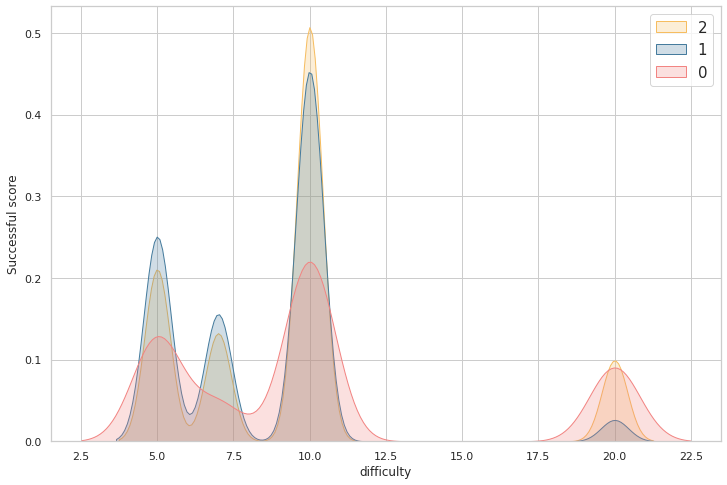

In [112]:
plt.figure(figsize=(12,8))
sns.set(style="whitegrid")

data = successul_offers_df[successul_offers_df.difficulty.notna()]
# data.info()

sns.distplot(data[data['successful_score']==2].difficulty, 
             label='2', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f6bd60',
             hist_kws={'alpha':.4})

sns.distplot(data[data['successful_score']==1].difficulty, 
             label='1', 
             hist=False,
             kde_kws={'shade':True},
            color = '#457b9d',
            hist_kws={'alpha':.4})

sns.distplot(data[data['successful_score']==0].difficulty, 
             label='0', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f28482',
             hist_kws={'alpha':.4})
plt.legend(fontsize=15)
plt.ylabel('Successful score')
plt.savefig('04-successful_score_difficulty.png')

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

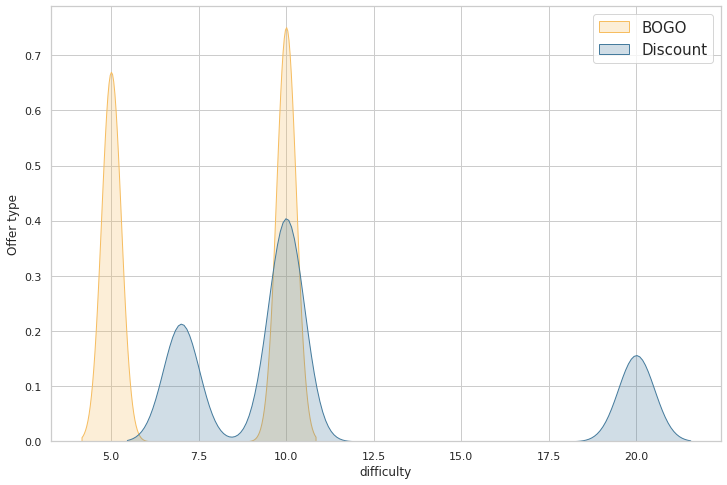

In [113]:
plt.figure(figsize=(12,8))
sns.distplot(data[data['offer_type-bogo']==1].difficulty, 
             label='BOGO', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f6bd60',
             hist_kws={'alpha':.4})

sns.distplot(data[data['offer_type-discount']==1].difficulty, 
             label='Discount', 
             hist=False,
             kde_kws={'shade':True},
            color = '#457b9d',
            hist_kws={'alpha':.4})

sns.distplot(data[data['offer_type-informational']==1].difficulty, 
             label='Informational', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f28482',
             hist_kws={'alpha':.4})
plt.ylabel('Offer type')
plt.legend(fontsize=15)
plt.savefig('04-difficulty_offer_type.png')

***Answer:***  
Offers have a difficulty between 5 and 20. The most successful offers had a difficulty of 10, followed by 5 and 7.5. The offers with a difficulty of 20 where highly unsuccessful. The success of an offer with difficulty 10 over more simple offers can be explained by the fact that this offer type also had the highest reward. 

**Q3:** 
Which kind of offer was the most, and least, successful?

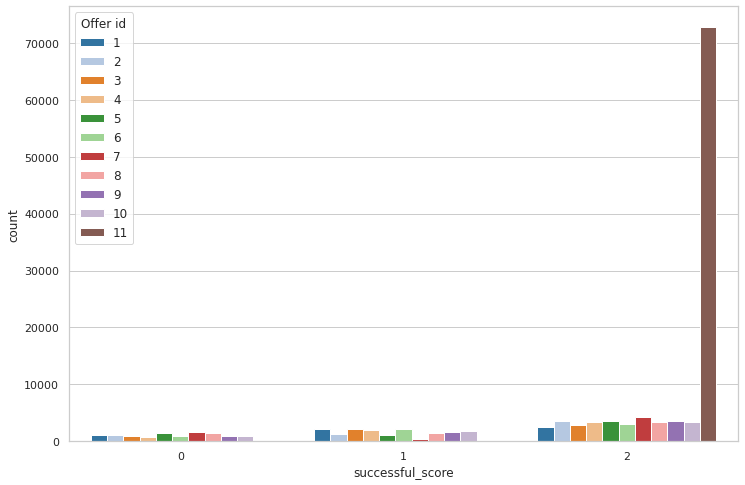

In [114]:
plt.figure(figsize=(12,8))

sns.countplot(x='successful_score', 
             hue = 'offer_id',
             data = successul_offers_df, 
             palette='tab20')

plt.legend(title='Offer id', fontsize=12)
plt.savefig('05_count_successful_score_offer_id_with11.png')

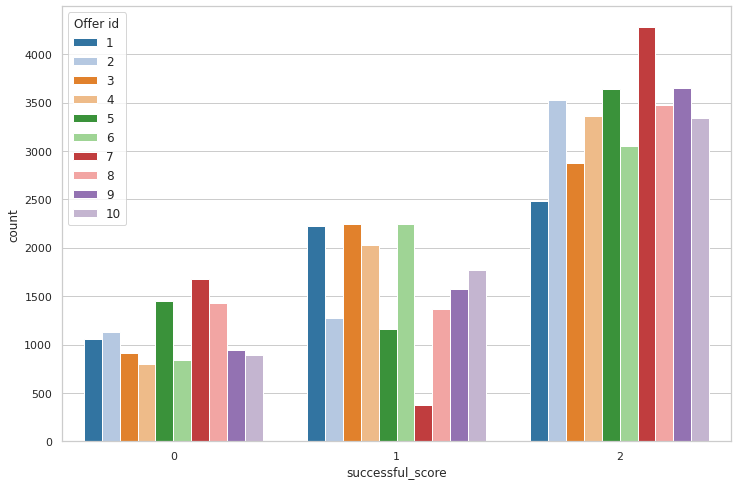

In [115]:
plt.figure(figsize=(12,8))
data = successul_offers_df[successul_offers_df.offer_id != 11]

sns.countplot(x='successful_score', 
             hue = 'offer_id',
             data = data, 
             palette='tab20')
plt.legend(title='Offer id', fontsize=12)
plt.savefig('05_count_successful_score_offer_id.png')

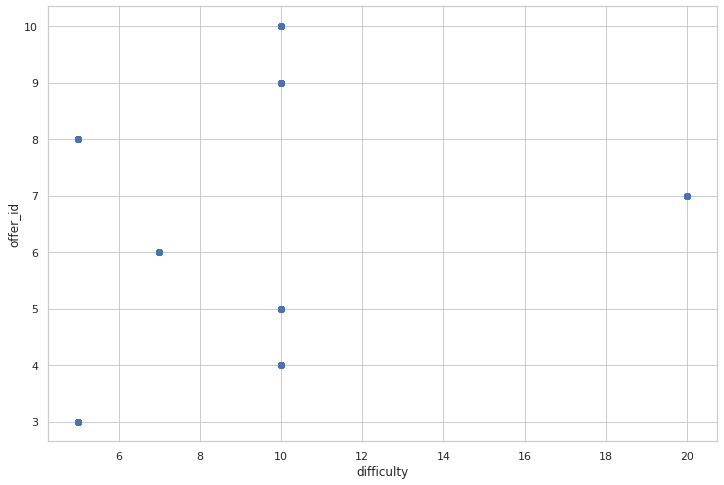

In [116]:
plt.figure(figsize=(12,8))
sns.regplot(x=data["difficulty"], y=data["offer_id"], fit_reg=False)
plt.savefig('05_count_difficulty_offer_id.png')

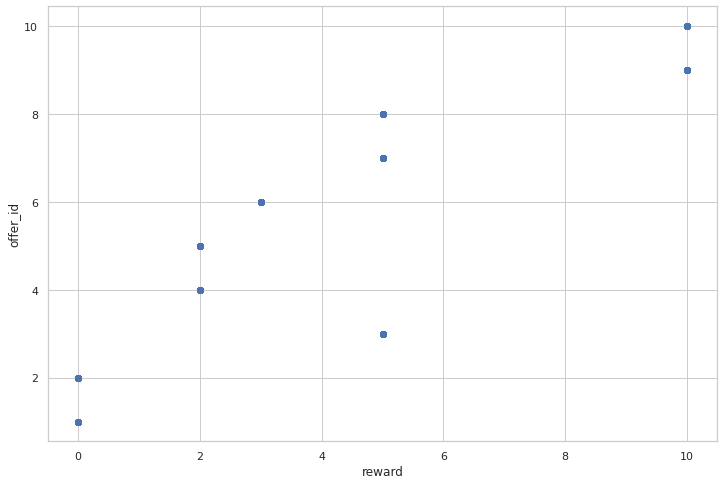

In [117]:
plt.figure(figsize=(12,8))
sns.regplot(x=data["reward"], y=data["offer_id"], fit_reg=False)
plt.savefig('05_count_reward_offer_id.png')

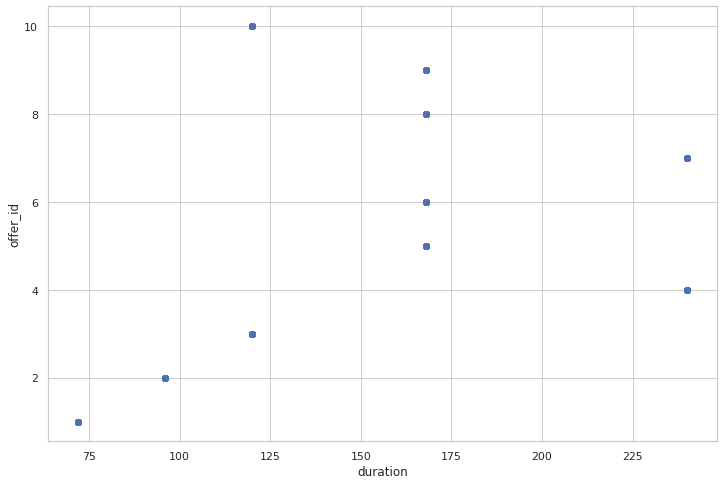

In [118]:
plt.figure(figsize=(12,8))
sns.regplot(x=data["duration"], y=data["offer_id"], fit_reg=False)
plt.savefig('05_count_duration_offer_id.png')

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

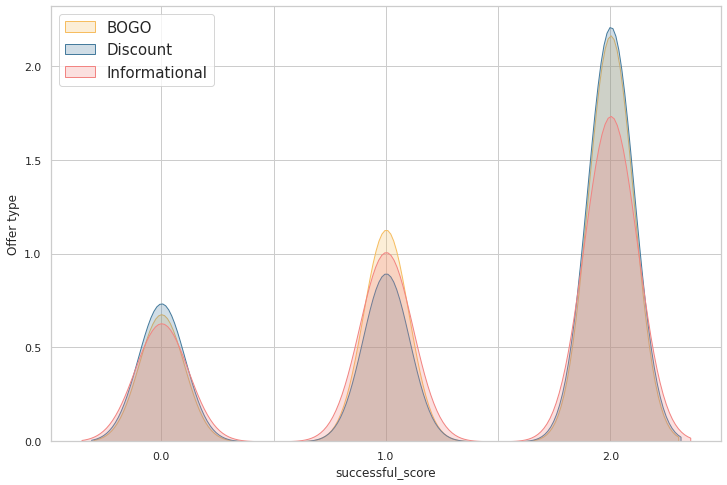

In [119]:
plt.figure(figsize=(12,8))
g = sns.distplot(data[data['offer_type-bogo']==1].successful_score, 
             label='BOGO', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f6bd60',
             hist_kws={'alpha':.4})

g = sns.distplot(data[data['offer_type-discount']==1].successful_score, 
             label='Discount', 
             hist=False,
             kde_kws={'shade':True},
             color = '#457b9d',
            hist_kws={'alpha':.4})

g = sns.distplot(data[data['offer_type-informational']==1].successful_score, 
             label='Informational', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f28482',
             hist_kws={'alpha':.4})
plt.ylabel('Offer type')
plt.legend(fontsize=15, loc=2)

g.set_xticklabels(['','0.0','', '1.0','','2.0'])

plt.savefig('05-successful_score_offer_type.png')

In [120]:
data.groupby('offer_id').sum()

,successful_score,difficulty,duration,amount,reward,offer_type-bogo,offer_type-discount,offer_type-informational,offer_validity_delta_t,channel-email,...,age_40_60,age_>60,income_30k-60k,income_60k-90k,income_<30k,income_>90k,member_180-600 days,member_600-1000 days,member_<180 days,member_>1000 days
offer_id,,,,,,,,,,,,,,,,,,,,,
1,7195,0.0,414864,35756.45,0,0.0,0.0,5762.0,261300.0,5762,...,2324.0,2127.0,2704.0,2210.0,29.0,819.0,2700.0,1339.0,689.0,1034.0
2,8336,0.0,569856,41666.88,0,0.0,0.0,5936.0,405138.0,5936,...,2392.0,2198.0,2655.0,2383.0,42.0,856.0,2767.0,1355.0,744.0,1070.0
3,7994,30160.0,723840,71697.94,30160,6032.0,0.0,0.0,0.0,6032,...,2423.0,2304.0,2645.0,2416.0,40.0,931.0,2922.0,1330.0,788.0,992.0
4,8746,61880.0,1485120,73231.58,12376,0.0,6188.0,0.0,0.0,6188,...,2460.0,2386.0,2674.0,2555.0,32.0,927.0,2914.0,1353.0,866.0,1055.0
5,8447,62490.0,1049832,66036.88,12498,0.0,6249.0,0.0,0.0,6249,...,2547.0,2308.0,2711.0,2520.0,32.0,986.0,2921.0,1418.0,824.0,1086.0
6,8351,42994.0,1031856,70099.06,18426,0.0,6142.0,0.0,0.0,6142,...,2413.0,2350.0,2710.0,2479.0,29.0,924.0,2990.0,1339.0,813.0,1000.0
7,8935,126680.0,1520160,62800.05,31670,0.0,6334.0,0.0,0.0,6334,...,2618.0,2345.0,2730.0,2588.0,36.0,980.0,2965.0,1468.0,803.0,1098.0
8,8328,31390.0,1054704,61232.66,31390,6278.0,0.0,0.0,0.0,6278,...,2562.0,2342.0,2787.0,2478.0,43.0,970.0,2963.0,1403.0,799.0,1113.0
9,8877,61680.0,1036224,74534.10,61680,6168.0,0.0,0.0,0.0,6168,...,2523.0,2311.0,2637.0,2497.0,36.0,998.0,2908.0,1404.0,802.0,1054.0


***Answer:***  
The most successful offers have offer id 1 (informational), 3 (BOGO), 4, and 6 (Discount). The most unsuccessful has offer id 7 (discount), which is also the most difficult, with a medium reward and a long duration. Likely users felt it was the least convenient offer.

**Q:** 
Which channel was the most, and least, effective?

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

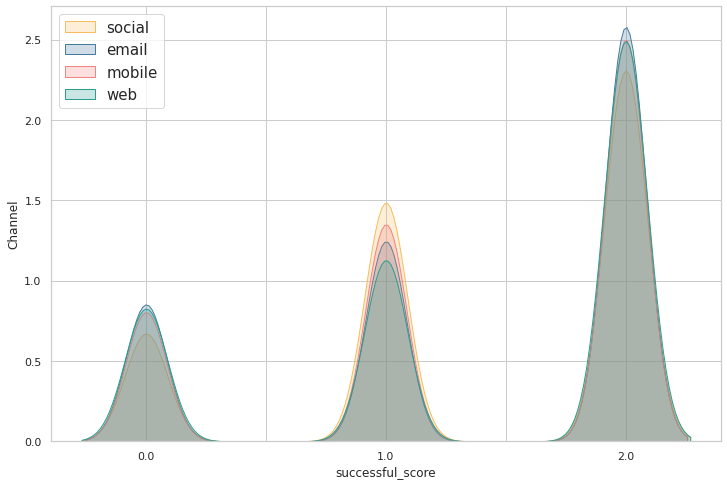

In [121]:
plt.figure(figsize=(12,8))
g = sns.distplot(data[data['channel-social']==1].successful_score, 
             label='social', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f6bd60',
             hist_kws={'alpha':.4})

g = sns.distplot(data[data['channel-email']==1].successful_score, 
             label='email', 
             hist=False,
             kde_kws={'shade':True},
             color = '#457b9d',
            hist_kws={'alpha':.4})

g = sns.distplot(data[data['channel-mobile']==1].successful_score, 
             label='mobile', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f28482',
             hist_kws={'alpha':.4})

g = sns.distplot(data[data['channel-web']==1].successful_score, 
             label='web', 
             hist=False,
             kde_kws={'shade':True},
             color = '#2a9d8f',
             hist_kws={'alpha':.4})
g.set_xticklabels(['','0.0','', '1.0','','2.0'])
plt.ylabel('Channel')
plt.legend(fontsize=15, loc=2)
plt.savefig('successful_score_Channel.png')

***Answer:*** 
A clear predominance of one communication channel over the others is not observed. The channel social is slightly more efficient, while the web looks to be the least effective.

**Q:** 
What are the demographic characteristics of the three customer types?

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


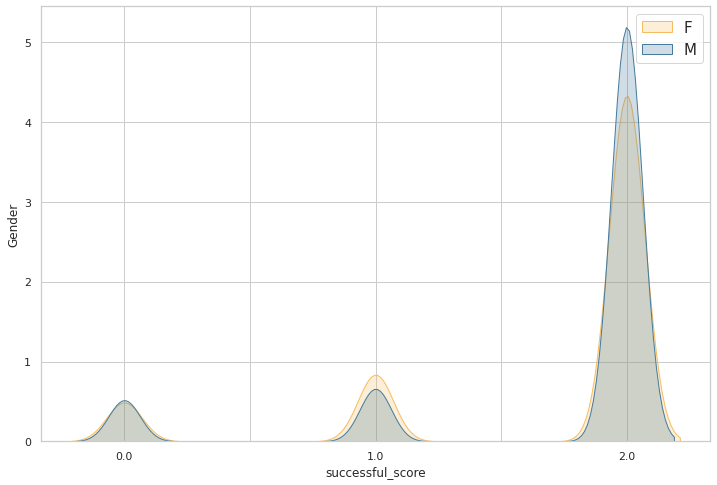

In [122]:
plt.figure(figsize=(12,8))
g = sns.distplot(successul_offers_df[successul_offers_df['gender-F']==1].successful_score, 
             label='F', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f6bd60',
             hist_kws={'alpha':.4})

g = sns.distplot(successul_offers_df[successul_offers_df['gender-M']==1].successful_score, 
             label='M', 
             hist=False,
             kde_kws={'shade':True},
             color = '#457b9d',
            hist_kws={'alpha':.4})
g.set_xticklabels(['','0.0','', '1.0','','2.0'])
plt.ylabel('Gender')
plt.legend(fontsize=15)
plt.savefig('06-successful_score_gender_with_11.png')

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


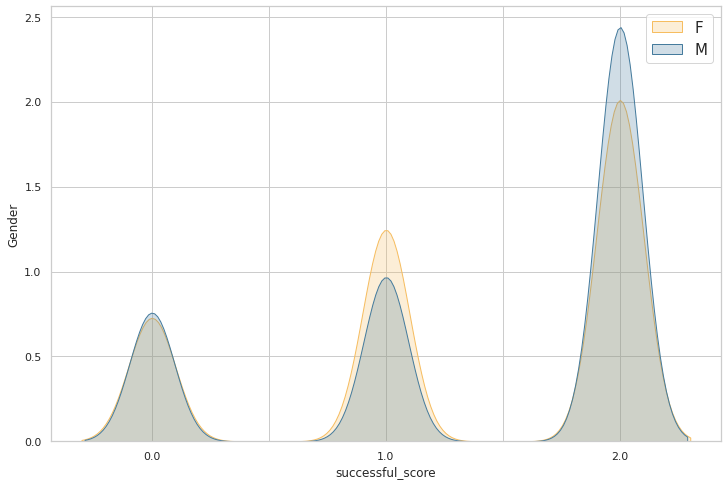

In [123]:
plt.figure(figsize=(12,8))
g = sns.distplot(data[data['gender-F']==1].successful_score, 
             label='F', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f6bd60',
             hist_kws={'alpha':.4})

g = sns.distplot(data[data['gender-M']==1].successful_score, 
             label='M', 
             hist=False,
             kde_kws={'shade':True},
             color = '#457b9d',
            hist_kws={'alpha':.4})
g.set_xticklabels(['','0.0','', '1.0','','2.0'])
plt.ylabel('Gender')
plt.legend(fontsize=15)
plt.savefig('06-successful_score_gender.png')

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

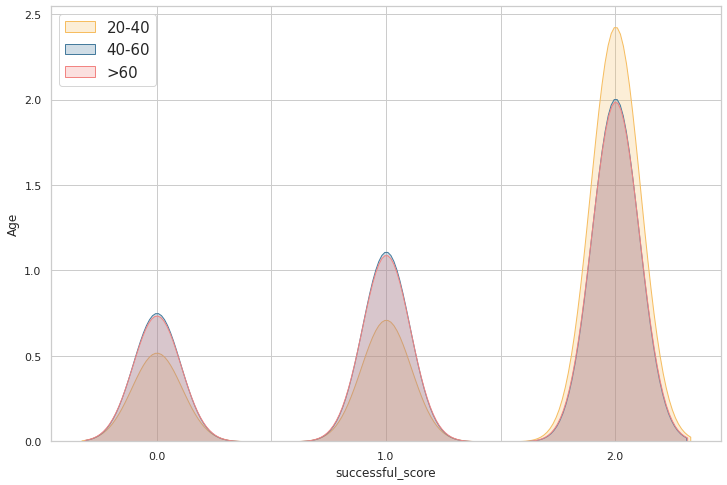

In [124]:
plt.figure(figsize=(12,8))
sns.set(style="whitegrid")
g = sns.distplot(data[data['age_20_40']==1].successful_score, 
             label='20-40', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f6bd60',
             hist_kws={'alpha':.4})

g = sns.distplot(data[data['age_40_60']==1].successful_score, 
             label='40-60', 
             hist=False,
             kde_kws={'shade':True},
             color = '#457b9d',
            hist_kws={'alpha':.4})
g = sns.distplot(data[data['age_>60']==1].successful_score, 
             label='>60', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f28482',
            hist_kws={'alpha':.4})
g.set_xticklabels(['','0.0','', '1.0','','2.0'])
plt.ylabel('Age')
plt.legend(loc=2, fontsize=15)
plt.savefig('06-successful_score_age.png')

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

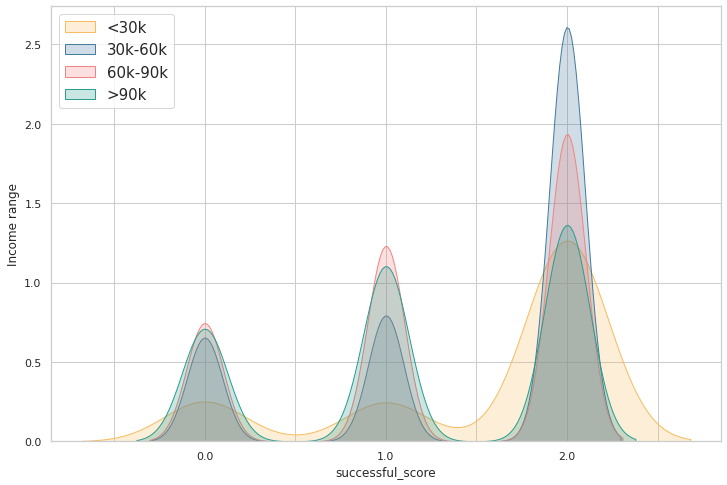

In [125]:
plt.figure(figsize=(12,8))
sns.set(style="whitegrid")
g = sns.distplot(data[data['income_<30k']==1].successful_score, 
             label='<30k', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f6bd60',
             hist_kws={'alpha':.4})

g = sns.distplot(data[data['income_30k-60k']==1].successful_score, 
             label='30k-60k', 
             hist=False,
             kde_kws={'shade':True},
             color = '#457b9d',
            hist_kws={'alpha':.4})
g = sns.distplot(data[data['income_60k-90k']==1].successful_score, 
             label='60k-90k', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f28482',
            hist_kws={'alpha':.4})
g = sns.distplot(data[data['income_>90k']==1].successful_score, 
             label='>90k', 
             hist=False,
             kde_kws={'shade':True},
             color = '#2a9d8f',
            hist_kws={'alpha':.4})
g.set_xticklabels(['','','0.0','', '1.0','','2.0'])
plt.ylabel('Income range')
plt.legend(loc=2, fontsize=15)
plt.savefig('06-successful_score_income.png')

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

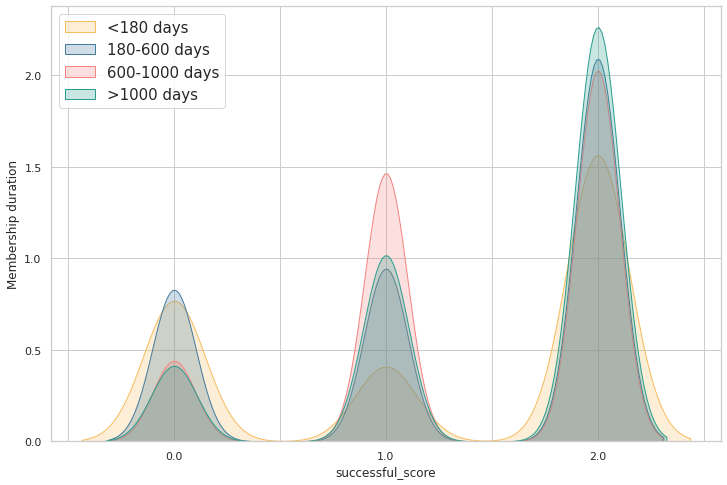

In [126]:
plt.figure(figsize=(12,8))
sns.set(style="whitegrid")
g = sns.distplot(data[data['member_<180 days']==1].successful_score, 
             label='<180 days', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f6bd60',
             hist_kws={'alpha':.4})

g = sns.distplot(data[data['member_180-600 days']==1].successful_score, 
             label='180-600 days', 
             hist=False,
             kde_kws={'shade':True},
             color = '#457b9d',
            hist_kws={'alpha':.4})
g = sns.distplot(data[data['member_600-1000 days']==1].successful_score, 
             label='600-1000 days', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f28482',
            hist_kws={'alpha':.4})
g = sns.distplot(data[data['member_>1000 days']==1].successful_score, 
             label='>1000 days', 
             hist=False,
             kde_kws={'shade':True},
             color = '#2a9d8f',
            hist_kws={'alpha':.4})
g.set_xticklabels(['','','0.0','', '1.0','','2.0'])
plt.ylabel('Membership duration')
plt.legend(loc=2, fontsize=15)
plt.savefig('06-successful_score_membership.png')

### Successful score 1 & 2

The majority of offer events are marked with successful_score = 2. To have a better sense of the difference between a successful and unsuccessful offer, I will subset the data frame to have a successful_score = 1 or 0.

In [127]:
sc01 = data[data.successful_score != 2]

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

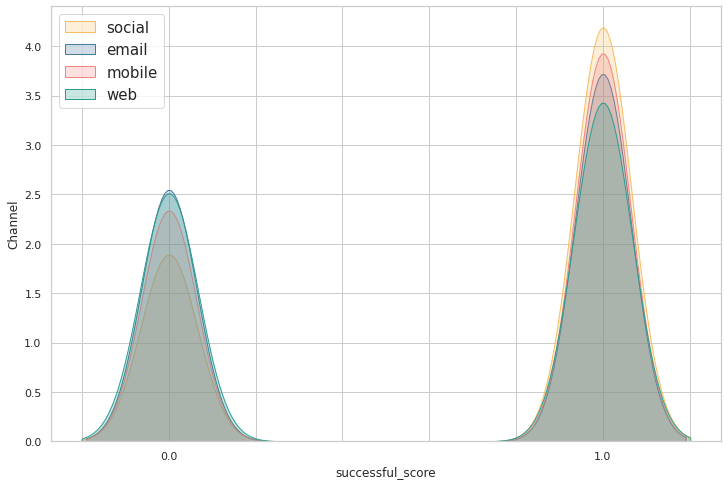

In [128]:
plt.figure(figsize=(12,8))
g = sns.distplot(sc01[sc01['channel-social']==1].successful_score, 
             label='social', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f6bd60',
             hist_kws={'alpha':.4})

g = sns.distplot(sc01[sc01['channel-email']==1].successful_score, 
             label='email', 
             hist=False,
             kde_kws={'shade':True},
             color = '#457b9d',
            hist_kws={'alpha':.4})

g = sns.distplot(sc01[sc01['channel-mobile']==1].successful_score, 
             label='mobile', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f28482',
             hist_kws={'alpha':.4})

g = sns.distplot(sc01[sc01['channel-web']==1].successful_score, 
             label='web', 
             hist=False,
             kde_kws={'shade':True},
             color = '#2a9d8f',
             hist_kws={'alpha':.4})
g.set_xticklabels(['','','0.0','', ' ','','','1.0'])
plt.ylabel('Channel')
plt.legend(fontsize=15, loc=2)
plt.savefig('sc01-successful_score_Channel.png')

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


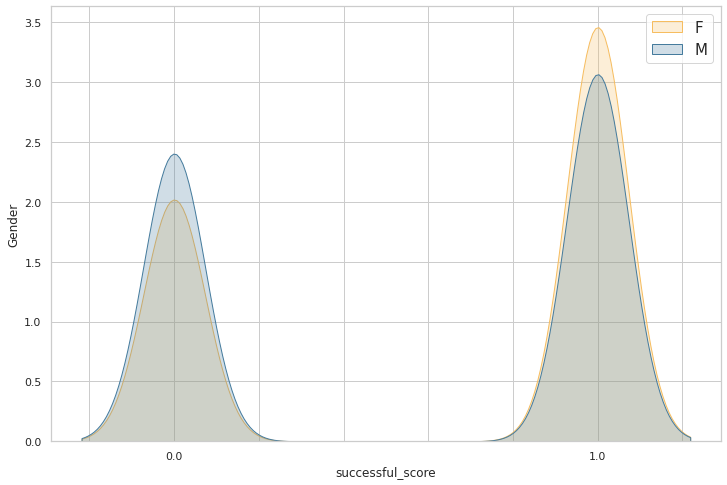

In [129]:
plt.figure(figsize=(12,8))
g = sns.distplot(sc01[sc01['gender-F']==1].successful_score, 
             label='F', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f6bd60',
             hist_kws={'alpha':.4})

g = sns.distplot(sc01[sc01['gender-M']==1].successful_score, 
             label='M', 
             hist=False,
             kde_kws={'shade':True},
             color = '#457b9d',
            hist_kws={'alpha':.4})
g.set_xticklabels(['','','0.0','', ' ','','','1.0'])
plt.ylabel('Gender')
plt.legend(fontsize=15)
plt.savefig('06-sc01-successful_score_gender.png')

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

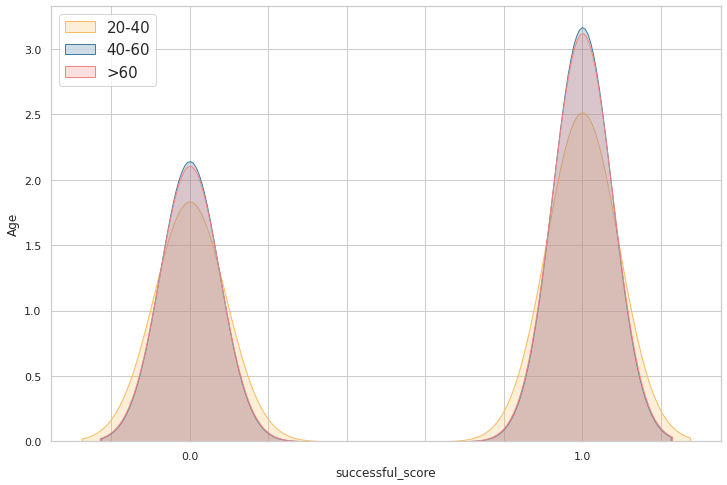

In [130]:
plt.figure(figsize=(12,8))
sns.set(style="whitegrid")
g = sns.distplot(sc01[sc01['age_20_40']==1].successful_score, 
             label='20-40', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f6bd60',
             hist_kws={'alpha':.4})

g = sns.distplot(sc01[sc01['age_40_60']==1].successful_score, 
             label='40-60', 
             hist=False,
             kde_kws={'shade':True},
             color = '#457b9d',
            hist_kws={'alpha':.4})
g = sns.distplot(sc01[sc01['age_>60']==1].successful_score, 
             label='>60', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f28482',
            hist_kws={'alpha':.4})
g.set_xticklabels(['','','0.0','', ' ','','','1.0'])
plt.ylabel('Age')
plt.legend(loc=2, fontsize=15)
plt.savefig('06-sc01-successful_score_age.png')

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

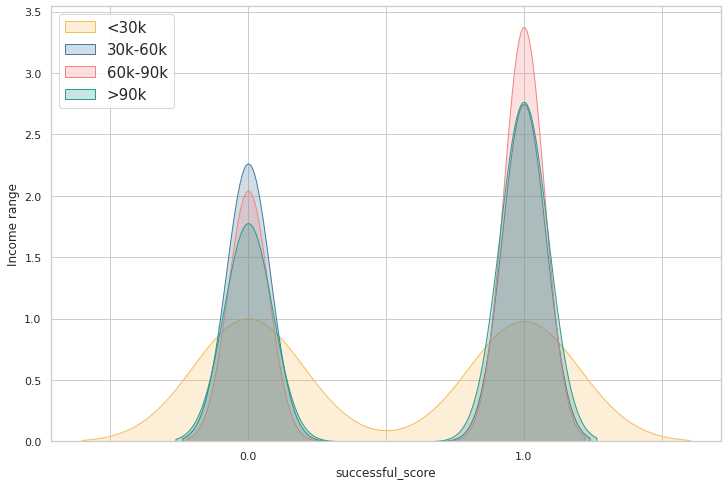

In [131]:
plt.figure(figsize=(12,8))
sns.set(style="whitegrid")
g = sns.distplot(sc01[sc01['income_<30k']==1].successful_score, 
             label='<30k', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f6bd60',
             hist_kws={'alpha':.4})

g = sns.distplot(sc01[sc01['income_30k-60k']==1].successful_score, 
             label='30k-60k', 
             hist=False,
             kde_kws={'shade':True},
             color = '#457b9d',
            hist_kws={'alpha':.4})
g = sns.distplot(sc01[sc01['income_60k-90k']==1].successful_score, 
             label='60k-90k', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f28482',
            hist_kws={'alpha':.4})
g = sns.distplot(sc01[sc01['income_>90k']==1].successful_score, 
             label='>90k', 
             hist=False,
             kde_kws={'shade':True},
             color = '#2a9d8f',
            hist_kws={'alpha':.4})
g.set_xticklabels(['','','0.0','', '1.0'])
plt.ylabel('Income range')
plt.legend(loc=2, fontsize=15)
plt.savefig('06-sc01-successful_score_income.png')

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

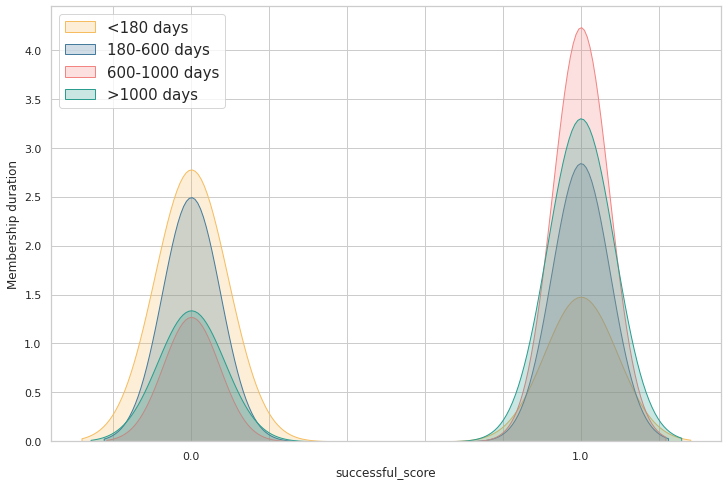

In [132]:
plt.figure(figsize=(12,8))
sns.set(style="whitegrid")
g = sns.distplot(sc01[sc01['member_<180 days']==1].successful_score, 
             label='<180 days', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f6bd60',
             hist_kws={'alpha':.4})

g = sns.distplot(sc01[sc01['member_180-600 days']==1].successful_score, 
             label='180-600 days', 
             hist=False,
             kde_kws={'shade':True},
             color = '#457b9d',
            hist_kws={'alpha':.4})
g = sns.distplot(sc01[sc01['member_600-1000 days']==1].successful_score, 
             label='600-1000 days', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f28482',
            hist_kws={'alpha':.4})
g = sns.distplot(sc01[sc01['member_>1000 days']==1].successful_score, 
             label='>1000 days', 
             hist=False,
             kde_kws={'shade':True},
             color = '#2a9d8f',
            hist_kws={'alpha':.4})
g.set_xticklabels(['','','0.0','', ' ','','','1.0'])
plt.ylabel('Membership duration')
plt.legend(loc=2, fontsize=15)
plt.savefig('06-sc01-successful_score_membership.png')

Because the demographic characteristics of the customers is the most important information in the data frame, I will analyze the users for each succesful score.
Furthermore, it is clear from the above plots, that the offer_id = 11, meaning single transactions not associated with any offer, are the majority of saccesful_score = 2. These transactions tell us that the users make purchases on the app that are not related to any offer. We than exclude these transactions.

### Successful score 1

In [133]:
sc1 = data[data.successful_score == 1]

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

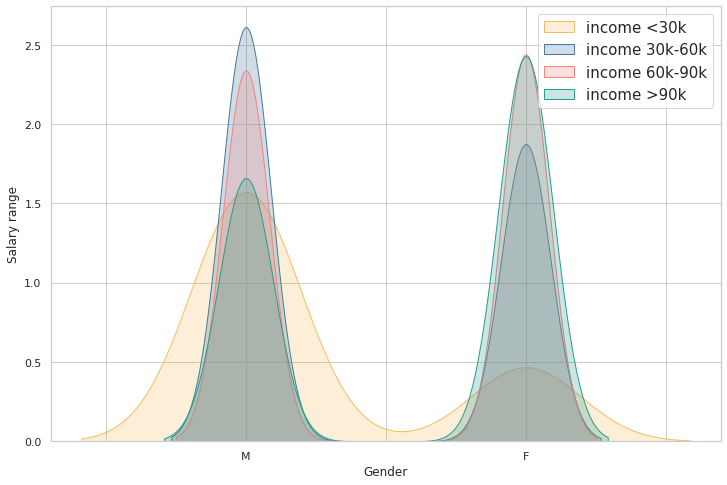

In [134]:
plt.figure(figsize=(12,8))
g = sns.distplot(sc1[sc1['income_<30k']==1]['gender-F'], 
             label='income <30k', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f6bd60',
             hist_kws={'alpha':.4})

sns.distplot(sc1[sc1['income_30k-60k']==1]['gender-F'], 
             label='income 30k-60k', 
             hist=False,
             kde_kws={'shade':True},
             color = '#457b9d',
             hist_kws={'alpha':.4})

g = sns.distplot(sc1[sc1['income_60k-90k']==1]['gender-F'], 
             label='income 60k-90k', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f28482',
             hist_kws={'alpha':.4})

sns.distplot(sc1[sc1['income_>90k']==1]['gender-F'], 
             label='income >90k', 
             hist=False,
             kde_kws={'shade':True},
             color = '#2a9d8f',
             hist_kws={'alpha':.4})

g.set_xticklabels(['','', 'M','','F',''])
plt.ylabel('Salary range')
plt.xlabel('Gender')
plt.legend(fontsize=15)
plt.savefig('sc1-gender_income.png')

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

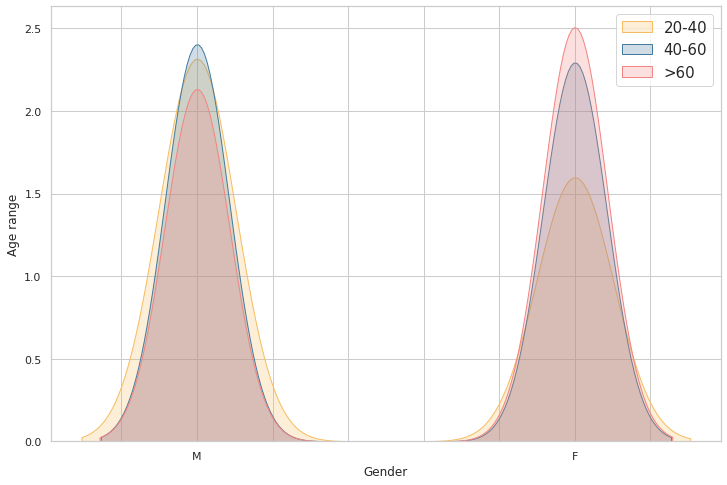

In [135]:
plt.figure(figsize=(12,8))
g = sns.distplot(sc1[sc1['age_20_40']==1]['gender-F'], 
             label='20-40', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f6bd60',
             hist_kws={'alpha':.4})

g = sns.distplot(sc1[sc1['age_40_60']==1]['gender-F'], 
             label='40-60', 
             hist=False,
             kde_kws={'shade':True},
             color = '#457b9d',
             hist_kws={'alpha':.4})

g = sns.distplot(sc1[sc1['age_>60']==1]['gender-F'], 
             label='>60', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f28482',
             hist_kws={'alpha':.4})

g.set_xticklabels(['','', 'M','','','','','F',''])
plt.ylabel('Age range')
plt.xlabel('Gender')

plt.legend(fontsize=15)
plt.savefig('sc1-gender_age.png')

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

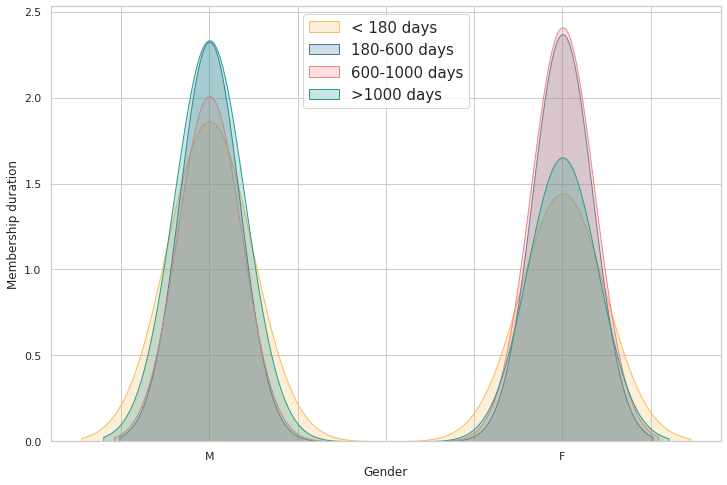

In [136]:
plt.figure(figsize=(12,8))
g = sns.distplot(sc1[sc1['member_<180 days']==1]['gender-F'], 
             label='< 180 days', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f6bd60',
             hist_kws={'alpha':.4})

g = sns.distplot(sc1[sc1['member_180-600 days']==1]['gender-F'], 
             label='180-600 days', 
             hist=False,
             kde_kws={'shade':True},
             color = '#457b9d',
             hist_kws={'alpha':.4})

sns.distplot(sc1[sc1['member_600-1000 days']==1]['gender-F'], 
             label='600-1000 days', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f28482',
             hist_kws={'alpha':.4})

sns.distplot(sc1[sc1['member_>1000 days']==1]['gender-F'], 
             label='>1000 days', 
             hist=False,
             kde_kws={'shade':True},
             color = '#2a9d8f',
             hist_kws={'alpha':.4})

g.set_xticklabels(['','', 'M','','','','F',''])
plt.ylabel('Membership duration')
plt.xlabel('Gender')
plt.legend(loc=9, fontsize=15)
plt.savefig('sc1-gender_membership.png')

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

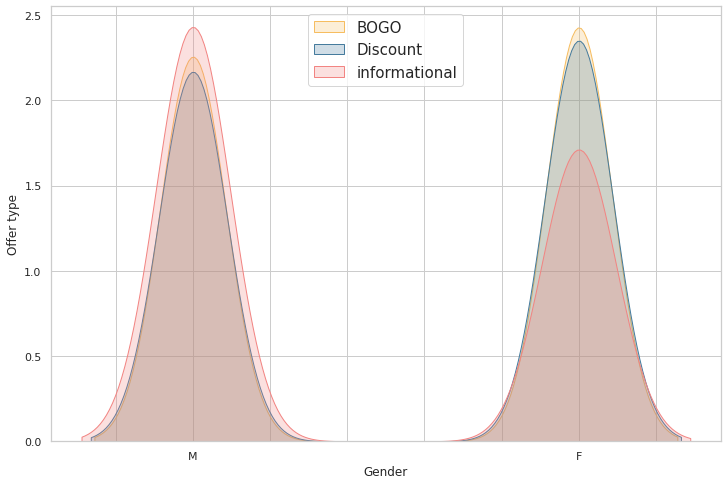

In [137]:
plt.figure(figsize=(12,8))
g = sns.distplot(sc1[sc1['offer_type-bogo']==1]['gender-F'], 
             label='BOGO', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f6bd60',
             hist_kws={'alpha':.4})

g = sns.distplot(sc1[sc1['offer_type-discount']==1]['gender-F'], 
             label='Discount', 
             hist=False,
             kde_kws={'shade':True},
             color = '#457b9d',
             hist_kws={'alpha':.4})

sns.distplot(sc1[sc1['offer_type-informational']==1]['gender-F'], 
             label='informational', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f28482',
             hist_kws={'alpha':.4})


g.set_xticklabels(['','', 'M','','','','','F',''])
plt.ylabel('Offer type')
plt.xlabel('Gender')
plt.legend(loc=9, fontsize=15)
plt.savefig('gender_offer_type.png')

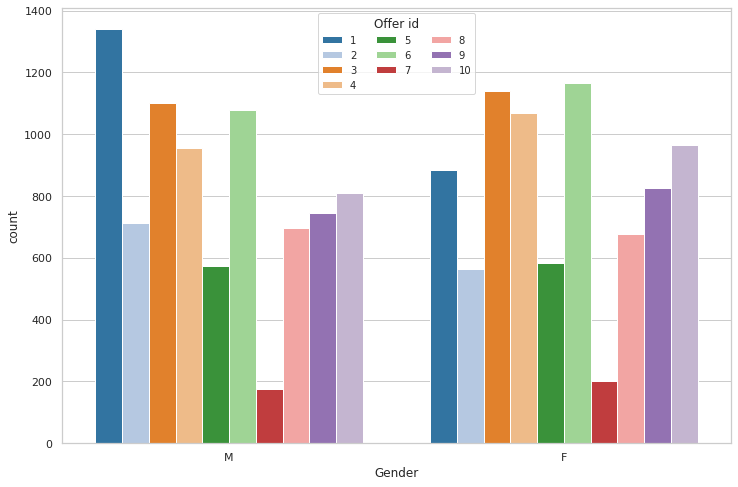

In [138]:
plt.figure(figsize=(12,8))
g = sns.countplot(x='gender-F', 
             hue = 'offer_id',
             data = sc1, 
             palette='tab20')
g.set_xticklabels(['M','F'])
plt.xlabel('Gender')
plt.legend(loc=9, title='Offer id', ncol=3, fontsize=10)
plt.savefig('sc1-gender_offer_id.png')

### Successful score 0

In [139]:
sc0 = data[data.successful_score == 0]

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

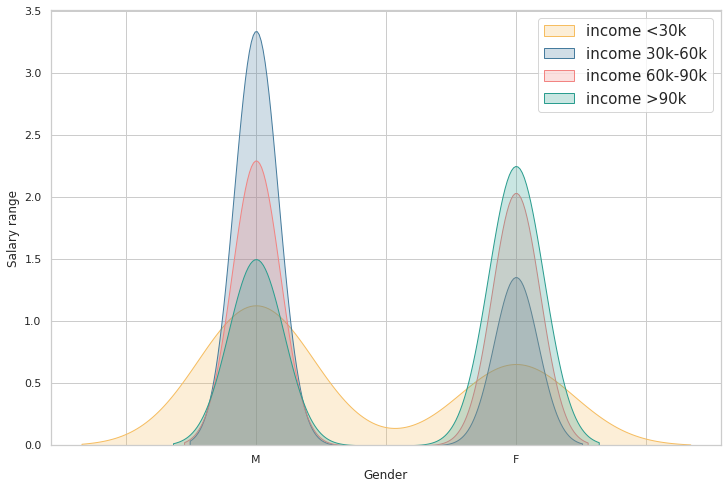

In [140]:
plt.figure(figsize=(12,8))
g = sns.distplot(sc0[sc0['income_<30k']==1]['gender-F'], 
             label='income <30k', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f6bd60',
             hist_kws={'alpha':.4})

sns.distplot(sc0[sc0['income_30k-60k']==1]['gender-F'], 
             label='income 30k-60k', 
             hist=False,
             kde_kws={'shade':True},
             color = '#457b9d',
             hist_kws={'alpha':.4})

g = sns.distplot(sc0[sc0['income_60k-90k']==1]['gender-F'], 
             label='income 60k-90k', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f28482',
             hist_kws={'alpha':.4})

sns.distplot(sc0[sc0['income_>90k']==1]['gender-F'], 
             label='income >90k', 
             hist=False,
             kde_kws={'shade':True},
             color = '#2a9d8f',
             hist_kws={'alpha':.4})

g.set_xticklabels(['','', 'M','','F',''])
plt.ylabel('Salary range')
plt.xlabel('Gender')
plt.legend(fontsize=15)
plt.savefig('sc0-gender_income.png')

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

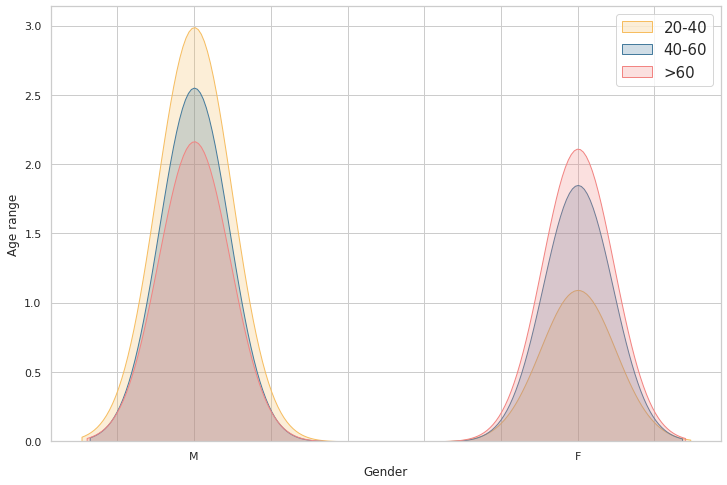

In [141]:
plt.figure(figsize=(12,8))
g = sns.distplot(sc0[sc0['age_20_40']==1]['gender-F'], 
             label='20-40', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f6bd60',
             hist_kws={'alpha':.4})

g = sns.distplot(sc0[sc0['age_40_60']==1]['gender-F'], 
             label='40-60', 
             hist=False,
             kde_kws={'shade':True},
             color = '#457b9d',
             hist_kws={'alpha':.4})

g = sns.distplot(sc0[sc0['age_>60']==1]['gender-F'], 
             label='>60', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f28482',
             hist_kws={'alpha':.4})

g.set_xticklabels(['','', 'M','','','','','F',''])
plt.ylabel('Age range')
plt.xlabel('Gender')

plt.legend(fontsize=15)
plt.savefig('sc0-gender_age.png')

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

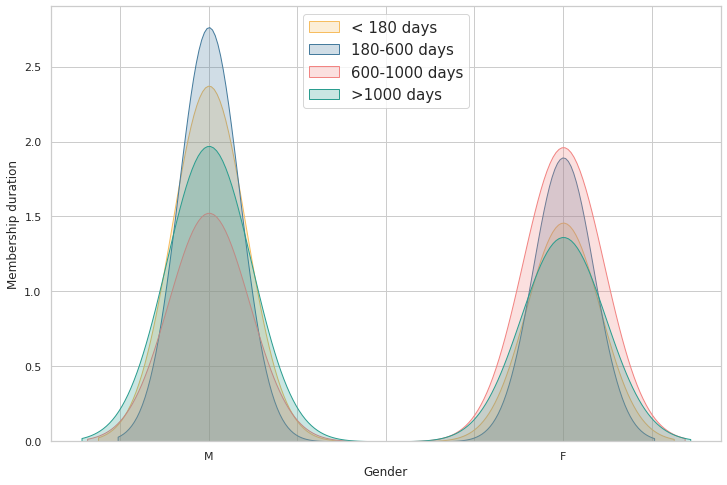

In [142]:
plt.figure(figsize=(12,8))
g = sns.distplot(sc0[sc0['member_<180 days']==1]['gender-F'], 
             label='< 180 days', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f6bd60',
             hist_kws={'alpha':.4})

g = sns.distplot(sc0[sc0['member_180-600 days']==1]['gender-F'], 
             label='180-600 days', 
             hist=False,
             kde_kws={'shade':True},
             color = '#457b9d',
             hist_kws={'alpha':.4})

sns.distplot(sc0[sc0['member_600-1000 days']==1]['gender-F'], 
             label='600-1000 days', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f28482',
             hist_kws={'alpha':.4})

sns.distplot(sc0[sc0['member_>1000 days']==1]['gender-F'], 
             label='>1000 days', 
             hist=False,
             kde_kws={'shade':True},
             color = '#2a9d8f',
             hist_kws={'alpha':.4})

g.set_xticklabels(['','', 'M','','','','F',''])
plt.ylabel('Membership duration')
plt.xlabel('Gender')
plt.legend(loc=9, fontsize=15)
plt.savefig('sc0-gender_membership.png')

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

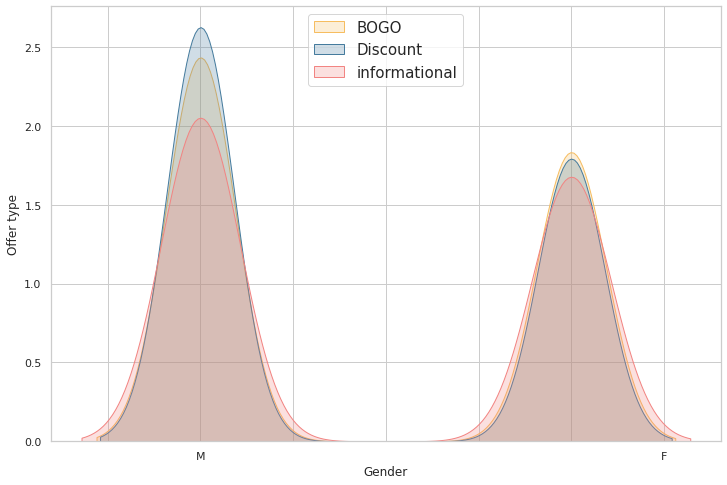

In [143]:
plt.figure(figsize=(12,8))
g = sns.distplot(sc0[sc0['offer_type-bogo']==1]['gender-F'], 
             label='BOGO', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f6bd60',
             hist_kws={'alpha':.4})

g = sns.distplot(sc0[sc0['offer_type-discount']==1]['gender-F'], 
             label='Discount', 
             hist=False,
             kde_kws={'shade':True},
             color = '#457b9d',
             hist_kws={'alpha':.4})

sns.distplot(sc0[sc0['offer_type-informational']==1]['gender-F'], 
             label='informational', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f28482',
             hist_kws={'alpha':.4})


g.set_xticklabels(['','', 'M','','','','','F',''])
plt.ylabel('Offer type')
plt.xlabel('Gender')
plt.legend(loc=9, fontsize=15)
plt.savefig('gender_offer_type.png')

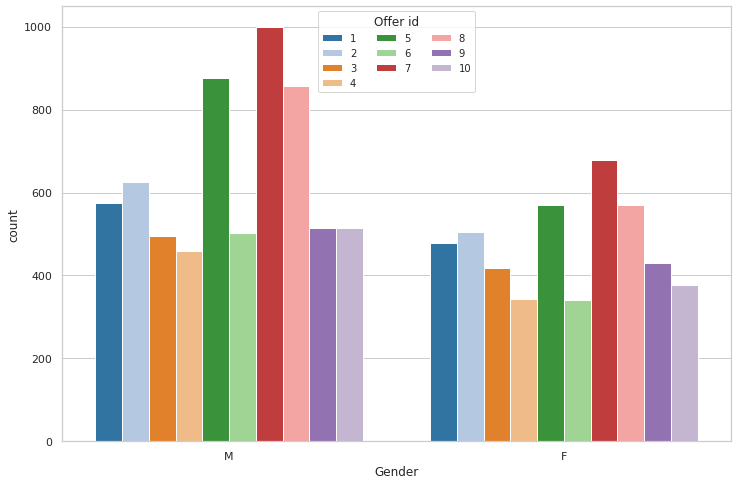

In [144]:
plt.figure(figsize=(12,8))
g = sns.countplot(x='gender-F', 
             hue = 'offer_id',
             data = sc0, 
             palette='tab20')
g.set_xticklabels(['M','F'])
plt.xlabel('Gender')
plt.legend(loc=9, title='Offer id', ncol=3, fontsize=10)
plt.savefig('sc0-gender_offer_id.png')

### Successful score 2

In [145]:
sc2 = data[data.successful_score == 2]

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

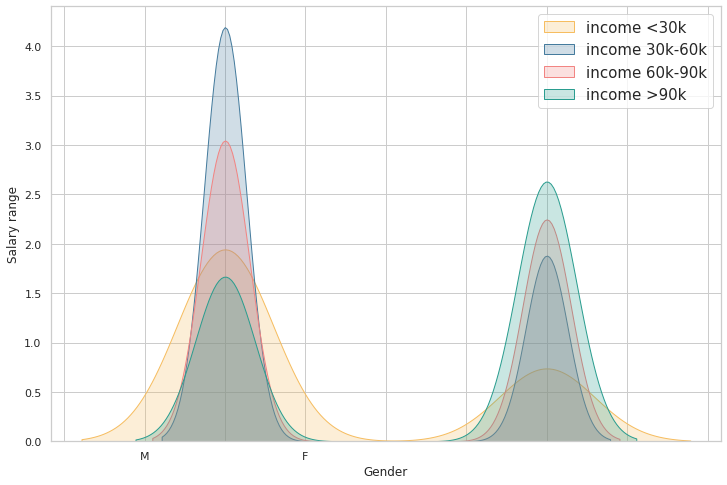

In [146]:
plt.figure(figsize=(12,8))
g = sns.distplot(sc2[sc2['income_<30k']==1]['gender-F'], 
             label='income <30k', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f6bd60',
             hist_kws={'alpha':.4})

sns.distplot(sc2[sc2['income_30k-60k']==1]['gender-F'], 
             label='income 30k-60k', 
             hist=False,
             kde_kws={'shade':True},
             color = '#457b9d',
             hist_kws={'alpha':.4})

g = sns.distplot(sc2[sc2['income_60k-90k']==1]['gender-F'], 
             label='income 60k-90k', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f28482',
             hist_kws={'alpha':.4})

sns.distplot(sc2[sc2['income_>90k']==1]['gender-F'], 
             label='income >90k', 
             hist=False,
             kde_kws={'shade':True},
             color = '#2a9d8f',
             hist_kws={'alpha':.4})

g.set_xticklabels(['','', 'M','','F',''])
plt.ylabel('Salary range')
plt.xlabel('Gender')
plt.legend(fontsize=15)
plt.savefig('sc2-gender_income.png')

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

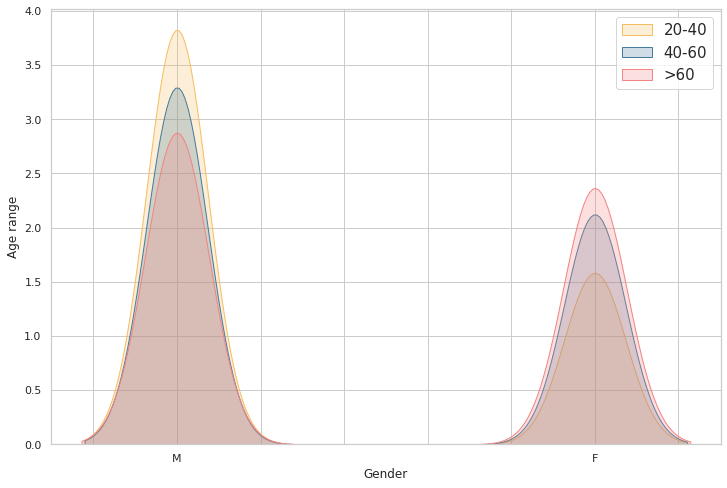

In [147]:
plt.figure(figsize=(12,8))
g = sns.distplot(sc2[sc2['age_20_40']==1]['gender-F'], 
             label='20-40', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f6bd60',
             hist_kws={'alpha':.4})

g = sns.distplot(sc2[sc2['age_40_60']==1]['gender-F'], 
             label='40-60', 
             hist=False,
             kde_kws={'shade':True},
             color = '#457b9d',
             hist_kws={'alpha':.4})

g = sns.distplot(sc2[sc2['age_>60']==1]['gender-F'], 
             label='>60', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f28482',
             hist_kws={'alpha':.4})

g.set_xticklabels(['','', 'M','','','','','F',''])
plt.ylabel('Age range')
plt.xlabel('Gender')

plt.legend(fontsize=15)
plt.savefig('sc2-gender_age.png')

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

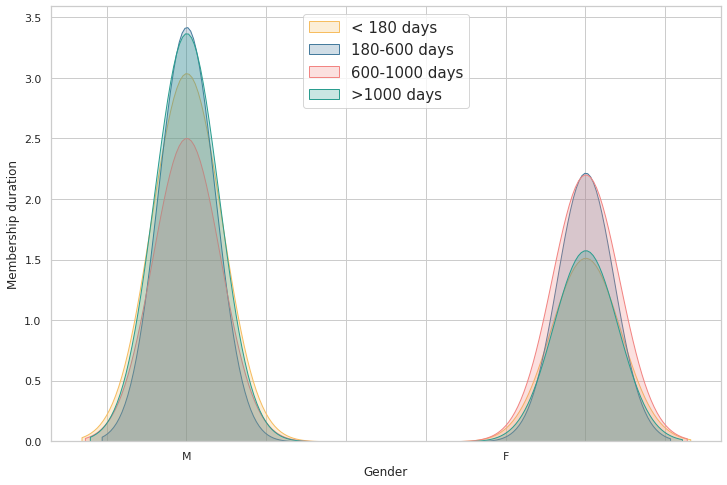

In [148]:
plt.figure(figsize=(12,8))
g = sns.distplot(sc2[sc2['member_<180 days']==1]['gender-F'], 
             label='< 180 days', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f6bd60',
             hist_kws={'alpha':.4})

g = sns.distplot(sc2[sc2['member_180-600 days']==1]['gender-F'], 
             label='180-600 days', 
             hist=False,
             kde_kws={'shade':True},
             color = '#457b9d',
             hist_kws={'alpha':.4})

sns.distplot(sc2[sc2['member_600-1000 days']==1]['gender-F'], 
             label='600-1000 days', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f28482',
             hist_kws={'alpha':.4})

sns.distplot(sc2[sc2['member_>1000 days']==1]['gender-F'], 
             label='>1000 days', 
             hist=False,
             kde_kws={'shade':True},
             color = '#2a9d8f',
             hist_kws={'alpha':.4})

g.set_xticklabels(['','', 'M','','','','F',''])
plt.ylabel('Membership duration')
plt.xlabel('Gender')
plt.legend(loc=9, fontsize=15)
plt.savefig('sc2-gender_membership.png')

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

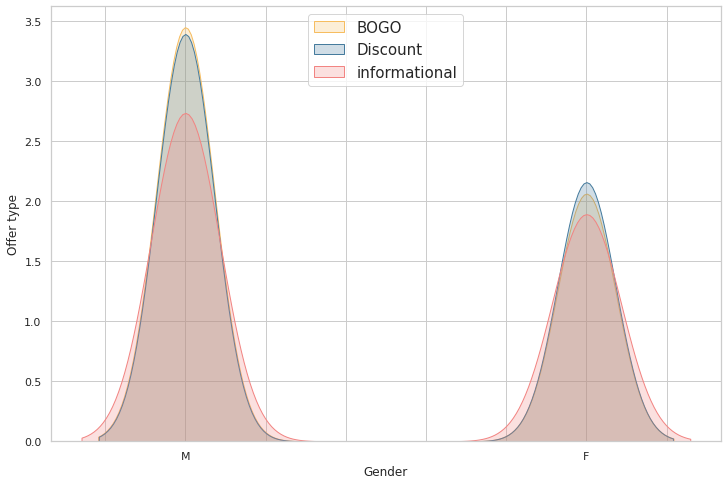

In [149]:
plt.figure(figsize=(12,8))
g = sns.distplot(sc2[sc2['offer_type-bogo']==1]['gender-F'], 
             label='BOGO', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f6bd60',
             hist_kws={'alpha':.4})

g = sns.distplot(sc2[sc2['offer_type-discount']==1]['gender-F'], 
             label='Discount', 
             hist=False,
             kde_kws={'shade':True},
             color = '#457b9d',
             hist_kws={'alpha':.4})

sns.distplot(sc2[sc2['offer_type-informational']==1]['gender-F'], 
             label='informational', 
             hist=False,
             kde_kws={'shade':True},
             color = '#f28482',
             hist_kws={'alpha':.4})


g.set_xticklabels(['','', 'M','','','','','F',''])
plt.ylabel('Offer type')
plt.xlabel('Gender')
plt.legend(loc=9, fontsize=15)
plt.savefig('gender_offer_type.png')

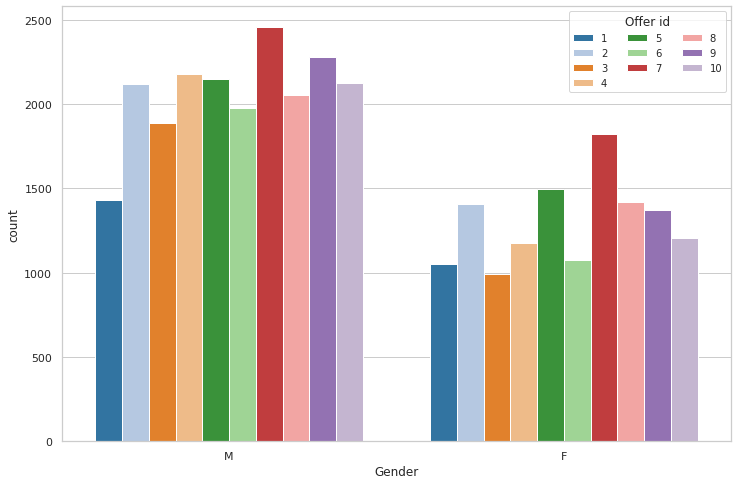

In [150]:
plt.figure(figsize=(12,8))
g = sns.countplot(x='gender-F', 
             hue = 'offer_id',
             data = sc2, 
             palette='tab20')
g.set_xticklabels(['M','F'])
plt.xlabel('Gender')
plt.legend(loc=0, title='Offer id', ncol=3, fontsize=10)
plt.savefig('sc2-gender_offer_id.png')

***Answer:*** 

The demographic group best responding to the offers are:
Female,
above 40 years old,
with an income above 60k.

The demographic group less interested in completing an offer are:
Male,
older than 40,
with an income between 30 to 60k.

Independently from the gender, individuals with an annual income below 30k are the lest likely to complete and offer.

# Methodology

The exploratory data analysis is now concluded. All the information we gathered from it will be now used to predict customers behavior.

To understand if an offer was effective, I defined earlier a successful score that can have 3 possible value: 1 if the offers was successfully completed by a user, 0 or 2 if it was not. 

For this analysis, I will not consider the case successful_score = 2 because this represents users that received an offer, but they made a purchase without being influenced by it.

The successful score will be the target feature, making this a **binary classification problem***.

## Approach

The best, unsupervised, algorithms to apply to a binary classification problem are (as documented here: https://en.wikipedia.org/wiki/Binary_classification, https://machinelearningmastery.com/types-of-classification-in-machine-learning/, https://towardsdatascience.com/top-10-binary-classification-algorithms-a-beginners-guide-feeacbd7a3e2):
* Logistic Regression
* Support Vector Machines
* Decision Tree
* Naive Bayes
* K-Nearest Neighbors
* Random Forest Classifier

I will run the models two times. In the first run, I will implement the models with their default parameters, and I will compare their performances by calculating the scores: Accuracy, Precision, Recall, F1, and the time a model needs to fit the data. 
In the second run, I used the function GridSearchCV to span across the models's hyper-parameters. The result, is the set of hyper-parameters that maximizes the model' performance.
I decided to consider all these score parameters for completeness, but for comparing the models with each other, i will consider Accuracy only.

## Data Preprocessing

### 1: Features Selection
From the exploratory data analysis, we understood that not all features in the data frame played a major role in influencing a customer decision. I will select only the features that are actually important.
Successful_score will be the target label.

### 2: Fill missing data, scale the data, and split the data in train and test
I will explore if the DataFrame contains missing data. If so, i will select the most appropriate approach to deal with them.
Aftewards, I will apply normalization operation to the features, and I will split the features and target label into train and test data.

##  Models implementation, evaluation and justification
As a first step, I will implement the above-mentioned models with default settings, evaluate their performance, and select the model with the best result.

## Models refinement, evaluation and justification
I will refine the best model by using a grid search to select the parameters that further maximize the model performance.

## Data Preprocessing

### Step 1: Features selection

In [151]:
successul_offers_df.columns

Index(['customer_id', 'offer_id', 'successful_score', 'difficulty', 'duration',
       'amount', 'reward', 'offer_type-bogo', 'offer_type-discount',
       'offer_type-informational', 'offer_validity_delta_t', 'channel-email',
       'channel-mobile', 'channel-social', 'channel-web', 'gender-F',
       'gender-M', 'age_20_40', 'age_40_60', 'age_>60', 'income_30k-60k',
       'income_60k-90k', 'income_<30k', 'income_>90k', 'member_180-600 days',
       'member_600-1000 days', 'member_<180 days', 'member_>1000 days'],
      dtype='object')

In [152]:
successul_offers_df.describe()

,offer_id,successful_score,difficulty,duration,amount,reward,offer_type-bogo,offer_type-discount,offer_type-informational,offer_validity_delta_t,...,age_40_60,age_>60,income_30k-60k,income_60k-90k,income_<30k,income_>90k,member_180-600 days,member_600-1000 days,member_<180 days,member_>1000 days
count,133869.000000,133869.000000,112878.000000,133869.000000,114215.000000,133869.000000,112878.000000,112878.000000,20991.0,20991.000000,...,133869.000000,133869.000000,133869.000000,133869.000000,133869.000000,133869.000000,133869.000000,133869.000000,133869.000000,133869.00000
mean,8.510058,1.712219,9.446455,160.490509,13.963616,4.404388,0.491912,0.508088,1.0,31.748749,...,0.387812,0.353898,0.494140,0.378997,0.006447,0.120416,0.423406,0.261390,0.091224,0.22398
std,3.328762,0.609313,4.124623,51.923606,31.768797,3.395983,0.499937,0.499937,0.0,34.942075,...,0.487253,0.478180,0.499968,0.485139,0.080032,0.325449,0.494100,0.439393,0.287928,0.41691
min,1.000000,0.000000,5.000000,72.000000,0.050000,0.000000,0.000000,0.000000,1.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,6.000000,2.000000,7.000000,120.000000,3.640000,2.000000,0.000000,0.000000,1.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,11.000000,2.000000,10.000000,168.000000,10.730000,5.000000,0.000000,1.000000,1.0,18.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,11.000000,2.000000,10.000000,168.000000,19.070000,5.000000,1.000000,1.000000,1.0,66.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.00000
max,11.000000,2.000000,20.000000,240.000000,1015.730000,10.000000,1.000000,1.000000,1.0,96.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


As explained above, models will be implemented on a DataFrame subset, excluding row with successful_score = 2 and offer_id = 11.

In [248]:
model_df = successul_offers_df[(successul_offers_df.offer_id != 11) & \
                              (successul_offers_df.successful_score != 2)]

From the data analysis, we saw that the communication channels and the membership duration are the least important features in terms of influence on users behaviors. These columns will be dropped.
Customer_id and offer_is will be also dropped because they don't contribute to add any significant information. As we observed, some offer ids were more popular than others, but their success (or not) was connected to the offer difficulty, duration, and reward.

In [249]:
model_df.drop(['customer_id',
               'offer_id',
               'channel-email',
               'amount',
           'channel-mobile', 
           'channel-social', 
           'channel-web',
           'member_180-600 days',
           'member_600-1000 days', 
           'member_<180 days', 
           'member_>1000 days', 
            'offer_validity_delta_t'], axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [250]:
model_df.describe()

,successful_score,difficulty,duration,reward,offer_type-bogo,offer_type-discount,offer_type-informational,gender-F,gender-M,age_20_40,age_40_60,age_>60,income_30k-60k,income_60k-90k,income_<30k,income_>90k
count,27394.000000,21712.000000,27394.000000,27394.000000,21712.000000,21712.000000,5682.0,27394.000000,27394.000000,27394.000000,27394.000000,27394.000000,27394.000000,27394.000000,27394.000000,27394.000000
mean,0.593670,9.148305,152.832007,4.087866,0.512850,0.487150,1.0,0.466708,0.533292,0.165255,0.433708,0.401037,0.349858,0.452508,0.003541,0.194094
std,0.491157,4.108218,52.354692,3.364102,0.499846,0.499846,0.0,0.498900,0.498900,0.371417,0.495595,0.490117,0.476934,0.497748,0.059401,0.395509
min,0.000000,5.000000,72.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,5.000000,120.000000,2.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,10.000000,168.000000,3.000000,1.000000,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,10.000000,168.000000,5.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,20.000000,240.000000,10.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Step 2: Fill missing data, scale the data, and split the data in train and test

In [251]:
model_df.isnull().sum()

successful_score                0
difficulty                   5682
duration                        0
reward                          0
offer_type-bogo              5682
offer_type-discount          5682
offer_type-informational    21712
gender-F                        0
gender-M                        0
age_20_40                       0
age_40_60                       0
age_>60                         0
income_30k-60k                  0
income_60k-90k                  0
income_<30k                     0
income_>90k                     0
dtype: int64

When the original features were hot encoded, some values were set to NaN instead of 0. The best way to deal with missing data, in this case, is to fill the rows with 0 value.

In [252]:
model_df = model_df.fillna(0)

In [253]:
# The DataFrame is split between fetures (X) and target label (Y)
X = model_df.drop('successful_score', axis=1).values
Y = model_df.successful_score.values

The features can now be scaled and split the dataset into training and testing sets

In [254]:
standardizer = StandardScaler()
X = standardizer.fit_transform(X)

In [255]:
X_train, X_test, y_train, y_test = train_test_split(X, Y , test_size=0.25, random_state=0)

## Models implementation, evaluation and justification

**First run**  
All the models are initialized and stored in a dictionary. The DL will be initialize separately.

In [256]:
models = {}

models['LRC'] = LogisticRegression(random_state=0)
models['SVM'] = SVC(random_state=0)
models['DTC'] = DecisionTreeClassifier(random_state=0)
models['NBC'] = GaussianNB()
models['KNN'] = KNeighborsClassifier()
models['RFC'] = RandomForestClassifier(random_state=0)

In [257]:
models

{'LRC': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 'SVM': SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, probability=False, random_state=0, shrinking=True,
   tol=0.001, verbose=False),
 'DTC': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best'),
 'NBC': GaussianNB(priors=None),
 'KNN': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metri

In [258]:
def models_application(model, X_train, y_train, X_test, y_test):

    """
    
    DESCRIPTION
        This function 
            - fits the train dataset with the input model, 
            - makes predictions on the testing data, and 
            - calculates the accuracy score.
    
    INPUT:
        model: the input model
        X_train (numpy array): training features
        y_train (numpy array): training label
        X_test (numpy array): test features
        y_testn (numpy array): test label
            
    OUTPUT:
        accuracy, precision, recall: the model's scores
        time_needed: the time needed to fit and predict the data
    """
       
    start = timeit.default_timer()
    
    # Fit the train dataset with the input model
    model.fit(X_train, y_train)
    
    # Make predictions on the test features
    pred = model.predict(X_test)
    
    end = timeit.default_timer()
    
    # Evaluate the time needed to fit and predict
    time_needed = round(end-start, 4)
    
    # Calculate Accuracy, Precision, Recall, and F1 metrics
    accuracy = accuracy_score(pred, y_test)
    precision = precision_score(pred, y_test) 
    recall = recall_score(pred, y_test)
    f1 = f1_score(pred, y_test)
    
    return accuracy, precision, recall, f1, time_needed

In [259]:
accuracy, precision, recall, f1, time = {}, {}, {}, {}, {}

In [260]:
for key in models:
    a, p, r, f, t =  models_application(models[key], X_train, y_train, X_test, y_test)
    accuracy[key] = a
    precision[key] = p
    recall[key] = r
    f1[key] = f
    time[key] = t

To compare the models's performance, I store the accuracy, precision, and recall in a DataFrame

In [261]:
models_df = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall', 'F1', 'Time', ])
models_df['Accuracy'] = accuracy.values()
models_df['Precision'] = precision.values()
models_df['Recall'] = recall.values()
models_df['F1'] = f1.values()
models_df['Time'] = time.values()

In [262]:
models_df

,Accuracy,Precision,Recall,F1,Time
LRC,0.651190,0.958140,0.638291,0.766174,0.0934
SVM,0.659512,0.890330,0.658757,0.757235,25.9482
DTC,0.658052,0.853121,0.666730,0.748497,0.0349
NBC,0.622573,0.870502,0.633642,0.733423,0.0082
KNN,0.591765,0.676132,0.652184,0.663942,1.7135
RFC,0.657468,0.847736,0.667631,0.746980,0.1214


In [263]:
models_df[models_df['Accuracy'] == models_df['Accuracy'].max()]

,Accuracy,Precision,Recall,F1,Time
SVM,0.659512,0.89033,0.658757,0.757235,25.9482


In [264]:
models_df[models_df['Precision'] == models_df['Precision'].max()]

,Accuracy,Precision,Recall,F1,Time
LRC,0.65119,0.95814,0.638291,0.766174,0.0934


In [265]:
models_df[models_df['Recall'] == models_df['Recall'].max()]

,Accuracy,Precision,Recall,F1,Time
RFC,0.657468,0.847736,0.667631,0.74698,0.1214


In [266]:
models_df[models_df['F1'] == models_df['F1'].max()]

,Accuracy,Precision,Recall,F1,Time
LRC,0.65119,0.95814,0.638291,0.766174,0.0934


From this first models run, Support Vector Machines is the best performing algorithm in terms of Accuracy.

## Models refinement, evaluation and justification


In [267]:
best_score = {}

**Logistic Regression**

In [268]:
param_grid={"C" : [0.1, 1, 10, 100], 
            "penalty":["l1","l2"]}

grid_search_LR = GridSearchCV(LogisticRegression(), param_grid, verbose=2)

In [271]:
grid_search_LR.fit(X_train,y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] C=0.1, penalty=l1 ...............................................
[CV] ................................ C=0.1, penalty=l1, total=   0.3s
[CV] C=0.1, penalty=l1 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ................................ C=0.1, penalty=l1, total=   0.3s
[CV] C=0.1, penalty=l1 ...............................................
[CV] ................................ C=0.1, penalty=l1, total=   0.2s
[CV] C=0.1, penalty=l2 ...............................................
[CV] ................................ C=0.1, penalty=l2, total=   0.1s
[CV] C=0.1, penalty=l2 ...............................................
[CV] ................................ C=0.1, penalty=l2, total=   0.1s
[CV] C=0.1, penalty=l2 ...............................................
[CV] ................................ C=0.1, penalty=l2, total=   0.1s
[CV] C=1, penalty=l1 .................................................
[CV] .................................. C=1, penalty=l1, total=   1.8s
[CV] C=1, penalty=l1 .................................................
[CV] .................................. C=1, penalty=l1, total=   2.4s
[CV] C=1, penalty=l1 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   12.1s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 1, 10, 100], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [272]:
best_score['LRC'] = grid_search_LR.best_score_

**Support Vector Machines**

In [273]:
param_grid = {'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.01, 0.001],
              'kernel': ['rbf']} 

grid_search_SVM = GridSearchCV(SVC(), param_grid, verbose=2)

In [274]:
grid_search_SVM.fit(X_train,y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  12.5s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.8s remaining:    0.0s


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  13.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  12.4s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] .................... C=0.1, gamma=0.01, kernel=rbf, total=  15.6s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] .................... C=0.1, gamma=0.01, kernel=rbf, total=  15.6s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] .................... C=0.1, gamma=0.01, kernel=rbf, total=  15.5s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ................... C=0.1, gamma=0.001, kernel=rbf, total=  16.6s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ................... C=0.1, gamma=0.001, kernel=rbf, total=  16.1s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 14.2min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.01, 0.001], 'kernel': ['rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [275]:
best_score['SVM'] = grid_search_SVM.best_score_

**Decision Tree**

In [276]:
param_grid = {'criterion' : ['gini', 'entropy'],
              'max_leaf_nodes': list(range(2, 10)),
              'max_depth' : range(1,20,2),
              'min_samples_leaf' : [1,3,5,7,9]
              }

grid_search_DTC = GridSearchCV(DecisionTreeClassifier(), param_grid, verbose=2)

In [277]:
grid_search_DTC.fit(X_train,y_train)

Fitting 3 folds for each of 800 candidates, totalling 2400 fits
[CV] criterion=gini, max_depth=1, max_leaf_nodes=2, min_samples_leaf=1 
[CV]  criterion=gini, max_depth=1, max_leaf_nodes=2, min_samples_leaf=1, total=   0.0s
[CV] criterion=gini, max_depth=1, max_leaf_nodes=2, min_samples_leaf=1 
[CV]  criterion=gini, max_depth=1, max_leaf_nodes=2, min_samples_leaf=1, total=   0.0s
[CV] criterion=gini, max_depth=1, max_leaf_nodes=2, min_samples_leaf=1 
[CV]  criterion=gini, max_depth=1, max_leaf_nodes=2, min_samples_leaf=1, total=   0.0s
[CV] criterion=gini, max_depth=1, max_leaf_nodes=2, min_samples_leaf=3 
[CV]  criterion=gini, max_depth=1, max_leaf_nodes=2, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=1, max_leaf_nodes=2, min_samples_leaf=3 
[CV]  criterion=gini, max_depth=1, max_leaf_nodes=2, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=1, max_leaf_nodes=2, min_samples_leaf=3 
[CV]  criterion=gini, max_depth=1, max_leaf_nodes=2, min_samples_leaf

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  criterion=gini, max_depth=1, max_leaf_nodes=2, min_samples_leaf=9, total=   0.0s
[CV] criterion=gini, max_depth=1, max_leaf_nodes=3, min_samples_leaf=1 
[CV]  criterion=gini, max_depth=1, max_leaf_nodes=3, min_samples_leaf=1, total=   0.0s
[CV] criterion=gini, max_depth=1, max_leaf_nodes=3, min_samples_leaf=1 
[CV]  criterion=gini, max_depth=1, max_leaf_nodes=3, min_samples_leaf=1, total=   0.0s
[CV] criterion=gini, max_depth=1, max_leaf_nodes=3, min_samples_leaf=1 
[CV]  criterion=gini, max_depth=1, max_leaf_nodes=3, min_samples_leaf=1, total=   0.0s
[CV] criterion=gini, max_depth=1, max_leaf_nodes=3, min_samples_leaf=3 
[CV]  criterion=gini, max_depth=1, max_leaf_nodes=3, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=1, max_leaf_nodes=3, min_samples_leaf=3 
[CV]  criterion=gini, max_depth=1, max_leaf_nodes=3, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=1, max_leaf_nodes=3, min_samples_leaf=3 
[CV]  criterion=gini, max_depth=1, max_leaf_no

[CV]  criterion=gini, max_depth=1, max_leaf_nodes=7, min_samples_leaf=1, total=   0.0s
[CV] criterion=gini, max_depth=1, max_leaf_nodes=7, min_samples_leaf=3 
[CV]  criterion=gini, max_depth=1, max_leaf_nodes=7, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=1, max_leaf_nodes=7, min_samples_leaf=3 
[CV]  criterion=gini, max_depth=1, max_leaf_nodes=7, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=1, max_leaf_nodes=7, min_samples_leaf=3 
[CV]  criterion=gini, max_depth=1, max_leaf_nodes=7, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=1, max_leaf_nodes=7, min_samples_leaf=5 
[CV]  criterion=gini, max_depth=1, max_leaf_nodes=7, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=1, max_leaf_nodes=7, min_samples_leaf=5 
[CV]  criterion=gini, max_depth=1, max_leaf_nodes=7, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=1, max_leaf_nodes=7, min_samples_leaf=5 
[CV]  criterion=gini, max_depth=1, max_leaf_no

[CV]  criterion=gini, max_depth=3, max_leaf_nodes=3, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=3, max_leaf_nodes=3, min_samples_leaf=5 
[CV]  criterion=gini, max_depth=3, max_leaf_nodes=3, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=3, max_leaf_nodes=3, min_samples_leaf=5 
[CV]  criterion=gini, max_depth=3, max_leaf_nodes=3, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=3, max_leaf_nodes=3, min_samples_leaf=5 
[CV]  criterion=gini, max_depth=3, max_leaf_nodes=3, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=3, max_leaf_nodes=3, min_samples_leaf=7 
[CV]  criterion=gini, max_depth=3, max_leaf_nodes=3, min_samples_leaf=7, total=   0.0s
[CV] criterion=gini, max_depth=3, max_leaf_nodes=3, min_samples_leaf=7 
[CV]  criterion=gini, max_depth=3, max_leaf_nodes=3, min_samples_leaf=7, total=   0.0s
[CV] criterion=gini, max_depth=3, max_leaf_nodes=3, min_samples_leaf=7 
[CV]  criterion=gini, max_depth=3, max_leaf_no

[CV]  criterion=gini, max_depth=3, max_leaf_nodes=7, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=3, max_leaf_nodes=7, min_samples_leaf=3 
[CV]  criterion=gini, max_depth=3, max_leaf_nodes=7, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=3, max_leaf_nodes=7, min_samples_leaf=5 
[CV]  criterion=gini, max_depth=3, max_leaf_nodes=7, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=3, max_leaf_nodes=7, min_samples_leaf=5 
[CV]  criterion=gini, max_depth=3, max_leaf_nodes=7, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=3, max_leaf_nodes=7, min_samples_leaf=5 
[CV]  criterion=gini, max_depth=3, max_leaf_nodes=7, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=3, max_leaf_nodes=7, min_samples_leaf=7 
[CV]  criterion=gini, max_depth=3, max_leaf_nodes=7, min_samples_leaf=7, total=   0.0s
[CV] criterion=gini, max_depth=3, max_leaf_nodes=7, min_samples_leaf=7 
[CV]  criterion=gini, max_depth=3, max_leaf_no

[CV]  criterion=gini, max_depth=5, max_leaf_nodes=3, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=5, max_leaf_nodes=3, min_samples_leaf=5 
[CV]  criterion=gini, max_depth=5, max_leaf_nodes=3, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=5, max_leaf_nodes=3, min_samples_leaf=5 
[CV]  criterion=gini, max_depth=5, max_leaf_nodes=3, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=5, max_leaf_nodes=3, min_samples_leaf=5 
[CV]  criterion=gini, max_depth=5, max_leaf_nodes=3, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=5, max_leaf_nodes=3, min_samples_leaf=7 
[CV]  criterion=gini, max_depth=5, max_leaf_nodes=3, min_samples_leaf=7, total=   0.0s
[CV] criterion=gini, max_depth=5, max_leaf_nodes=3, min_samples_leaf=7 
[CV]  criterion=gini, max_depth=5, max_leaf_nodes=3, min_samples_leaf=7, total=   0.0s
[CV] criterion=gini, max_depth=5, max_leaf_nodes=3, min_samples_leaf=7 
[CV]  criterion=gini, max_depth=5, max_leaf_no

[CV]  criterion=gini, max_depth=5, max_leaf_nodes=7, min_samples_leaf=1, total=   0.0s
[CV] criterion=gini, max_depth=5, max_leaf_nodes=7, min_samples_leaf=3 
[CV]  criterion=gini, max_depth=5, max_leaf_nodes=7, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=5, max_leaf_nodes=7, min_samples_leaf=3 
[CV]  criterion=gini, max_depth=5, max_leaf_nodes=7, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=5, max_leaf_nodes=7, min_samples_leaf=3 
[CV]  criterion=gini, max_depth=5, max_leaf_nodes=7, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=5, max_leaf_nodes=7, min_samples_leaf=5 
[CV]  criterion=gini, max_depth=5, max_leaf_nodes=7, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=5, max_leaf_nodes=7, min_samples_leaf=5 
[CV]  criterion=gini, max_depth=5, max_leaf_nodes=7, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=5, max_leaf_nodes=7, min_samples_leaf=5 
[CV]  criterion=gini, max_depth=5, max_leaf_no

[CV]  criterion=gini, max_depth=7, max_leaf_nodes=3, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=7, max_leaf_nodes=3, min_samples_leaf=5 
[CV]  criterion=gini, max_depth=7, max_leaf_nodes=3, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=7, max_leaf_nodes=3, min_samples_leaf=7 
[CV]  criterion=gini, max_depth=7, max_leaf_nodes=3, min_samples_leaf=7, total=   0.0s
[CV] criterion=gini, max_depth=7, max_leaf_nodes=3, min_samples_leaf=7 
[CV]  criterion=gini, max_depth=7, max_leaf_nodes=3, min_samples_leaf=7, total=   0.0s
[CV] criterion=gini, max_depth=7, max_leaf_nodes=3, min_samples_leaf=7 
[CV]  criterion=gini, max_depth=7, max_leaf_nodes=3, min_samples_leaf=7, total=   0.0s
[CV] criterion=gini, max_depth=7, max_leaf_nodes=3, min_samples_leaf=9 
[CV]  criterion=gini, max_depth=7, max_leaf_nodes=3, min_samples_leaf=9, total=   0.0s
[CV] criterion=gini, max_depth=7, max_leaf_nodes=3, min_samples_leaf=9 
[CV]  criterion=gini, max_depth=7, max_leaf_no

[CV]  criterion=gini, max_depth=7, max_leaf_nodes=7, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=7, max_leaf_nodes=7, min_samples_leaf=3 
[CV]  criterion=gini, max_depth=7, max_leaf_nodes=7, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=7, max_leaf_nodes=7, min_samples_leaf=5 
[CV]  criterion=gini, max_depth=7, max_leaf_nodes=7, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=7, max_leaf_nodes=7, min_samples_leaf=5 
[CV]  criterion=gini, max_depth=7, max_leaf_nodes=7, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=7, max_leaf_nodes=7, min_samples_leaf=5 
[CV]  criterion=gini, max_depth=7, max_leaf_nodes=7, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=7, max_leaf_nodes=7, min_samples_leaf=7 
[CV]  criterion=gini, max_depth=7, max_leaf_nodes=7, min_samples_leaf=7, total=   0.0s
[CV] criterion=gini, max_depth=7, max_leaf_nodes=7, min_samples_leaf=7 
[CV]  criterion=gini, max_depth=7, max_leaf_no

[CV]  criterion=gini, max_depth=9, max_leaf_nodes=3, min_samples_leaf=1, total=   0.0s
[CV] criterion=gini, max_depth=9, max_leaf_nodes=3, min_samples_leaf=1 
[CV]  criterion=gini, max_depth=9, max_leaf_nodes=3, min_samples_leaf=1, total=   0.0s
[CV] criterion=gini, max_depth=9, max_leaf_nodes=3, min_samples_leaf=1 
[CV]  criterion=gini, max_depth=9, max_leaf_nodes=3, min_samples_leaf=1, total=   0.0s
[CV] criterion=gini, max_depth=9, max_leaf_nodes=3, min_samples_leaf=3 
[CV]  criterion=gini, max_depth=9, max_leaf_nodes=3, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=9, max_leaf_nodes=3, min_samples_leaf=3 
[CV]  criterion=gini, max_depth=9, max_leaf_nodes=3, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=9, max_leaf_nodes=3, min_samples_leaf=3 
[CV]  criterion=gini, max_depth=9, max_leaf_nodes=3, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=9, max_leaf_nodes=3, min_samples_leaf=5 
[CV]  criterion=gini, max_depth=9, max_leaf_no

[CV]  criterion=gini, max_depth=9, max_leaf_nodes=6, min_samples_leaf=9, total=   0.0s
[CV] criterion=gini, max_depth=9, max_leaf_nodes=6, min_samples_leaf=9 
[CV]  criterion=gini, max_depth=9, max_leaf_nodes=6, min_samples_leaf=9, total=   0.0s
[CV] criterion=gini, max_depth=9, max_leaf_nodes=6, min_samples_leaf=9 
[CV]  criterion=gini, max_depth=9, max_leaf_nodes=6, min_samples_leaf=9, total=   0.0s
[CV] criterion=gini, max_depth=9, max_leaf_nodes=7, min_samples_leaf=1 
[CV]  criterion=gini, max_depth=9, max_leaf_nodes=7, min_samples_leaf=1, total=   0.0s
[CV] criterion=gini, max_depth=9, max_leaf_nodes=7, min_samples_leaf=1 
[CV]  criterion=gini, max_depth=9, max_leaf_nodes=7, min_samples_leaf=1, total=   0.0s
[CV] criterion=gini, max_depth=9, max_leaf_nodes=7, min_samples_leaf=1 
[CV]  criterion=gini, max_depth=9, max_leaf_nodes=7, min_samples_leaf=1, total=   0.0s
[CV] criterion=gini, max_depth=9, max_leaf_nodes=7, min_samples_leaf=3 
[CV]  criterion=gini, max_depth=9, max_leaf_no

[CV] criterion=gini, max_depth=11, max_leaf_nodes=3, min_samples_leaf=3 
[CV]  criterion=gini, max_depth=11, max_leaf_nodes=3, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=11, max_leaf_nodes=3, min_samples_leaf=3 
[CV]  criterion=gini, max_depth=11, max_leaf_nodes=3, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=11, max_leaf_nodes=3, min_samples_leaf=5 
[CV]  criterion=gini, max_depth=11, max_leaf_nodes=3, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=11, max_leaf_nodes=3, min_samples_leaf=5 
[CV]  criterion=gini, max_depth=11, max_leaf_nodes=3, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=11, max_leaf_nodes=3, min_samples_leaf=5 
[CV]  criterion=gini, max_depth=11, max_leaf_nodes=3, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=11, max_leaf_nodes=3, min_samples_leaf=7 
[CV]  criterion=gini, max_depth=11, max_leaf_nodes=3, min_samples_leaf=7, total=   0.0s
[CV] criterion=gini, max_depth=11,

[CV]  criterion=gini, max_depth=11, max_leaf_nodes=7, min_samples_leaf=1, total=   0.0s
[CV] criterion=gini, max_depth=11, max_leaf_nodes=7, min_samples_leaf=1 
[CV]  criterion=gini, max_depth=11, max_leaf_nodes=7, min_samples_leaf=1, total=   0.0s
[CV] criterion=gini, max_depth=11, max_leaf_nodes=7, min_samples_leaf=1 
[CV]  criterion=gini, max_depth=11, max_leaf_nodes=7, min_samples_leaf=1, total=   0.0s
[CV] criterion=gini, max_depth=11, max_leaf_nodes=7, min_samples_leaf=3 
[CV]  criterion=gini, max_depth=11, max_leaf_nodes=7, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=11, max_leaf_nodes=7, min_samples_leaf=3 
[CV]  criterion=gini, max_depth=11, max_leaf_nodes=7, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=11, max_leaf_nodes=7, min_samples_leaf=3 
[CV]  criterion=gini, max_depth=11, max_leaf_nodes=7, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=11, max_leaf_nodes=7, min_samples_leaf=5 
[CV]  criterion=gini, max_depth=11

[CV] criterion=gini, max_depth=13, max_leaf_nodes=2, min_samples_leaf=7 
[CV]  criterion=gini, max_depth=13, max_leaf_nodes=2, min_samples_leaf=7, total=   0.0s
[CV] criterion=gini, max_depth=13, max_leaf_nodes=2, min_samples_leaf=7 
[CV]  criterion=gini, max_depth=13, max_leaf_nodes=2, min_samples_leaf=7, total=   0.0s
[CV] criterion=gini, max_depth=13, max_leaf_nodes=2, min_samples_leaf=7 
[CV]  criterion=gini, max_depth=13, max_leaf_nodes=2, min_samples_leaf=7, total=   0.0s
[CV] criterion=gini, max_depth=13, max_leaf_nodes=2, min_samples_leaf=9 
[CV]  criterion=gini, max_depth=13, max_leaf_nodes=2, min_samples_leaf=9, total=   0.0s
[CV] criterion=gini, max_depth=13, max_leaf_nodes=2, min_samples_leaf=9 
[CV]  criterion=gini, max_depth=13, max_leaf_nodes=2, min_samples_leaf=9, total=   0.0s
[CV] criterion=gini, max_depth=13, max_leaf_nodes=2, min_samples_leaf=9 
[CV]  criterion=gini, max_depth=13, max_leaf_nodes=2, min_samples_leaf=9, total=   0.0s
[CV] criterion=gini, max_depth=13,

[CV]  criterion=gini, max_depth=13, max_leaf_nodes=6, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=13, max_leaf_nodes=6, min_samples_leaf=5 
[CV]  criterion=gini, max_depth=13, max_leaf_nodes=6, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=13, max_leaf_nodes=6, min_samples_leaf=7 
[CV]  criterion=gini, max_depth=13, max_leaf_nodes=6, min_samples_leaf=7, total=   0.0s
[CV] criterion=gini, max_depth=13, max_leaf_nodes=6, min_samples_leaf=7 
[CV]  criterion=gini, max_depth=13, max_leaf_nodes=6, min_samples_leaf=7, total=   0.0s
[CV] criterion=gini, max_depth=13, max_leaf_nodes=6, min_samples_leaf=7 
[CV]  criterion=gini, max_depth=13, max_leaf_nodes=6, min_samples_leaf=7, total=   0.0s
[CV] criterion=gini, max_depth=13, max_leaf_nodes=6, min_samples_leaf=9 
[CV]  criterion=gini, max_depth=13, max_leaf_nodes=6, min_samples_leaf=9, total=   0.0s
[CV] criterion=gini, max_depth=13, max_leaf_nodes=6, min_samples_leaf=9 
[CV]  criterion=gini, max_depth=13

[CV]  criterion=gini, max_depth=15, max_leaf_nodes=2, min_samples_leaf=7, total=   0.0s
[CV] criterion=gini, max_depth=15, max_leaf_nodes=2, min_samples_leaf=7 
[CV]  criterion=gini, max_depth=15, max_leaf_nodes=2, min_samples_leaf=7, total=   0.0s
[CV] criterion=gini, max_depth=15, max_leaf_nodes=2, min_samples_leaf=9 
[CV]  criterion=gini, max_depth=15, max_leaf_nodes=2, min_samples_leaf=9, total=   0.0s
[CV] criterion=gini, max_depth=15, max_leaf_nodes=2, min_samples_leaf=9 
[CV]  criterion=gini, max_depth=15, max_leaf_nodes=2, min_samples_leaf=9, total=   0.0s
[CV] criterion=gini, max_depth=15, max_leaf_nodes=2, min_samples_leaf=9 
[CV]  criterion=gini, max_depth=15, max_leaf_nodes=2, min_samples_leaf=9, total=   0.0s
[CV] criterion=gini, max_depth=15, max_leaf_nodes=3, min_samples_leaf=1 
[CV]  criterion=gini, max_depth=15, max_leaf_nodes=3, min_samples_leaf=1, total=   0.0s
[CV] criterion=gini, max_depth=15, max_leaf_nodes=3, min_samples_leaf=1 
[CV]  criterion=gini, max_depth=15

[CV] criterion=gini, max_depth=15, max_leaf_nodes=6, min_samples_leaf=7 
[CV]  criterion=gini, max_depth=15, max_leaf_nodes=6, min_samples_leaf=7, total=   0.0s
[CV] criterion=gini, max_depth=15, max_leaf_nodes=6, min_samples_leaf=7 
[CV]  criterion=gini, max_depth=15, max_leaf_nodes=6, min_samples_leaf=7, total=   0.0s
[CV] criterion=gini, max_depth=15, max_leaf_nodes=6, min_samples_leaf=7 
[CV]  criterion=gini, max_depth=15, max_leaf_nodes=6, min_samples_leaf=7, total=   0.0s
[CV] criterion=gini, max_depth=15, max_leaf_nodes=6, min_samples_leaf=9 
[CV]  criterion=gini, max_depth=15, max_leaf_nodes=6, min_samples_leaf=9, total=   0.0s
[CV] criterion=gini, max_depth=15, max_leaf_nodes=6, min_samples_leaf=9 
[CV]  criterion=gini, max_depth=15, max_leaf_nodes=6, min_samples_leaf=9, total=   0.0s
[CV] criterion=gini, max_depth=15, max_leaf_nodes=6, min_samples_leaf=9 
[CV]  criterion=gini, max_depth=15, max_leaf_nodes=6, min_samples_leaf=9, total=   0.0s
[CV] criterion=gini, max_depth=15,

[CV]  criterion=gini, max_depth=17, max_leaf_nodes=2, min_samples_leaf=9, total=   0.0s
[CV] criterion=gini, max_depth=17, max_leaf_nodes=3, min_samples_leaf=1 
[CV]  criterion=gini, max_depth=17, max_leaf_nodes=3, min_samples_leaf=1, total=   0.0s
[CV] criterion=gini, max_depth=17, max_leaf_nodes=3, min_samples_leaf=1 
[CV]  criterion=gini, max_depth=17, max_leaf_nodes=3, min_samples_leaf=1, total=   0.0s
[CV] criterion=gini, max_depth=17, max_leaf_nodes=3, min_samples_leaf=1 
[CV]  criterion=gini, max_depth=17, max_leaf_nodes=3, min_samples_leaf=1, total=   0.0s
[CV] criterion=gini, max_depth=17, max_leaf_nodes=3, min_samples_leaf=3 
[CV]  criterion=gini, max_depth=17, max_leaf_nodes=3, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=17, max_leaf_nodes=3, min_samples_leaf=3 
[CV]  criterion=gini, max_depth=17, max_leaf_nodes=3, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=17, max_leaf_nodes=3, min_samples_leaf=3 
[CV]  criterion=gini, max_depth=17

[CV]  criterion=gini, max_depth=17, max_leaf_nodes=6, min_samples_leaf=7, total=   0.0s
[CV] criterion=gini, max_depth=17, max_leaf_nodes=6, min_samples_leaf=9 
[CV]  criterion=gini, max_depth=17, max_leaf_nodes=6, min_samples_leaf=9, total=   0.0s
[CV] criterion=gini, max_depth=17, max_leaf_nodes=6, min_samples_leaf=9 
[CV]  criterion=gini, max_depth=17, max_leaf_nodes=6, min_samples_leaf=9, total=   0.0s
[CV] criterion=gini, max_depth=17, max_leaf_nodes=6, min_samples_leaf=9 
[CV]  criterion=gini, max_depth=17, max_leaf_nodes=6, min_samples_leaf=9, total=   0.0s
[CV] criterion=gini, max_depth=17, max_leaf_nodes=7, min_samples_leaf=1 
[CV]  criterion=gini, max_depth=17, max_leaf_nodes=7, min_samples_leaf=1, total=   0.0s
[CV] criterion=gini, max_depth=17, max_leaf_nodes=7, min_samples_leaf=1 
[CV]  criterion=gini, max_depth=17, max_leaf_nodes=7, min_samples_leaf=1, total=   0.0s
[CV] criterion=gini, max_depth=17, max_leaf_nodes=7, min_samples_leaf=1 
[CV]  criterion=gini, max_depth=17

[CV]  criterion=gini, max_depth=19, max_leaf_nodes=2, min_samples_leaf=1, total=   0.0s
[CV] criterion=gini, max_depth=19, max_leaf_nodes=2, min_samples_leaf=3 
[CV]  criterion=gini, max_depth=19, max_leaf_nodes=2, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=19, max_leaf_nodes=2, min_samples_leaf=3 
[CV]  criterion=gini, max_depth=19, max_leaf_nodes=2, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=19, max_leaf_nodes=2, min_samples_leaf=3 
[CV]  criterion=gini, max_depth=19, max_leaf_nodes=2, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=19, max_leaf_nodes=2, min_samples_leaf=5 
[CV]  criterion=gini, max_depth=19, max_leaf_nodes=2, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=19, max_leaf_nodes=2, min_samples_leaf=5 
[CV]  criterion=gini, max_depth=19, max_leaf_nodes=2, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=19, max_leaf_nodes=2, min_samples_leaf=5 
[CV]  criterion=gini, max_depth=19

[CV]  criterion=gini, max_depth=19, max_leaf_nodes=5, min_samples_leaf=7, total=   0.0s
[CV] criterion=gini, max_depth=19, max_leaf_nodes=5, min_samples_leaf=7 
[CV]  criterion=gini, max_depth=19, max_leaf_nodes=5, min_samples_leaf=7, total=   0.0s
[CV] criterion=gini, max_depth=19, max_leaf_nodes=5, min_samples_leaf=7 
[CV]  criterion=gini, max_depth=19, max_leaf_nodes=5, min_samples_leaf=7, total=   0.0s
[CV] criterion=gini, max_depth=19, max_leaf_nodes=5, min_samples_leaf=9 
[CV]  criterion=gini, max_depth=19, max_leaf_nodes=5, min_samples_leaf=9, total=   0.0s
[CV] criterion=gini, max_depth=19, max_leaf_nodes=5, min_samples_leaf=9 
[CV]  criterion=gini, max_depth=19, max_leaf_nodes=5, min_samples_leaf=9, total=   0.0s
[CV] criterion=gini, max_depth=19, max_leaf_nodes=5, min_samples_leaf=9 
[CV]  criterion=gini, max_depth=19, max_leaf_nodes=5, min_samples_leaf=9, total=   0.0s
[CV] criterion=gini, max_depth=19, max_leaf_nodes=6, min_samples_leaf=1 
[CV]  criterion=gini, max_depth=19

[CV]  criterion=gini, max_depth=19, max_leaf_nodes=9, min_samples_leaf=1, total=   0.0s
[CV] criterion=gini, max_depth=19, max_leaf_nodes=9, min_samples_leaf=1 
[CV]  criterion=gini, max_depth=19, max_leaf_nodes=9, min_samples_leaf=1, total=   0.0s
[CV] criterion=gini, max_depth=19, max_leaf_nodes=9, min_samples_leaf=1 
[CV]  criterion=gini, max_depth=19, max_leaf_nodes=9, min_samples_leaf=1, total=   0.0s
[CV] criterion=gini, max_depth=19, max_leaf_nodes=9, min_samples_leaf=3 
[CV]  criterion=gini, max_depth=19, max_leaf_nodes=9, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=19, max_leaf_nodes=9, min_samples_leaf=3 
[CV]  criterion=gini, max_depth=19, max_leaf_nodes=9, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=19, max_leaf_nodes=9, min_samples_leaf=3 
[CV]  criterion=gini, max_depth=19, max_leaf_nodes=9, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=19, max_leaf_nodes=9, min_samples_leaf=5 
[CV]  criterion=gini, max_depth=19

[CV]  criterion=entropy, max_depth=1, max_leaf_nodes=4, min_samples_leaf=7, total=   0.0s
[CV] criterion=entropy, max_depth=1, max_leaf_nodes=4, min_samples_leaf=7 
[CV]  criterion=entropy, max_depth=1, max_leaf_nodes=4, min_samples_leaf=7, total=   0.0s
[CV] criterion=entropy, max_depth=1, max_leaf_nodes=4, min_samples_leaf=9 
[CV]  criterion=entropy, max_depth=1, max_leaf_nodes=4, min_samples_leaf=9, total=   0.0s
[CV] criterion=entropy, max_depth=1, max_leaf_nodes=4, min_samples_leaf=9 
[CV]  criterion=entropy, max_depth=1, max_leaf_nodes=4, min_samples_leaf=9, total=   0.0s
[CV] criterion=entropy, max_depth=1, max_leaf_nodes=4, min_samples_leaf=9 
[CV]  criterion=entropy, max_depth=1, max_leaf_nodes=4, min_samples_leaf=9, total=   0.0s
[CV] criterion=entropy, max_depth=1, max_leaf_nodes=5, min_samples_leaf=1 
[CV]  criterion=entropy, max_depth=1, max_leaf_nodes=5, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=1, max_leaf_nodes=5, min_samples_leaf=1 
[CV]  crit

[CV]  criterion=entropy, max_depth=1, max_leaf_nodes=8, min_samples_leaf=9, total=   0.0s
[CV] criterion=entropy, max_depth=1, max_leaf_nodes=9, min_samples_leaf=1 
[CV]  criterion=entropy, max_depth=1, max_leaf_nodes=9, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=1, max_leaf_nodes=9, min_samples_leaf=1 
[CV]  criterion=entropy, max_depth=1, max_leaf_nodes=9, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=1, max_leaf_nodes=9, min_samples_leaf=1 
[CV]  criterion=entropy, max_depth=1, max_leaf_nodes=9, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=1, max_leaf_nodes=9, min_samples_leaf=3 
[CV]  criterion=entropy, max_depth=1, max_leaf_nodes=9, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=1, max_leaf_nodes=9, min_samples_leaf=3 
[CV]  criterion=entropy, max_depth=1, max_leaf_nodes=9, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=1, max_leaf_nodes=9, min_samples_leaf=3 
[CV]  crit

[CV]  criterion=entropy, max_depth=3, max_leaf_nodes=4, min_samples_leaf=9, total=   0.0s
[CV] criterion=entropy, max_depth=3, max_leaf_nodes=4, min_samples_leaf=9 
[CV]  criterion=entropy, max_depth=3, max_leaf_nodes=4, min_samples_leaf=9, total=   0.0s
[CV] criterion=entropy, max_depth=3, max_leaf_nodes=4, min_samples_leaf=9 
[CV]  criterion=entropy, max_depth=3, max_leaf_nodes=4, min_samples_leaf=9, total=   0.0s
[CV] criterion=entropy, max_depth=3, max_leaf_nodes=5, min_samples_leaf=1 
[CV]  criterion=entropy, max_depth=3, max_leaf_nodes=5, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=3, max_leaf_nodes=5, min_samples_leaf=1 
[CV]  criterion=entropy, max_depth=3, max_leaf_nodes=5, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=3, max_leaf_nodes=5, min_samples_leaf=1 
[CV]  criterion=entropy, max_depth=3, max_leaf_nodes=5, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=3, max_leaf_nodes=5, min_samples_leaf=3 
[CV]  crit

[CV]  criterion=entropy, max_depth=3, max_leaf_nodes=8, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=3, max_leaf_nodes=8, min_samples_leaf=5 
[CV]  criterion=entropy, max_depth=3, max_leaf_nodes=8, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=3, max_leaf_nodes=8, min_samples_leaf=7 
[CV]  criterion=entropy, max_depth=3, max_leaf_nodes=8, min_samples_leaf=7, total=   0.0s
[CV] criterion=entropy, max_depth=3, max_leaf_nodes=8, min_samples_leaf=7 
[CV]  criterion=entropy, max_depth=3, max_leaf_nodes=8, min_samples_leaf=7, total=   0.0s
[CV] criterion=entropy, max_depth=3, max_leaf_nodes=8, min_samples_leaf=7 
[CV]  criterion=entropy, max_depth=3, max_leaf_nodes=8, min_samples_leaf=7, total=   0.0s
[CV] criterion=entropy, max_depth=3, max_leaf_nodes=8, min_samples_leaf=9 
[CV]  criterion=entropy, max_depth=3, max_leaf_nodes=8, min_samples_leaf=9, total=   0.0s
[CV] criterion=entropy, max_depth=3, max_leaf_nodes=8, min_samples_leaf=9 
[CV]  crit

[CV]  criterion=entropy, max_depth=5, max_leaf_nodes=3, min_samples_leaf=9, total=   0.0s
[CV] criterion=entropy, max_depth=5, max_leaf_nodes=4, min_samples_leaf=1 
[CV]  criterion=entropy, max_depth=5, max_leaf_nodes=4, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=5, max_leaf_nodes=4, min_samples_leaf=1 
[CV]  criterion=entropy, max_depth=5, max_leaf_nodes=4, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=5, max_leaf_nodes=4, min_samples_leaf=1 
[CV]  criterion=entropy, max_depth=5, max_leaf_nodes=4, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=5, max_leaf_nodes=4, min_samples_leaf=3 
[CV]  criterion=entropy, max_depth=5, max_leaf_nodes=4, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=5, max_leaf_nodes=4, min_samples_leaf=3 
[CV]  criterion=entropy, max_depth=5, max_leaf_nodes=4, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=5, max_leaf_nodes=4, min_samples_leaf=3 
[CV]  crit

[CV]  criterion=entropy, max_depth=5, max_leaf_nodes=7, min_samples_leaf=7, total=   0.0s
[CV] criterion=entropy, max_depth=5, max_leaf_nodes=7, min_samples_leaf=7 
[CV]  criterion=entropy, max_depth=5, max_leaf_nodes=7, min_samples_leaf=7, total=   0.0s
[CV] criterion=entropy, max_depth=5, max_leaf_nodes=7, min_samples_leaf=7 
[CV]  criterion=entropy, max_depth=5, max_leaf_nodes=7, min_samples_leaf=7, total=   0.0s
[CV] criterion=entropy, max_depth=5, max_leaf_nodes=7, min_samples_leaf=9 
[CV]  criterion=entropy, max_depth=5, max_leaf_nodes=7, min_samples_leaf=9, total=   0.0s
[CV] criterion=entropy, max_depth=5, max_leaf_nodes=7, min_samples_leaf=9 
[CV]  criterion=entropy, max_depth=5, max_leaf_nodes=7, min_samples_leaf=9, total=   0.0s
[CV] criterion=entropy, max_depth=5, max_leaf_nodes=7, min_samples_leaf=9 
[CV]  criterion=entropy, max_depth=5, max_leaf_nodes=7, min_samples_leaf=9, total=   0.0s
[CV] criterion=entropy, max_depth=5, max_leaf_nodes=8, min_samples_leaf=1 
[CV]  crit

[CV]  criterion=entropy, max_depth=7, max_leaf_nodes=3, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=7, max_leaf_nodes=3, min_samples_leaf=5 
[CV]  criterion=entropy, max_depth=7, max_leaf_nodes=3, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=7, max_leaf_nodes=3, min_samples_leaf=7 
[CV]  criterion=entropy, max_depth=7, max_leaf_nodes=3, min_samples_leaf=7, total=   0.0s
[CV] criterion=entropy, max_depth=7, max_leaf_nodes=3, min_samples_leaf=7 
[CV]  criterion=entropy, max_depth=7, max_leaf_nodes=3, min_samples_leaf=7, total=   0.0s
[CV] criterion=entropy, max_depth=7, max_leaf_nodes=3, min_samples_leaf=7 
[CV]  criterion=entropy, max_depth=7, max_leaf_nodes=3, min_samples_leaf=7, total=   0.0s
[CV] criterion=entropy, max_depth=7, max_leaf_nodes=3, min_samples_leaf=9 
[CV]  criterion=entropy, max_depth=7, max_leaf_nodes=3, min_samples_leaf=9, total=   0.0s
[CV] criterion=entropy, max_depth=7, max_leaf_nodes=3, min_samples_leaf=9 
[CV]  crit

[CV]  criterion=entropy, max_depth=7, max_leaf_nodes=7, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=7, max_leaf_nodes=7, min_samples_leaf=3 
[CV]  criterion=entropy, max_depth=7, max_leaf_nodes=7, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=7, max_leaf_nodes=7, min_samples_leaf=5 
[CV]  criterion=entropy, max_depth=7, max_leaf_nodes=7, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=7, max_leaf_nodes=7, min_samples_leaf=5 
[CV]  criterion=entropy, max_depth=7, max_leaf_nodes=7, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=7, max_leaf_nodes=7, min_samples_leaf=5 
[CV]  criterion=entropy, max_depth=7, max_leaf_nodes=7, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=7, max_leaf_nodes=7, min_samples_leaf=7 
[CV]  criterion=entropy, max_depth=7, max_leaf_nodes=7, min_samples_leaf=7, total=   0.0s
[CV] criterion=entropy, max_depth=7, max_leaf_nodes=7, min_samples_leaf=7 
[CV]  crit

[CV]  criterion=entropy, max_depth=9, max_leaf_nodes=3, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=9, max_leaf_nodes=3, min_samples_leaf=1 
[CV]  criterion=entropy, max_depth=9, max_leaf_nodes=3, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=9, max_leaf_nodes=3, min_samples_leaf=1 
[CV]  criterion=entropy, max_depth=9, max_leaf_nodes=3, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=9, max_leaf_nodes=3, min_samples_leaf=3 
[CV]  criterion=entropy, max_depth=9, max_leaf_nodes=3, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=9, max_leaf_nodes=3, min_samples_leaf=3 
[CV]  criterion=entropy, max_depth=9, max_leaf_nodes=3, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=9, max_leaf_nodes=3, min_samples_leaf=3 
[CV]  criterion=entropy, max_depth=9, max_leaf_nodes=3, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=9, max_leaf_nodes=3, min_samples_leaf=5 
[CV]  crit

[CV]  criterion=entropy, max_depth=9, max_leaf_nodes=6, min_samples_leaf=9, total=   0.0s
[CV] criterion=entropy, max_depth=9, max_leaf_nodes=7, min_samples_leaf=1 
[CV]  criterion=entropy, max_depth=9, max_leaf_nodes=7, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=9, max_leaf_nodes=7, min_samples_leaf=1 
[CV]  criterion=entropy, max_depth=9, max_leaf_nodes=7, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=9, max_leaf_nodes=7, min_samples_leaf=1 
[CV]  criterion=entropy, max_depth=9, max_leaf_nodes=7, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=9, max_leaf_nodes=7, min_samples_leaf=3 
[CV]  criterion=entropy, max_depth=9, max_leaf_nodes=7, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=9, max_leaf_nodes=7, min_samples_leaf=3 
[CV]  criterion=entropy, max_depth=9, max_leaf_nodes=7, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=9, max_leaf_nodes=7, min_samples_leaf=3 
[CV]  crit

[CV]  criterion=entropy, max_depth=11, max_leaf_nodes=2, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=11, max_leaf_nodes=2, min_samples_leaf=5 
[CV]  criterion=entropy, max_depth=11, max_leaf_nodes=2, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=11, max_leaf_nodes=2, min_samples_leaf=7 
[CV]  criterion=entropy, max_depth=11, max_leaf_nodes=2, min_samples_leaf=7, total=   0.0s
[CV] criterion=entropy, max_depth=11, max_leaf_nodes=2, min_samples_leaf=7 
[CV]  criterion=entropy, max_depth=11, max_leaf_nodes=2, min_samples_leaf=7, total=   0.0s
[CV] criterion=entropy, max_depth=11, max_leaf_nodes=2, min_samples_leaf=7 
[CV]  criterion=entropy, max_depth=11, max_leaf_nodes=2, min_samples_leaf=7, total=   0.0s
[CV] criterion=entropy, max_depth=11, max_leaf_nodes=2, min_samples_leaf=9 
[CV]  criterion=entropy, max_depth=11, max_leaf_nodes=2, min_samples_leaf=9, total=   0.0s
[CV] criterion=entropy, max_depth=11, max_leaf_nodes=2, min_samples_leaf=9

[CV]  criterion=entropy, max_depth=11, max_leaf_nodes=5, min_samples_leaf=9, total=   0.0s
[CV] criterion=entropy, max_depth=11, max_leaf_nodes=5, min_samples_leaf=9 
[CV]  criterion=entropy, max_depth=11, max_leaf_nodes=5, min_samples_leaf=9, total=   0.0s
[CV] criterion=entropy, max_depth=11, max_leaf_nodes=6, min_samples_leaf=1 
[CV]  criterion=entropy, max_depth=11, max_leaf_nodes=6, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=11, max_leaf_nodes=6, min_samples_leaf=1 
[CV]  criterion=entropy, max_depth=11, max_leaf_nodes=6, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=11, max_leaf_nodes=6, min_samples_leaf=1 
[CV]  criterion=entropy, max_depth=11, max_leaf_nodes=6, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=11, max_leaf_nodes=6, min_samples_leaf=3 
[CV]  criterion=entropy, max_depth=11, max_leaf_nodes=6, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=11, max_leaf_nodes=6, min_samples_leaf=3

[CV]  criterion=entropy, max_depth=11, max_leaf_nodes=9, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=11, max_leaf_nodes=9, min_samples_leaf=3 
[CV]  criterion=entropy, max_depth=11, max_leaf_nodes=9, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=11, max_leaf_nodes=9, min_samples_leaf=5 
[CV]  criterion=entropy, max_depth=11, max_leaf_nodes=9, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=11, max_leaf_nodes=9, min_samples_leaf=5 
[CV]  criterion=entropy, max_depth=11, max_leaf_nodes=9, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=11, max_leaf_nodes=9, min_samples_leaf=5 
[CV]  criterion=entropy, max_depth=11, max_leaf_nodes=9, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=11, max_leaf_nodes=9, min_samples_leaf=7 
[CV]  criterion=entropy, max_depth=11, max_leaf_nodes=9, min_samples_leaf=7, total=   0.0s
[CV] criterion=entropy, max_depth=11, max_leaf_nodes=9, min_samples_leaf=7

[CV]  criterion=entropy, max_depth=13, max_leaf_nodes=4, min_samples_leaf=7, total=   0.0s
[CV] criterion=entropy, max_depth=13, max_leaf_nodes=4, min_samples_leaf=9 
[CV]  criterion=entropy, max_depth=13, max_leaf_nodes=4, min_samples_leaf=9, total=   0.0s
[CV] criterion=entropy, max_depth=13, max_leaf_nodes=4, min_samples_leaf=9 
[CV]  criterion=entropy, max_depth=13, max_leaf_nodes=4, min_samples_leaf=9, total=   0.0s
[CV] criterion=entropy, max_depth=13, max_leaf_nodes=4, min_samples_leaf=9 
[CV]  criterion=entropy, max_depth=13, max_leaf_nodes=4, min_samples_leaf=9, total=   0.0s
[CV] criterion=entropy, max_depth=13, max_leaf_nodes=5, min_samples_leaf=1 
[CV]  criterion=entropy, max_depth=13, max_leaf_nodes=5, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=13, max_leaf_nodes=5, min_samples_leaf=1 
[CV]  criterion=entropy, max_depth=13, max_leaf_nodes=5, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=13, max_leaf_nodes=5, min_samples_leaf=1

[CV]  criterion=entropy, max_depth=13, max_leaf_nodes=8, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=13, max_leaf_nodes=8, min_samples_leaf=3 
[CV]  criterion=entropy, max_depth=13, max_leaf_nodes=8, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=13, max_leaf_nodes=8, min_samples_leaf=5 
[CV]  criterion=entropy, max_depth=13, max_leaf_nodes=8, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=13, max_leaf_nodes=8, min_samples_leaf=5 
[CV]  criterion=entropy, max_depth=13, max_leaf_nodes=8, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=13, max_leaf_nodes=8, min_samples_leaf=5 
[CV]  criterion=entropy, max_depth=13, max_leaf_nodes=8, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=13, max_leaf_nodes=8, min_samples_leaf=7 
[CV]  criterion=entropy, max_depth=13, max_leaf_nodes=8, min_samples_leaf=7, total=   0.0s
[CV] criterion=entropy, max_depth=13, max_leaf_nodes=8, min_samples_leaf=7

[CV]  criterion=entropy, max_depth=15, max_leaf_nodes=4, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=15, max_leaf_nodes=4, min_samples_leaf=5 
[CV]  criterion=entropy, max_depth=15, max_leaf_nodes=4, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=15, max_leaf_nodes=4, min_samples_leaf=5 
[CV]  criterion=entropy, max_depth=15, max_leaf_nodes=4, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=15, max_leaf_nodes=4, min_samples_leaf=5 
[CV]  criterion=entropy, max_depth=15, max_leaf_nodes=4, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=15, max_leaf_nodes=4, min_samples_leaf=7 
[CV]  criterion=entropy, max_depth=15, max_leaf_nodes=4, min_samples_leaf=7, total=   0.0s
[CV] criterion=entropy, max_depth=15, max_leaf_nodes=4, min_samples_leaf=7 
[CV]  criterion=entropy, max_depth=15, max_leaf_nodes=4, min_samples_leaf=7, total=   0.0s
[CV] criterion=entropy, max_depth=15, max_leaf_nodes=4, min_samples_leaf=7

[CV]  criterion=entropy, max_depth=15, max_leaf_nodes=8, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=15, max_leaf_nodes=8, min_samples_leaf=1 
[CV]  criterion=entropy, max_depth=15, max_leaf_nodes=8, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=15, max_leaf_nodes=8, min_samples_leaf=1 
[CV]  criterion=entropy, max_depth=15, max_leaf_nodes=8, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=15, max_leaf_nodes=8, min_samples_leaf=3 
[CV]  criterion=entropy, max_depth=15, max_leaf_nodes=8, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=15, max_leaf_nodes=8, min_samples_leaf=3 
[CV]  criterion=entropy, max_depth=15, max_leaf_nodes=8, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=15, max_leaf_nodes=8, min_samples_leaf=3 
[CV]  criterion=entropy, max_depth=15, max_leaf_nodes=8, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=15, max_leaf_nodes=8, min_samples_leaf=5

[CV]  criterion=entropy, max_depth=17, max_leaf_nodes=4, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=17, max_leaf_nodes=4, min_samples_leaf=1 
[CV]  criterion=entropy, max_depth=17, max_leaf_nodes=4, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=17, max_leaf_nodes=4, min_samples_leaf=1 
[CV]  criterion=entropy, max_depth=17, max_leaf_nodes=4, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=17, max_leaf_nodes=4, min_samples_leaf=3 
[CV]  criterion=entropy, max_depth=17, max_leaf_nodes=4, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=17, max_leaf_nodes=4, min_samples_leaf=3 
[CV]  criterion=entropy, max_depth=17, max_leaf_nodes=4, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=17, max_leaf_nodes=4, min_samples_leaf=3 
[CV]  criterion=entropy, max_depth=17, max_leaf_nodes=4, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=17, max_leaf_nodes=4, min_samples_leaf=5

[CV]  criterion=entropy, max_depth=17, max_leaf_nodes=7, min_samples_leaf=7, total=   0.0s
[CV] criterion=entropy, max_depth=17, max_leaf_nodes=7, min_samples_leaf=7 
[CV]  criterion=entropy, max_depth=17, max_leaf_nodes=7, min_samples_leaf=7, total=   0.0s
[CV] criterion=entropy, max_depth=17, max_leaf_nodes=7, min_samples_leaf=9 
[CV]  criterion=entropy, max_depth=17, max_leaf_nodes=7, min_samples_leaf=9, total=   0.0s
[CV] criterion=entropy, max_depth=17, max_leaf_nodes=7, min_samples_leaf=9 
[CV]  criterion=entropy, max_depth=17, max_leaf_nodes=7, min_samples_leaf=9, total=   0.0s
[CV] criterion=entropy, max_depth=17, max_leaf_nodes=7, min_samples_leaf=9 
[CV]  criterion=entropy, max_depth=17, max_leaf_nodes=7, min_samples_leaf=9, total=   0.0s
[CV] criterion=entropy, max_depth=17, max_leaf_nodes=8, min_samples_leaf=1 
[CV]  criterion=entropy, max_depth=17, max_leaf_nodes=8, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=17, max_leaf_nodes=8, min_samples_leaf=1

[CV]  criterion=entropy, max_depth=19, max_leaf_nodes=3, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=19, max_leaf_nodes=3, min_samples_leaf=7 
[CV]  criterion=entropy, max_depth=19, max_leaf_nodes=3, min_samples_leaf=7, total=   0.0s
[CV] criterion=entropy, max_depth=19, max_leaf_nodes=3, min_samples_leaf=7 
[CV]  criterion=entropy, max_depth=19, max_leaf_nodes=3, min_samples_leaf=7, total=   0.0s
[CV] criterion=entropy, max_depth=19, max_leaf_nodes=3, min_samples_leaf=7 
[CV]  criterion=entropy, max_depth=19, max_leaf_nodes=3, min_samples_leaf=7, total=   0.0s
[CV] criterion=entropy, max_depth=19, max_leaf_nodes=3, min_samples_leaf=9 
[CV]  criterion=entropy, max_depth=19, max_leaf_nodes=3, min_samples_leaf=9, total=   0.0s
[CV] criterion=entropy, max_depth=19, max_leaf_nodes=3, min_samples_leaf=9 
[CV]  criterion=entropy, max_depth=19, max_leaf_nodes=3, min_samples_leaf=9, total=   0.0s
[CV] criterion=entropy, max_depth=19, max_leaf_nodes=3, min_samples_leaf=9

[CV]  criterion=entropy, max_depth=19, max_leaf_nodes=7, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=19, max_leaf_nodes=7, min_samples_leaf=5 
[CV]  criterion=entropy, max_depth=19, max_leaf_nodes=7, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=19, max_leaf_nodes=7, min_samples_leaf=5 
[CV]  criterion=entropy, max_depth=19, max_leaf_nodes=7, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=19, max_leaf_nodes=7, min_samples_leaf=5 
[CV]  criterion=entropy, max_depth=19, max_leaf_nodes=7, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=19, max_leaf_nodes=7, min_samples_leaf=7 
[CV]  criterion=entropy, max_depth=19, max_leaf_nodes=7, min_samples_leaf=7, total=   0.0s
[CV] criterion=entropy, max_depth=19, max_leaf_nodes=7, min_samples_leaf=7 
[CV]  criterion=entropy, max_depth=19, max_leaf_nodes=7, min_samples_leaf=7, total=   0.0s
[CV] criterion=entropy, max_depth=19, max_leaf_nodes=7, min_samples_leaf=7

[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:   43.7s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9], 'max_depth': range(1, 20, 2), 'min_samples_leaf': [1, 3, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [278]:
best_score['DTC'] = grid_search_DTC.best_score_

**Naive Bayes** 
This algorithm doeasn't have parameters to to tune. The only two that could be changed, priors and var_smoothing, returned an arror every time I tried to use them in GridSearchCV. Therefore, I will use the accuracy from the previous run as best score.

In [279]:
best_score['NBC'] = models_df[models_df.index == 'NBC']['Accuracy'][0]

**K-Nearest Neighbors**

In [280]:
param_grid = {'n_neighbors' : [3, 5, 9, 11, 15],
              'weights': ['uniform', 'distance'],
              'metric' : ['euclidean', 'manhattan']
              }

grid_search_KNN = GridSearchCV(KNeighborsClassifier(), param_grid, verbose=2)

In [281]:
grid_search_KNN.fit(X_train,y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] metric=euclidean, n_neighbors=3, weights=uniform ................
[CV] . metric=euclidean, n_neighbors=3, weights=uniform, total=   1.0s
[CV] metric=euclidean, n_neighbors=3, weights=uniform ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV] . metric=euclidean, n_neighbors=3, weights=uniform, total=   1.0s
[CV] metric=euclidean, n_neighbors=3, weights=uniform ................
[CV] . metric=euclidean, n_neighbors=3, weights=uniform, total=   1.0s
[CV] metric=euclidean, n_neighbors=3, weights=distance ...............
[CV]  metric=euclidean, n_neighbors=3, weights=distance, total=   0.8s
[CV] metric=euclidean, n_neighbors=3, weights=distance ...............
[CV]  metric=euclidean, n_neighbors=3, weights=distance, total=   0.8s
[CV] metric=euclidean, n_neighbors=3, weights=distance ...............
[CV]  metric=euclidean, n_neighbors=3, weights=distance, total=   0.8s
[CV] metric=euclidean, n_neighbors=5, weights=uniform ................
[CV] . metric=euclidean, n_neighbors=5, weights=uniform, total=   1.0s
[CV] metric=euclidean, n_neighbors=5, weights=uniform ................
[CV] . metric=euclidean, n_neighbors=5, weights=uniform, total=   1.0s
[CV] metric=euclidean, n_neighbors=5, weights=uniform ................
[CV] .

[CV]  metric=manhattan, n_neighbors=15, weights=distance, total=   0.9s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  2.6min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [3, 5, 9, 11, 15], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [282]:
best_score['KNN'] = grid_search_KNN.best_score_

**Random Forest Classifier**

In [283]:
param_grid = {'max_features': ['auto', 'sqrt'],
              'max_depth' : [5,10,15],
              'n_estimators': [25,30,40],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [2, 10,15]
              }

grid_search_RFC = GridSearchCV(RandomForestClassifier(), param_grid, verbose=2)

In [284]:
grid_search_RFC.fit(X_train,y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV] max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=25 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=25, total=   0.2s
[CV] max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=25 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=25, total=   0.2s
[CV] max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=25 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s



[CV]  max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=25, total=   0.2s
[CV] max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=30 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=30, total=   0.2s
[CV] max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=30 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=30, total=   0.2s
[CV] max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=30 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=30, total=   0.2s
[CV] max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=40 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=40, total=   0.3s
[CV] max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_

[CV]  max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=40, total=   0.3s
[CV] max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=40 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=40, total=   0.3s
[CV] max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=40 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=40, total=   0.3s
[CV] max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=25 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=25, total=   0.2s
[CV] max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=25 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=25, total=   0.2s
[CV] max_depth=5, max_features=auto, min_samples_leaf=10,

[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=25, total=   0.2s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=30 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=30, total=   0.2s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=30 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=30, total=   0.2s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=30 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=30, total=   0.2s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, total=   0.3s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_s

[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=40, total=   0.3s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=40 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=40, total=   0.3s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=40 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=40, total=   0.3s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=25 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=25, total=   0.2s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=25 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=25, total=   0.2s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=10,

[CV]  max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=25, total=   0.2s
[CV] max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=25 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=25, total=   0.2s
[CV] max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=30 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=30, total=   0.3s
[CV] max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=30 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=30, total=   0.3s
[CV] max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=30 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=30, total=   0.3s
[CV] max_depth=10, max_features=auto, min_samples_leaf=2, min

[CV]  max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=30, total=   0.2s
[CV] max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=40 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=40, total=   0.3s
[CV] max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=40 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=40, total=   0.3s
[CV] max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=40 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=40, total=   0.3s
[CV] max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=25 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=25, total=   0.2s
[CV] max_depth=10, max_features=auto, min_samples_

[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=25, total=   0.2s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=25 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=25, total=   0.2s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=25 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=25, total=   0.2s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=30 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=30, total=   0.3s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=30 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=30, total=   0.3s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=2, min

[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=30, total=   0.2s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=30 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=30, total=   0.2s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=40 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=40, total=   0.3s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=40 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=40, total=   0.3s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=40 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=40, total=   0.3s
[CV] max_depth=10, max_features=sqrt, min_samples_le

[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=15, min_samples_split=10, n_estimators=40, total=   0.3s
[CV] max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=25 
[CV]  max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=25, total=   0.2s
[CV] max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=25 
[CV]  max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=25, total=   0.2s
[CV] max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=25 
[CV]  max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=25, total=   0.2s
[CV] max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=30 
[CV]  max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=30, total=   0.3s
[CV] max_depth=15, max_features=auto, min_samples_leaf=2, m

[CV]  max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=30, total=   0.2s
[CV] max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=30 
[CV]  max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=30, total=   0.3s
[CV] max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=30 
[CV]  max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=30, total=   0.2s
[CV] max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=40 
[CV]  max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=40, total=   0.3s
[CV] max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=40 
[CV]  max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=40, total=   0.3s
[CV] max_depth=15, max_features=auto, min_samples_le

[CV]  max_depth=15, max_features=auto, min_samples_leaf=15, min_samples_split=10, n_estimators=40, total=   0.3s
[CV] max_depth=15, max_features=auto, min_samples_leaf=15, min_samples_split=10, n_estimators=40 
[CV]  max_depth=15, max_features=auto, min_samples_leaf=15, min_samples_split=10, n_estimators=40, total=   0.3s
[CV] max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=25 
[CV]  max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=25, total=   0.2s
[CV] max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=25 
[CV]  max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=25, total=   0.2s
[CV] max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=25 
[CV]  max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=25, total=   0.2s
[CV] max_depth=15, max_features=sqrt, min_samples_leaf=

[CV]  max_depth=15, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=25, total=   0.2s
[CV] max_depth=15, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=30 
[CV]  max_depth=15, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=30, total=   0.2s
[CV] max_depth=15, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=30 
[CV]  max_depth=15, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=30, total=   0.2s
[CV] max_depth=15, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=30 
[CV]  max_depth=15, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=30, total=   0.3s
[CV] max_depth=15, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=40 
[CV]  max_depth=15, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=40, total=   0.3s
[CV] max_depth=15, max_features=sqrt, min_samples_le

[CV]  max_depth=15, max_features=sqrt, min_samples_leaf=15, min_samples_split=10, n_estimators=40, total=   0.3s
[CV] max_depth=15, max_features=sqrt, min_samples_leaf=15, min_samples_split=10, n_estimators=40 
[CV]  max_depth=15, max_features=sqrt, min_samples_leaf=15, min_samples_split=10, n_estimators=40, total=   0.3s
[CV] max_depth=15, max_features=sqrt, min_samples_leaf=15, min_samples_split=10, n_estimators=40 
[CV]  max_depth=15, max_features=sqrt, min_samples_leaf=15, min_samples_split=10, n_estimators=40, total=   0.3s


[Parallel(n_jobs=1)]: Done 486 out of 486 | elapsed:  2.4min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15], 'n_estimators': [25, 30, 40], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [2, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [285]:
best_score['RFC'] = grid_search_RFC.best_score_

In [286]:
best_score

{'LRC': 0.6500851788756389,
 'SVM': 0.6606960330980773,
 'DTC': 0.6498418106595278,
 'NBC': 0.6225726383413637,
 'KNN': 0.6527135556096374,
 'RFC': 0.6631297152591872}

In [287]:
max(best_score.values())

0.6631297152591872

In [288]:
max(best_score, key=best_score.get)

'RFC'

The model with the best performances is the **Random Forest Classifier**.

### Feature importance

We will now fit the data with the best model (Decision Tree Classifier with the best parameters), and then identify the features that mostly influenced an offer success.

In [290]:
grid_search_RFC.best_params_

{'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 15,
 'min_samples_split': 5,
 'n_estimators': 25}

In [299]:
best_model_RFC = RandomForestClassifier(max_depth = 15, 
                                        max_features = 'sqrt', 
                                        min_samples_leaf = 15, 
                                        min_samples_split = 5, 
                                        n_estimators = 25)

In [300]:
model_df_2 = model_df.drop('successful_score', axis=1)

In [301]:
# fit the data
best_model_RFC.fit(X_train, y_train)
    
# Make predictions on the test features
pred_RFC = best_model_RFC.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 metrics
accuracy_RFC = accuracy_score(pred_RFC, y_test)
precision_RFC = precision_score(pred_RFC, y_test) 
recall_RFC = recall_score(pred_RFC, y_test)
f1_RFC = f1_score(pred_RFC, y_test)

In [302]:
print('Random Forest best model performances:')
print(f'Accuracy: {accuracy_RFC}')
print(f'Precision: {precision_RFC}')
print(f'Recall: {recall_RFC}')
print(f'F1: {f1_RFC}')

Random Forest best model performances:
Accuracy: 0.6587823039859834
Precision: 0.8827417380660955
Recall: 0.6599560761346999
F1: 0.7552623311341502


In [311]:
feat_importances_RFC = pd.Series(best_model_RFC.feature_importances_, index=model_df_2.columns).sort_values(ascending=False)

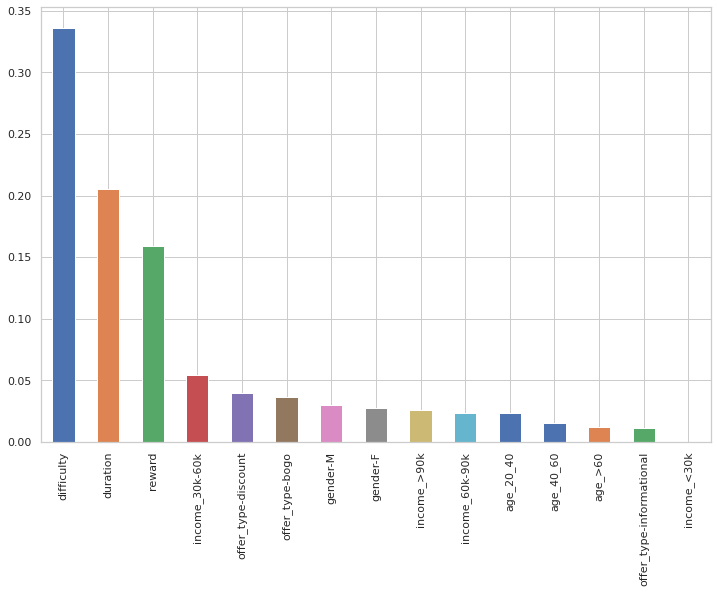

In [312]:
plt.figure(figsize=(12,8))
sns.set(style="whitegrid")
feat_importances_RFC.plot.bar()
# g.set_xticklabels(['','','0', '','','1',''])
plt.savefig('final-feat_importances_RFC.png')

# Conclusions

I analyzed a dataset containing a simplified version of the Starbucks reward system. In the data analysis phase, I defined a metric to understand if the an offer was successful or not, and I investigated the features that played the most important role in influencing a user decision to complete an offer.
I then modeled the data with 6 different classifier, first run with the default parameters, and then searching for the hyper-parameters that would improve their performance.
From the data analysis, I concluded that the demographic group best responding to the offers are:
Female,
above 40 years old,
with an income above 60k.

The offers with the best balance between difficulty, duration, and reward have the highest change to be completed.
From the modeling, I concluded that:
The best model is the Support Vector Machines, if the parameters are left as default.
The best model is the Random Forest Classifier, if the parameters are set after running the GridSearchCV function.
The features mostly influencing an offer success are confirmed to be difficulty, duration, and reward.

### Reflections and Improvement
My methodology had the strength of discriminating between successful and unsuccessful offers. To improve the analysis, I could try to understand how much a completed offer was responsible for subsequent transactions.
Indeed, in the dataset most of transaction were not related to any offer (the offer was not received before the transaction happened), meaning that they were made after an offer was received, or viewed, or completed.
This more detailed analysis could help Starbuck to have full understand of how much effective is the reward system.